In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd

def rr_windows_by_count(rr_t_s: np.ndarray, rr_s: np.ndarray, *, win_n: int = 100, step_n: int = 10):
    """Generate beat-count-based windows over RR series."""
    rr_t_s = np.asarray(rr_t_s, float)
    rr_s = np.asarray(rr_s, float)
    n = len(rr_s)
    for i0 in range(0, n - win_n + 1, step_n):
        i1 = i0 + win_n
        yield i0, i1, rr_t_s[i0:i1], rr_s[i0:i1]

def poincare_sd1_sd2(rr_s: np.ndarray) -> tuple[float, float]:
    rr = np.asarray(rr_s, float)
    d = np.diff(rr)
    sd_rr = np.std(rr, ddof=1) if len(rr) > 1 else np.nan
    sd_d  = np.std(d, ddof=1) if len(d) > 1 else np.nan
    sd1 = np.sqrt(0.5) * sd_d
    # SD2 formula derived from Poincaré geometry
    sd2_sq = (2 * (sd_rr ** 2) - 0.5 * (sd_d ** 2)) if np.isfinite(sd_rr) and np.isfinite(sd_d) else np.nan
    sd2 = np.sqrt(sd2_sq) if (sd2_sq is not np.nan and sd2_sq > 0) else np.nan
    return sd1, sd2

def rr_slope_ms_per_min(rr_t_s: np.ndarray, rr_s: np.ndarray) -> float:
    """Least-squares slope of RR(t). Returns ms/min."""
    t = np.asarray(rr_t_s, float)
    rr = np.asarray(rr_s, float)
    if len(rr) < 3:
        return np.nan
    t0 = t - t[0]
    A = np.vstack([t0, np.ones_like(t0)]).T
    m, b = np.linalg.lstsq(A, rr, rcond=None)[0]  # rr in seconds per second
    return m * 1000.0 * 60.0  # ms/min

def compute_features_for_recording(
    recording_uid: int,
    rr_t_s: np.ndarray,
    rr_s: np.ndarray,
    *,
    win_n: int = 100,
    step_n: int = 10,
) -> pd.DataFrame:
    rows = []
    for i0, i1, t_win, rr_win in rr_windows_by_count(rr_t_s, rr_s, win_n=win_n, step_n=step_n):
        sd1, sd2 = poincare_sd1_sd2(rr_win)
        csi = (sd2 / sd1) if (np.isfinite(sd1) and sd1 > 0 and np.isfinite(sd2)) else np.nan

        rows.append({
            "recording_uid": int(recording_uid),
            "rr_i0": int(i0),
            "rr_i1": int(i1),
            "feat_t_start_s": float(t_win[0]),
            "feat_t_end_s": float(t_win[-1]),
            "sd1": sd1,
            "sd2": sd2,
            "csi": csi,
            # placeholder "modcsi" — adjust if you have Jeppesen exact definition
            "modcsi": csi,
            "rr_slope_ms_per_min": rr_slope_ms_per_min(t_win, rr_win),
        })
    return pd.DataFrame(rows)


In [2]:
def attach_quality_to_features(
    df_feat: pd.DataFrame,
    windows_df: pd.DataFrame,
    *,
    accept_col: str = "is_acceptable",
    threshold_frac: float = 0.8,
) -> pd.DataFrame:
    """
    For each feature window, compute fraction of time overlapping acceptable ECG windows.
    """
    w = windows_df.drop_duplicates(subset=["recording_uid","window_idx"]).copy()
    w["dur_s"] = (w["win_end_s"] - w["win_start_s"]).astype(float)
    w["is_acc"] = w[accept_col].astype(bool)

    out = []
    for rid, g in df_feat.groupby("recording_uid", sort=False):
        ww = w[w["recording_uid"] == rid]
        if ww.empty:
            gg = g.copy()
            gg["q_frac_acc"] = np.nan
            gg["q_is_acc"] = False
            out.append(gg)
            continue

        starts = ww["win_start_s"].to_numpy()
        ends   = ww["win_end_s"].to_numpy()
        isacc  = ww["is_acc"].to_numpy()

        # brute-force over feature windows (ok scale for thesis; can optimize later)
        for _, r in g.iterrows():
            a = float(r["feat_t_start_s"])
            b = float(r["feat_t_end_s"])
            ov = (ends > a) & (starts < b)
            if not np.any(ov):
                qfrac = np.nan
            else:
                # overlap length per window
                ov_len = np.minimum(ends[ov], b) - np.maximum(starts[ov], a)
                ov_len = np.clip(ov_len, 0, None)
                tot = np.sum(ov_len)
                acc = np.sum(ov_len[isacc[ov]])
                qfrac = (acc / tot) if tot > 0 else np.nan

            rr_row = dict(r)
            rr_row["q_frac_acc"] = qfrac
            rr_row["q_is_acc"] = bool(np.isfinite(qfrac) and (qfrac >= threshold_frac))
            out.append(rr_row)

    return pd.DataFrame(out)


In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
import re
import numpy as np
import pandas as pd

# -----------------------------
# IO: load aligned RR files
# -----------------------------
@dataclass
class RRFile:
    path: Path
    set_name: str   # "Raw" or "Trim"
    recording_uid: int
    algo_id: str    # e.g. "neurokit", "pantompkins1985", ...
    has_labview: bool = True

def _parse_rr_filename(p: Path) -> tuple[int, str]:
    """
    Adjust this regex to your actual naming convention.
    Must return (recording_uid:int, algo_id:str).
    """
    name = p.stem.lower()
    # Example patterns (EDIT as needed):
    # "uid_12_neurokit_aligned_rr" / "12_neurokit" / "p12r01_neurokit"
    m = re.search(r"(?:uid[_-])?(\d+).*?(neurokit|pantompkins1985|hamilton2002|elgendi2010)", name)
    if not m:
        raise ValueError(f"Could not parse uid/algo from filename: {p.name}")
    return int(m.group(1)), m.group(2)

def load_aligned_rr_folder(folder: Path, set_name: str) -> list[RRFile]:
    files = []
    for p in folder.glob("*.csv"):
        uid, algo = _parse_rr_filename(p)
        files.append(RRFile(path=p, set_name=set_name, recording_uid=uid, algo_id=algo))
    return files

def read_rr_csv(p: Path) -> pd.DataFrame:
    df = pd.read_csv(p)
    # enforce expected cols
    if "RR_labview_s" not in df.columns or "RR_python_s" not in df.columns:
        raise KeyError(f"Missing RR columns in {p.name}. Got {df.columns.tolist()}")
    df["RR_labview_s"] = pd.to_numeric(df["RR_labview_s"], errors="coerce")
    df["RR_python_s"]  = pd.to_numeric(df["RR_python_s"],  errors="coerce")
    return df

def clean_rr(rr_s: np.ndarray, *, min_s=0.25, max_s=2.5) -> np.ndarray:
    rr = rr_s.astype(float)
    rr = rr[np.isfinite(rr)]
    rr = rr[(rr >= min_s) & (rr <= max_s)]
    return rr

def rr_to_t_end(rr: np.ndarray) -> np.ndarray:
    return np.cumsum(rr)

# -----------------------------
# Jeppesen-style 7RR median prefilter
# -----------------------------
def median_prefilter_7(rr: np.ndarray) -> np.ndarray:
    # "median of previous seven RR intervals for each new heartbeat"
    # output length matches input; first values have smaller history
    out = np.empty_like(rr)
    for i in range(len(rr)):
        j0 = max(0, i - 6)
        out[i] = np.median(rr[j0:i+1])
    return out

# -----------------------------
# Poincare / CSI / ModCSI + Slope
# -----------------------------
def poincare_sd1_sd2(rr: np.ndarray) -> tuple[float, float]:
    """
    Standard Poincare definitions:
      SD1 = std((RR[i+1]-RR[i]) / sqrt(2))
      SD2 = std((RR[i+1]+RR[i]) / sqrt(2))
    """
    if len(rr) < 3:
        return np.nan, np.nan
    x1 = rr[:-1]
    x2 = rr[1:]
    sd1 = np.std((x2 - x1) / np.sqrt(2), ddof=1)
    sd2 = np.std((x2 + x1) / np.sqrt(2), ddof=1)
    return sd1, sd2

def slope_least_squares(t: np.ndarray, rr: np.ndarray) -> float:
    """Absolute slope of tachogram RR(t) via least squares."""
    if len(rr) < 3:
        return np.nan
    t0 = t - t.mean()
    y0 = rr - rr.mean()
    denom = np.sum(t0**2)
    if denom <= 0:
        return np.nan
    b = np.sum(t0 * y0) / denom
    return float(abs(b))

def compute_csi_features(rr: np.ndarray, t_end: np.ndarray, *, win_len: int) -> pd.DataFrame:
    """
    Sliding windows with max overlap (step 1 beat).
    Feature timestamp: t_end at last beat in window.
    """
    rows = []
    n = len(rr)
    for k in range(win_len-1, n):
        rr_w = rr[k-win_len+1:k+1]
        t_w  = t_end[k-win_len+1:k+1]
        sd1, sd2 = poincare_sd1_sd2(rr_w)
        T = 4.0 * sd1
        L = 4.0 * sd2
        csi = (L / T) if (np.isfinite(L) and np.isfinite(T) and T > 0) else np.nan
        modcsi = ((L**2) / T) if (np.isfinite(L) and np.isfinite(T) and T > 0) else np.nan

        sl = slope_least_squares(t_w, rr_w)
        rows.append({
            "k_end": k,
            "t_s": float(t_end[k]),
            "win_len_rr": win_len,
            "SD1": sd1, "SD2": sd2,
            "T": T, "L": L,
            "CSI": csi,
            "ModCSI": modcsi,
            "Slope": sl,
            "CSI_x_Slope": csi * sl if np.isfinite(csi) and np.isfinite(sl) else np.nan,
            "ModCSI_x_Slope": modcsi * sl if np.isfinite(modcsi) and np.isfinite(sl) else np.nan,
        })
    return pd.DataFrame(rows)

# -----------------------------
# Orchestration for one RR file
# -----------------------------
def compute_study5_for_file(rr_df: pd.DataFrame) -> pd.DataFrame:
    rr_lv = clean_rr(rr_df["RR_labview_s"].to_numpy())
    rr_py = clean_rr(rr_df["RR_python_s"].to_numpy())

    # IMPORTANT: lengths can differ after cleaning -> compute separately later if needed
    # For feature extraction we focus on python RR (or labview RR as reference)
    rr = rr_py
    t_end = rr_to_t_end(rr)

    rr_f = median_prefilter_7(rr)
    t_f  = t_end  # time axis unchanged

    out = []
    for win in (50, 100):
        df_unf = compute_csi_features(rr,  t_end, win_len=win)
        df_unf["prefiltered"] = False
        out.append(df_unf)

        df_f = compute_csi_features(rr_f, t_f,   win_len=win)
        df_f["prefiltered"] = True
        out.append(df_f)

    return pd.concat(out, ignore_index=True)


In [4]:
import re
from pathlib import Path
import pandas as pd

def parse_rr_filename(p: Path) -> dict:
    """
    Parse filenames like:
    P01_R01_neurokit_rr_aligned.csv
    P12a_R03_hamilton2002_rr_aligned.csv
    """
    name = p.stem  # without .csv

    # Regex: P{patient}{opt enrollment}_R{recording}_{algo}_rr_aligned
    m = re.match(
        r"P(?P<patient>\d+)(?P<enroll>[a-zA-Z]?)_R(?P<rec>\d+)_"
        r"(?P<algo>neurokit|pantompkins1985|hamilton2002|elgendi2010)_rr_aligned",
        name,
    )
    if not m:
        raise ValueError(f"Cannot parse RR filename: {p.name}")

    return {
        "patient_id": int(m.group("patient")),
        "enrollment_id": m.group("enroll") if m.group("enroll") != "" else None,
        "recording_id": int(m.group("rec")),
        "algo_id": m.group("algo"),
    }

def load_rr_file_with_uid(
    p: Path,
    df_recordings_index: pd.DataFrame,
) -> tuple[pd.DataFrame, dict]:
    meta = parse_rr_filename(p)

    # lookup recording_uid
    row = df_recordings_index[
        (df_recordings_index["patient_id"] == meta["patient_id"]) &
        (df_recordings_index["recording_id"] == meta["recording_id"]) &
        (
            (df_recordings_index["enrollment_id"].isna() & (meta["enrollment_id"] is None)) |
            (df_recordings_index["enrollment_id"] == meta["enrollment_id"])
        )
    ]

    if len(row) != 1:
        raise ValueError(f"Recording UID lookup failed for {p.name}")

    recording_uid = int(row.iloc[0]["recording_uid"])

    # load RR
    df_rr = pd.read_csv(p)
    df_rr["recording_uid"] = recording_uid
    df_rr["algo_id"] = meta["algo_id"]

    return df_rr, meta


In [5]:
from pathlib import Path
import pandas as pd

RR_FILE = Path(
    r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim\P01_R01_neurokit_rr_aligned.csv"
)

df_rr = pd.read_csv(RR_FILE)
df_rr.head()


,RR_labview_s,RR_python_s
0,0.965924,0.964844
1,0.945120,0.947266
2,0.890356,0.890625
3,0.903565,0.333984
4,0.942054,0.939453


In [6]:
import numpy as np

def clean_rr(rr, min_s=0.25, max_s=2.5):
    rr = pd.to_numeric(rr, errors="coerce").to_numpy()
    rr = rr[np.isfinite(rr)]
    return rr[(rr >= min_s) & (rr <= max_s)]

rr = clean_rr(df_rr["RR_python_s"])
t_end = np.cumsum(rr)  # sekunder siden recording-start


In [7]:
def median_prefilter_7(rr):
    out = np.empty_like(rr)
    for i in range(len(rr)):
        out[i] = np.median(rr[max(0, i-6):i+1])
    return out

rr_f = median_prefilter_7(rr)


In [8]:
import pandas as pd
import numpy as np

def poincare_sd1_sd2(rr):
    if len(rr) < 3:
        return np.nan, np.nan
    x1, x2 = rr[:-1], rr[1:]
    sd1 = np.std((x2 - x1) / np.sqrt(2), ddof=1)
    sd2 = np.std((x2 + x1) / np.sqrt(2), ddof=1)
    return sd1, sd2

def slope_ls(t, rr):
    if len(rr) < 3:
        return np.nan
    t0 = t - t.mean()
    y0 = rr - rr.mean()
    denom = np.sum(t0**2)
    return abs(np.sum(t0*y0)/denom) if denom > 0 else np.nan

def compute_features(rr, t_end, win=100):
    rows=[]
    for k in range(win-1, len(rr)):
        r = rr[k-win+1:k+1]
        t = t_end[k-win+1:k+1]
        sd1, sd2 = poincare_sd1_sd2(r)
        T, L = 4*sd1, 4*sd2
        csi = L/T if (np.isfinite(L) and np.isfinite(T) and T>0) else np.nan
        modcsi = (L**2)/T if (np.isfinite(L) and np.isfinite(T) and T>0) else np.nan
        sl = slope_ls(t, r)
        rows.append({
            "t_s": float(t_end[k]),
            "SD1": sd1, "SD2": sd2,
            "CSI": csi, "ModCSI": modcsi,
            "Slope": sl,
            "ModCSI_x_Slope": modcsi*sl if np.isfinite(modcsi) and np.isfinite(sl) else np.nan
        })
    return pd.DataFrame(rows)

df_feat = compute_features(rr_f, t_end, win=100)
df_feat.head()


,t_s,SD1,SD2,CSI,ModCSI,Slope,ModCSI_x_Slope
0,86.269531,0.009276,0.077589,8.364740,2.596060,0.000519,0.001348
1,87.201172,0.009254,0.077964,8.425047,2.627393,0.000660,0.001733
2,88.115234,0.009438,0.078181,8.283808,2.590531,0.000774,0.002005
3,89.029297,0.009234,0.078371,8.487114,2.660575,0.000876,0.002330
4,89.964844,0.009123,0.078514,8.606547,2.702941,0.000957,0.002586


In [9]:
df_feat.describe()

,t_s,SD1,SD2,CSI,ModCSI,Slope,ModCSI_x_Slope
count,226341.000000,226341.000000,226341.000000,226341.000000,226341.000000,2.263410e+05,2.263410e+05
mean,95952.032500,0.007183,0.050775,7.005390,1.662708,5.902841e-04,1.949407e-03
std,54985.431027,0.002886,0.030544,2.949293,1.840140,6.510426e-04,5.752835e-03
min,86.269531,0.000279,0.000848,1.841720,0.007313,2.450357e-10,2.805168e-10
25%,49054.998047,0.005180,0.030033,5.057979,0.641946,1.505876e-04,9.663408e-05
50%,95204.318359,0.006694,0.044561,6.253875,1.129594,3.695332e-04,3.807015e-04
75%,143253.994141,0.008709,0.063485,8.098887,1.944183,7.939926e-04,1.388166e-03
max,190415.013672,0.025378,0.267998,48.013173,25.968919,6.487390e-03,1.489975e-01


In [11]:
# Print elements at max ModCSI_x_Slope
max_modcsi_slope = df_feat["ModCSI_x_Slope"].max()
print(df_feat[df_feat["ModCSI_x_Slope"] == max_modcsi_slope])

                  t_s       SD1       SD2        CSI     ModCSI     Slope  \
175734  148888.501953  0.008623  0.234991  27.250569  25.614585  0.005817   

        ModCSI_x_Slope  
175734        0.148997  


In [12]:
import re
from pathlib import Path

def parse_rr_filename(p: Path):
    m = re.match(
        r"P(?P<patient>\d+)(?P<enroll>[a-zA-Z]?)_R(?P<rec>\d+)_"
        r"(?P<algo>neurokit|pantompkins1985|hamilton2002|elgendi2010)_rr_aligned",
        p.stem
    )
    if not m:
        raise ValueError(f"Cannot parse {p.name}")
    return {
        "patient_id": int(m.group("patient")),
        "enrollment_id": m.group("enroll") or None,
        "recording_id": int(m.group("rec")),
        "algo_id": m.group("algo"),
    }

def lookup_recording_uid(meta, df_index):
    rows = df_index[
        (df_index.patient_id == meta["patient_id"]) &
        (df_index.recording_id == meta["recording_id"]) &
        (
            (df_index.enrollment_id.isna() & (meta["enrollment_id"] is None)) |
            (df_index.enrollment_id == meta["enrollment_id"])
        )
    ]
    if len(rows) != 1:
        raise ValueError("UID lookup failed")
    return int(rows.iloc[0].recording_uid)

def map_feature_to_sqi(df_feat, windows_df):
    # asof-merge på win_start_s → filter på win_end_s
    w = windows_df.drop_duplicates(["recording_uid","window_idx"])\
                  .sort_values(["recording_uid","win_start_s"])
    f = df_feat.sort_values(["recording_uid","t_s"])
    m = pd.merge_asof(
        f, w[["recording_uid","win_start_s","win_end_s","is_acceptable","window_overlaps_seizure"]],
        left_on="t_s", right_on="win_start_s", by="recording_uid",
        direction="backward", allow_exact_matches=True
    )
    m = m[m["t_s"] < m["win_end_s"]]
    return m

def run_study5(
    raw_dir: Path,
    trim_dir: Path,
    df_index: pd.DataFrame,
    windows_df: pd.DataFrame,
    out_dir: Path,
):
    out_dir.mkdir(parents=True, exist_ok=True)
    rows = []

    for set_name, base in [("raw", raw_dir), ("trim", trim_dir)]:
        for p in base.glob("*.csv"):
            meta = parse_rr_filename(p)
            uid = lookup_recording_uid(meta, df_index)

            df_rr = pd.read_csv(p)
            rr = clean_rr(df_rr["RR_python_s"])
            if len(rr) < 120:
                continue

            t_end = np.cumsum(rr)
            rr_f = median_prefilter_7(rr)

            for win in (50, 100):
                df_feat = compute_features(rr_f, t_end, win=win)
                df_feat["recording_uid"] = uid
                df_feat["algo_id"] = meta["algo_id"]
                df_feat["set"] = set_name
                df_feat["win_rr"] = win

                df_feat = map_feature_to_sqi(df_feat, windows_df)
                rows.append(df_feat)

    df_all = pd.concat(rows, ignore_index=True)
    df_all.to_parquet(out_dir / "study5_features.parquet", index=False)
    return df_all


In [16]:
def add_is_acceptable(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for col in ["is_flatline", "is_noiseburst", "is_clipping"]:
        if col not in out.columns:
            raise KeyError(f"Missing required column: {col}")
        out[col] = out[col].astype(bool)
    out["is_acceptable"] = ~(out["is_flatline"] | out["is_noiseburst"] | out["is_clipping"])
    return out

def build_windows_df_for_study5(
    df_rec,          # recordings_index.csv
    df_seiz,         # seizure_events.csv
    df_winq,         # window_quality_baseline_vs_seizure.csv
    *,
    axis="clinical",
):
    # merge alt på recording-level
    df = (
        df_winq
        .merge(df_rec, on=["recording_uid","patient_id","recording_id"], how="left")
        .merge(df_seiz, on=["recording_uid","patient_id","recording_id"], how="left",
               suffixes=("", "_seiz"))
    )

    # SQI-label
    df = add_is_acceptable(df)

    # absolutte vinduestider (sekunder → timestamps er IKKE nødvendige her)
    # vi arbejder i sekunder på recording-aksen

    # seizure overlap (sekunder)
    df["window_overlaps_seizure"] = (
        (df["win_end_s"] > df["t0_clinical"]) &
        (df["win_start_s"] < df["t1_clinical"])
    ).fillna(False)

    # én række per vindue
    df = df.drop_duplicates(subset=["recording_uid","window_idx"]).copy()

    keep = [
        "recording_uid",
        "window_idx",
        "win_start_s",
        "win_end_s",
        "is_acceptable",
        "window_overlaps_seizure",
    ]
    return df[keep]

windows_df = build_windows_df_for_study5(
    df_rec=pd.read_csv(r"E:\Speciale - Results\Datastruct\recordings_index.csv"),
    df_seiz=pd.read_csv(r"E:\Speciale - Results\Datastruct\seizure_events.csv"),
    df_winq=pd.read_csv(r"E:\Speciale - Results\Datastruct\window_quality_baseline_vs_seizure.csv"),
    axis="clinical",
)

In [ ]:
def rejection_stats(df_windows):
    out = {}
    for label, g in {
        "seizure": df_windows[df_windows["window_overlaps_seizure"]],
        "baseline": df_windows[~df_windows["window_overlaps_seizure"]],
    }.items():
        out[label] = {
            "n_windows": len(g),
            "frac_rejected": (~g["is_acceptable"]).mean()
        }
    return pd.DataFrame(out).T


In [22]:
def rejection_rate_around_seizure_onset(
    windows_df,
    df_seiz,
    *,
    pre_s=600,
    post_s=600,
    bin_s=10,
):
    rows = []
    for rid, w in windows_df.groupby("recording_uid"):
        seiz = df_seiz[df_seiz["recording_uid"] == rid]
        if seiz.empty:
            continue

        w_mid = 0.5*(w["win_start_s"] + w["win_end_s"])
        rej = (~w["is_acceptable"]).values

        for _, s in seiz.iterrows():
            t0 = float(s["t0_clinical"])
            rel = w_mid - t0
            m = (rel >= -pre_s) & (rel <= post_s)
            if not m.any():
                continue

            bins = np.arange(-pre_s, post_s+bin_s, bin_s)
            b = np.digitize(rel[m], bins) - 1
            for bi in np.unique(b):
                idx = (b == bi)
                rows.append({
                    "bin_center_s": (bins[bi] + bins[bi+1]) / 2,
                    "rej_rate": rej[m][idx].mean(),
                })

    return (
        pd.DataFrame(rows)
        .groupby("bin_center_s", as_index=False)["rej_rate"]
        .mean()
    )

def map_features_to_windows(df_feat, windows_df):
    out = []

    for rid, f in df_feat.groupby("recording_uid"):
        w = windows_df[windows_df["recording_uid"] == rid]

        if w.empty:
            continue

        f = f.sort_values("t_s").reset_index(drop=True)
        w = w.sort_values("win_start_s").reset_index(drop=True)

        m = pd.merge_asof(
            f,
            w[["win_start_s","win_end_s","is_acceptable","window_overlaps_seizure"]],
            left_on="t_s",
            right_on="win_start_s",
            direction="backward",
            allow_exact_matches=True,
        )

        # keep only features truly inside the window
        m = m[m["t_s"] < m["win_end_s"]].copy()
        m["recording_uid"] = rid
        out.append(m)

    return pd.concat(out, ignore_index=True)


In [23]:
df_rec=pd.read_csv(r"E:\Speciale - Results\Datastruct\recordings_index.csv")
df_seiz=pd.read_csv(r"E:\Speciale - Results\Datastruct\seizure_events.csv")
df_winq=pd.read_csv(r"E:\Speciale - Results\Datastruct\window_quality_baseline_vs_seizure.csv")

df_winq.columns.tolist()

['recording_uid',
 'patient_id',
 'recording_id',
 'window_idx',
 'win_start_s',
 'win_end_s',
 'context',
 'std',
 'range',
 'diff_abs_med',
 'is_flatline',
 'is_noiseburst',
 'is_clipping']

,t_s,CSI,ModCSI,Slope,ModCSI_x_Slope,recording_uid,algo_id,win_start_s,win_end_s,is_acceptable,window_overlaps_seizure,group,q
0,86.269531,8.364740,2.596060,0.000519,0.001348,0,neurokit,80.0,90.0,True,False,baseline,accepted
1,87.201172,8.425047,2.627393,0.000660,0.001733,0,neurokit,80.0,90.0,True,False,baseline,accepted
2,88.115234,8.283808,2.590531,0.000774,0.002005,0,neurokit,80.0,90.0,True,False,baseline,accepted
3,89.029297,8.487114,2.660575,0.000876,0.002330,0,neurokit,80.0,90.0,True,False,baseline,accepted
4,89.964844,8.606547,2.702941,0.000957,0.002586,0,neurokit,80.0,90.0,True,False,baseline,accepted


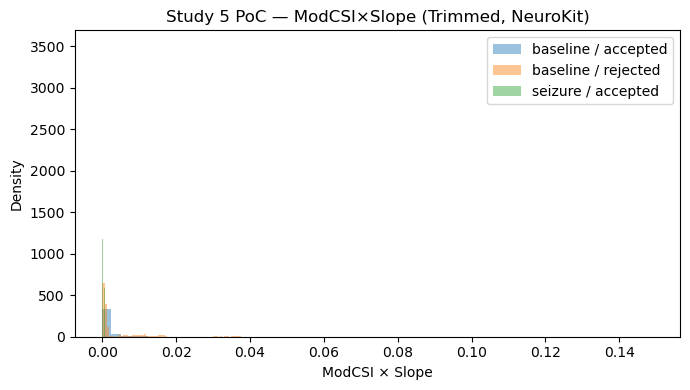

In [24]:
# ============================
# STUDY 5 — SINGLE-CELL POC
# ============================

import re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# ----------------------------
# A) Build windows_df (Study 4)
# ----------------------------
def add_is_acceptable(df):
    out = df.copy()
    for c in ["is_flatline","is_noiseburst","is_clipping"]:
        out[c] = out[c].astype(bool)
    out["is_acceptable"] = ~(out["is_flatline"] | out["is_noiseburst"] | out["is_clipping"])
    return out

def build_windows_df_for_study5(df_rec, df_seiz, df_winq):
    df = (
        df_winq
        .merge(df_rec, on=["recording_uid","patient_id","recording_id"], how="left")
        .merge(df_seiz, on=["recording_uid","patient_id","recording_id"], how="left",
               suffixes=("", "_seiz"))
    )
    df = add_is_acceptable(df)

    # seizure overlap in SECONDS on recording axis
    df["window_overlaps_seizure"] = (
        (df["win_end_s"] > df["t0_clinical"]) &
        (df["win_start_s"] < df["t1_clinical"])
    ).fillna(False)

    # unique windows only
    df = df.drop_duplicates(subset=["recording_uid","window_idx"]).copy()
    return df[[
        "recording_uid","window_idx","win_start_s","win_end_s",
        "is_acceptable","window_overlaps_seizure"
    ]]

windows_df = build_windows_df_for_study5(df_rec, df_seiz, df_winq)

# ----------------------------
# B) RR helpers (Jeppesen)
# ----------------------------
def parse_rr_filename(p: Path):
    m = re.match(
        r"P(?P<patient>\d+)(?P<enroll>[A-Za-z]?)_R(?P<rec>\d+)_"
        r"(?P<algo>neurokit|pantompkins1985|hamilton2002|elgendi2010)_rr_aligned",
        p.stem
    )
    if not m:
        raise ValueError(f"Cannot parse filename: {p.name}")
    return {
        "patient_id": int(m.group("patient")),
        "enrollment_id": (m.group("enroll") or None),
        "recording_id": int(m.group("rec")),
        "algo_id": m.group("algo"),
    }

def lookup_recording_uid(meta, df_index):
    rows = df_index[
        (df_index.patient_id == meta["patient_id"]) &
        (df_index.recording_id == meta["recording_id"]) &
        (
            (df_index.enrollment_id.isna() & (meta["enrollment_id"] is None)) |
            (df_index.enrollment_id == meta["enrollment_id"])
        )
    ]
    if len(rows) != 1:
        raise ValueError("UID lookup failed")
    return int(rows.iloc[0].recording_uid)

def clean_rr(rr, min_s=0.25, max_s=2.5):
    rr = pd.to_numeric(rr, errors="coerce").to_numpy()
    rr = rr[np.isfinite(rr)]
    return rr[(rr >= min_s) & (rr <= max_s)]

def median_prefilter_7(rr):
    out = np.empty_like(rr)
    for i in range(len(rr)):
        out[i] = np.median(rr[max(0, i-6):i+1])
    return out

def poincare_sd1_sd2(rr):
    if len(rr) < 3:
        return np.nan, np.nan
    x1, x2 = rr[:-1], rr[1:]
    sd1 = np.std((x2 - x1) / np.sqrt(2), ddof=1)
    sd2 = np.std((x2 + x1) / np.sqrt(2), ddof=1)
    return sd1, sd2

def slope_ls(t, rr):
    if len(rr) < 3:
        return np.nan
    t0 = t - t.mean()
    y0 = rr - rr.mean()
    denom = np.sum(t0**2)
    return abs(np.sum(t0*y0)/denom) if denom > 0 else np.nan

def compute_features(rr, t_end, win=100):
    rows=[]
    for k in range(win-1, len(rr)):
        r = rr[k-win+1:k+1]
        t = t_end[k-win+1:k+1]
        sd1, sd2 = poincare_sd1_sd2(r)
        T, L = 4*sd1, 4*sd2
        csi = L/T if (np.isfinite(L) and np.isfinite(T) and T>0) else np.nan
        modcsi = (L**2)/T if (np.isfinite(L) and np.isfinite(T) and T>0) else np.nan
        sl = slope_ls(t, r)
        rows.append({
            "t_s": float(t_end[k]),
            "CSI": csi,
            "ModCSI": modcsi,
            "Slope": sl,
            "ModCSI_x_Slope": (modcsi*sl if np.isfinite(modcsi) and np.isfinite(sl) else np.nan),
        })
    return pd.DataFrame(rows)

# ----------------------------
# C) Load ONE RR file (PoC)
# ----------------------------
RR_FILE = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim\P01_R01_neurokit_rr_aligned.csv")

meta = parse_rr_filename(RR_FILE)
recording_uid = lookup_recording_uid(meta, df_rec)

df_rr = pd.read_csv(RR_FILE)
rr = clean_rr(df_rr["RR_python_s"])
t_end = np.cumsum(rr)
rr_f = median_prefilter_7(rr)

df_feat = compute_features(rr_f, t_end, win=100)
df_feat["recording_uid"] = recording_uid
df_feat["algo_id"] = meta["algo_id"]

# ----------------------------
# D) Map features -> SQI window + seizure
# ----------------------------
w = windows_df.sort_values(["recording_uid","win_start_s"])
f = df_feat.sort_values(["recording_uid","t_s"])

mapped = map_features_to_windows(df_feat, windows_df)

mapped["group"] = np.where(mapped["window_overlaps_seizure"], "seizure", "baseline")
mapped["q"] = np.where(mapped["is_acceptable"], "accepted", "rejected")


display(mapped.head())

# ----------------------------
# E) FIRST FIGURE: ModCSI×Slope
# ----------------------------
plt.figure(figsize=(7,4))
for (grp, q), g in mapped.groupby(["group","q"]):
    plt.hist(
        g["ModCSI_x_Slope"].dropna(),
        bins=60, alpha=0.45, density=True,
        label=f"{grp} / {q}"
    )
plt.xlabel("ModCSI × Slope")
plt.ylabel("Density")
plt.title("Study 5 PoC — ModCSI×Slope (Trimmed, NeuroKit)")
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
from __future__ import annotations

import re
from pathlib import Path
import numpy as np
import pandas as pd


# ----------------------------
# Parsing + UID lookup
# ----------------------------
def parse_rr_filename(p: Path) -> dict:
    """
    Parse filenames like:
    P01_R01_neurokit_rr_aligned.csv
    P02_R01_emrich2023_rr_aligned.csv

    Algorithm name is parsed generically and filtered later.
    """
    m = re.match(
        r"P(?P<patient>\d+)(?P<enroll>[A-Za-z]?)_R(?P<rec>\d+)_"
        r"(?P<algo>[A-Za-z0-9]+)_rr_aligned",
        p.stem
    )
    if not m:
        raise ValueError(f"Cannot parse filename: {p.name}")

    return {
        "patient_id": int(m.group("patient")),
        "enrollment_id": (m.group("enroll") or None),
        "recording_id": int(m.group("rec")),
        "algo_id": m.group("algo").lower(),
    }


def lookup_recording_uid(meta: dict, df_index: pd.DataFrame) -> int:
    rows = df_index[
        (df_index["patient_id"] == meta["patient_id"]) &
        (df_index["recording_id"] == meta["recording_id"]) &
        (
            (df_index["enrollment_id"].isna() & (meta["enrollment_id"] is None)) |
            (df_index["enrollment_id"] == meta["enrollment_id"])
        )
    ]
    if len(rows) != 1:
        raise ValueError(f"UID lookup failed for meta={meta}, n={len(rows)}")
    return int(rows.iloc[0]["recording_uid"])


# ----------------------------
# RR cleaning + Jeppesen prefilter
# ----------------------------
def clean_rr(rr, min_s=0.25, max_s=2.5) -> np.ndarray:
    rr = pd.to_numeric(rr, errors="coerce").to_numpy()
    rr = rr[np.isfinite(rr)]
    rr = rr[(rr >= min_s) & (rr <= max_s)]
    return rr

def median_prefilter_7(rr: np.ndarray) -> np.ndarray:
    out = np.empty_like(rr)
    for i in range(len(rr)):
        out[i] = np.median(rr[max(0, i-6):i+1])
    return out

def poincare_sd1_sd2(rr: np.ndarray) -> tuple[float, float]:
    if len(rr) < 3:
        return np.nan, np.nan
    x1, x2 = rr[:-1], rr[1:]
    sd1 = np.std((x2 - x1) / np.sqrt(2), ddof=1)
    sd2 = np.std((x2 + x1) / np.sqrt(2), ddof=1)
    return sd1, sd2

def slope_ls(t: np.ndarray, rr: np.ndarray) -> float:
    if len(rr) < 3:
        return np.nan
    t0 = t - t.mean()
    y0 = rr - rr.mean()
    denom = np.sum(t0**2)
    return abs(np.sum(t0*y0)/denom) if denom > 0 else np.nan

def compute_features_from_rr(rr_s: np.ndarray, *, win_rr: int, prefilter: bool = True) -> pd.DataFrame:
    rr = rr_s.astype(float)
    if prefilter:
        rr = median_prefilter_7(rr)

    t_end = np.cumsum(rr)  # feature time axis (seconds since start)

    rows = []
    for k in range(win_rr - 1, len(rr)):
        r = rr[k-win_rr+1:k+1]
        t = t_end[k-win_rr+1:k+1]
        sd1, sd2 = poincare_sd1_sd2(r)
        T, L = 4*sd1, 4*sd2
        csi = L/T if (np.isfinite(L) and np.isfinite(T) and T > 0) else np.nan
        modcsi = (L**2)/T if (np.isfinite(L) and np.isfinite(T) and T > 0) else np.nan
        sl = slope_ls(t, r)
        rows.append({
            "k_end": int(k),
            "t_s": float(t_end[k]),
            "SD1": sd1, "SD2": sd2,
            "T": T, "L": L,
            "CSI": csi,
            "ModCSI": modcsi,
            "Slope": sl,
            "ModCSI_x_Slope": (modcsi*sl if np.isfinite(modcsi) and np.isfinite(sl) else np.nan),
        })
    return pd.DataFrame(rows)


# ----------------------------
# Feature -> windows mapping (robust per recording)
# ----------------------------
def map_features_to_windows(df_feat: pd.DataFrame, windows_df: pd.DataFrame) -> pd.DataFrame:
    out = []
    for rid, f in df_feat.groupby("recording_uid", sort=False):
        w = windows_df[windows_df["recording_uid"] == rid]
        if w.empty:
            continue

        f = f.sort_values("t_s").reset_index(drop=True)
        w = w.sort_values("win_start_s").reset_index(drop=True)

        m = pd.merge_asof(
            f,
            w[["win_start_s","win_end_s","is_acceptable","window_overlaps_seizure"]],
            left_on="t_s",
            right_on="win_start_s",
            direction="backward",
            allow_exact_matches=True,
        )

        m = m[m["t_s"] < m["win_end_s"]].copy()
        m["recording_uid"] = rid
        out.append(m)

    if not out:
        return pd.DataFrame()
    return pd.concat(out, ignore_index=True)


# ----------------------------
# MAIN: run Study 5
# ----------------------------
def run_study5(
    *,
    raw_dir: Path,
    trim_dir: Path,
    df_rec_index: pd.DataFrame,
    windows_df: pd.DataFrame,
    out_dir: Path,
    prefilter: bool = True,
    win_rr_list=(50, 100),
) -> pd.DataFrame:
    out_dir.mkdir(parents=True, exist_ok=True)
    rows = []

    ALLOWED_ALGOS = {
        "neurokit",
        "pantompkins1985",
        "hamilton2002",
        "emrich2023",
    }


    for set_name, base in [("raw", raw_dir), ("trim", trim_dir)]:
        for p in base.glob("*.csv"):
            meta = parse_rr_filename(p)
            if meta["algo_id"] not in ALLOWED_ALGOS:
                continue  # skip experimental / legacy methods

            rid = lookup_recording_uid(meta, df_rec_index)

            df = pd.read_csv(p)
            if "RR_labview_s" not in df.columns or "RR_python_s" not in df.columns:
                continue

            for rr_source, col in [("labview", "RR_labview_s"), ("python", "RR_python_s")]:
                rr = clean_rr(df[col])
                if len(rr) < max(win_rr_list) + 20:
                    continue

                for win_rr in win_rr_list:
                    feat = compute_features_from_rr(rr, win_rr=win_rr, prefilter=prefilter)
                    feat["recording_uid"] = rid
                    feat["algo_id"] = meta["algo_id"]
                    feat["set"] = set_name
                    feat["rr_source"] = rr_source
                    feat["win_rr"] = int(win_rr)
                    feat["prefilter"] = bool(prefilter)

                    feat_m = map_features_to_windows(feat, windows_df)
                    if feat_m.empty:
                        continue

                    feat_m["group"] = np.where(feat_m["window_overlaps_seizure"], "seizure", "baseline")
                    feat_m["q"] = np.where(feat_m["is_acceptable"], "accepted", "rejected")
                    rows.append(feat_m)

    df_all = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
    df_all.to_parquet(out_dir / "study5_features.parquet", index=False)

    # quick summaries (optional, but handy)
    if not df_all.empty:
        df_all.groupby(["set","rr_source","algo_id","win_rr","group","q"]).size().to_csv(
            out_dir / "study5_counts_by_group.csv"
        )

    return df_all


In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_modcsi_slope_distribution(df_all: pd.DataFrame, *, out_path: Path | None = None):
    d = df_all.copy()
    d = d[np.isfinite(d["ModCSI_x_Slope"])].copy()
    d = d[d["ModCSI_x_Slope"] > 0].copy()

    # Log-transform to handle heavy right tail
    d["log_modcsi_x_slope"] = np.log10(d["ModCSI_x_Slope"])

    plt.figure(figsize=(7.5, 4.5))
    for (group, q), g in d.groupby(["group","q"]):
        plt.hist(g["log_modcsi_x_slope"], bins=80, density=True, alpha=0.45, label=f"{group}/{q}")

    plt.xlabel("log10(ModCSI × Slope)")
    plt.ylabel("Density")
    plt.title("Study 5 — ModCSI×Slope distributions (seizure vs baseline, accepted vs rejected)")
    plt.legend()
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=200)
    plt.show()


In [40]:
def stability_summary(df_all: pd.DataFrame) -> pd.DataFrame:
    d = df_all[np.isfinite(df_all["ModCSI_x_Slope"])].copy()
    # robust metrics per stratum
    def qstats(x):
        return pd.Series({
            "n": len(x),
            "median": np.nanmedian(x),
            "p95": np.nanpercentile(x, 95),
            "p99": np.nanpercentile(x, 99),
        })

    return (
        d.groupby(["set","rr_source","algo_id","win_rr","group","q"])["ModCSI_x_Slope"]
        .apply(qstats)
        .reset_index()
    )

def plot_stability_p99(df_stab: pd.DataFrame, *, out_path: Path | None = None):
    # Plot p99 accepted vs rejected for baseline (or seizure)
    base = df_stab[df_stab["group"] == "baseline"].copy()

    plt.figure(figsize=(8, 4.5))
    for algo, g in base.groupby("algo_id"):
        gg = g[g["q"].isin(["accepted","rejected"])]
        # a simple dot plot on x = accepted/rejected
        for q in ["accepted","rejected"]:
            v = gg.loc[gg["q"] == q, "p99"].values
            if len(v):
                plt.scatter([f"{algo}\n{q}"] * len(v), v)

    plt.xticks(rotation=45, ha="right")
    plt.ylabel("P99(ModCSI × Slope)")
    plt.title("Study 5 — Outlier level (P99) before/after SQI (baseline)")
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=200)
    plt.show()


In [41]:
def feature_retention_table(df_all: pd.DataFrame) -> pd.DataFrame:
    d = df_all.copy()
    g = d.groupby(["set","rr_source","algo_id","win_rr","group"], as_index=False).agg(
        n_total=("ModCSI_x_Slope","size"),
        n_accepted=("is_acceptable", lambda s: int(np.sum(s.astype(bool)))),
    )
    g["frac_accepted"] = g["n_accepted"] / g["n_total"]
    return g


In [ ]:
RAW_DIR  = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Raw")
TRIM_DIR = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim")
OUT_DIR  = Path(r"E:\Speciale - Results\study5_out")

df_all = run_study5(
    raw_dir=RAW_DIR,
    trim_dir=TRIM_DIR,
    df_rec_index=df_rec,     # recordings_index.csv loaded
    windows_df=windows_df,   # built from Study 4
    out_dir=OUT_DIR,
    prefilter=True,
    win_rr_list=(100,),
)

plot_modcsi_slope_distribution(df_all, out_path=OUT_DIR / "fig_modcsi_slope_dist.png")
df_stab = stability_summary(df_all)
plot_stability_p99(df_stab, out_path=OUT_DIR / "fig_stability_p99.png")

ret_tbl = feature_retention_table(df_all)
ret_tbl.to_csv(OUT_DIR / "table_feature_retention.csv", index=False)


KeyboardInterrupt: 

Pilot recording_uids: [0, 1, 2, 3, 4]
Pilot files (n): 10
Pilot done. Rows=2,326,414. Time=1.47 min.
Approx per-recording (pilot): 17.7 s/recording


,rr_source,algo_id,group,n_total,n_accepted,frac_accepted
0,labview,neurokit,baseline,873369,872690,0.999223
1,labview,neurokit,seizure,490,490,1.000000
2,labview,pantompkins1985,baseline,289164,288888,0.999046
3,labview,pantompkins1985,seizure,264,264,1.000000
4,python,neurokit,baseline,873211,872553,0.999246
5,python,neurokit,seizure,490,490,1.000000
6,python,pantompkins1985,baseline,289162,288888,0.999052
7,python,pantompkins1985,seizure,264,264,1.000000


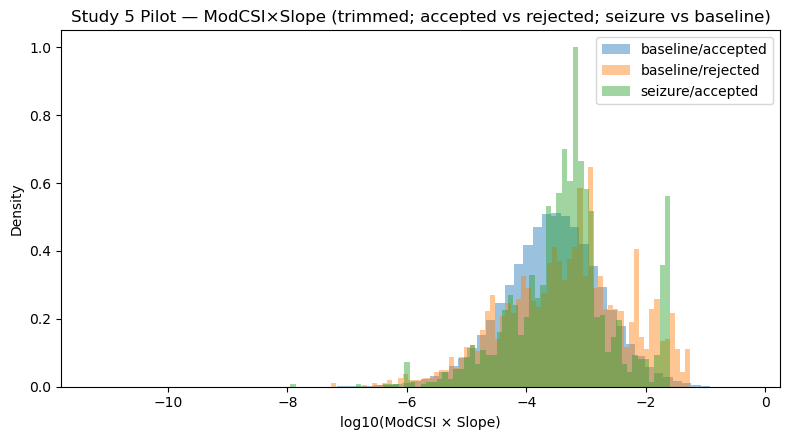

KeyError: 'p99'

<Figure size 900x450 with 0 Axes>

In [ ]:
from __future__ import annotations

import time
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# SETTINGS (edit these)
# ----------------------------
TRIM_DIR = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim")
OUT_DIR  = Path(r"E:\Speciale - Results\study5_pilot_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

ALLOWED_ALGOS = {"neurokit", "pantompkins1985"}
WIN_RR_LIST   = (100,)         # pilot: only 100 RR
PREFILTER     = True
MAX_RECORDINGS = 5             # pilot size


# ----------------------------
# REQUIRED INPUTS (must exist in notebook)
# df_rec: recordings_index.csv
# windows_df: built from Study4 (unique windows with is_acceptable and window_overlaps_seizure)
# ----------------------------

# ----------------------------
# Helpers: parse + uid lookup
# ----------------------------
def parse_rr_filename(p: Path) -> dict:
    m = re.match(
        r"P(?P<patient>\d+)(?P<enroll>[A-Za-z]?)_R(?P<rec>\d+)_"
        r"(?P<algo>[A-Za-z0-9]+)_rr_aligned",
        p.stem
    )
    if not m:
        raise ValueError(f"Cannot parse filename: {p.name}")
    return {
        "patient_id": int(m.group("patient")),
        "enrollment_id": (m.group("enroll") or None),
        "recording_id": int(m.group("rec")),
        "algo_id": m.group("algo").lower(),
    }

def lookup_recording_uid(meta: dict, df_index: pd.DataFrame) -> int:
    rows = df_index[
        (df_index["patient_id"] == meta["patient_id"]) &
        (df_index["recording_id"] == meta["recording_id"]) &
        (
            (df_index["enrollment_id"].isna() & (meta["enrollment_id"] is None)) |
            (df_index["enrollment_id"] == meta["enrollment_id"])
        )
    ]
    if len(rows) != 1:
        raise ValueError(f"UID lookup failed for meta={meta}, n={len(rows)}")
    return int(rows.iloc[0]["recording_uid"])


# ----------------------------
# RR + features (Jeppesen style)
# ----------------------------
def clean_rr(rr, min_s=0.25, max_s=2.5) -> np.ndarray:
    rr = pd.to_numeric(rr, errors="coerce").to_numpy()
    rr = rr[np.isfinite(rr)]
    rr = rr[(rr >= min_s) & (rr <= max_s)]
    return rr

def median_prefilter_7(rr: np.ndarray) -> np.ndarray:
    out = np.empty_like(rr)
    for i in range(len(rr)):
        out[i] = np.median(rr[max(0, i-6):i+1])
    return out

def poincare_sd1_sd2(rr: np.ndarray) -> tuple[float, float]:
    if len(rr) < 3:
        return np.nan, np.nan
    x1, x2 = rr[:-1], rr[1:]
    sd1 = np.std((x2 - x1) / np.sqrt(2), ddof=1)
    sd2 = np.std((x2 + x1) / np.sqrt(2), ddof=1)
    return sd1, sd2

def slope_ls(t: np.ndarray, rr: np.ndarray) -> float:
    if len(rr) < 3:
        return np.nan
    t0 = t - t.mean()
    y0 = rr - rr.mean()
    denom = np.sum(t0**2)
    return abs(np.sum(t0*y0)/denom) if denom > 0 else np.nan

def compute_features_from_rr(rr_s: np.ndarray, *, win_rr: int, prefilter: bool = True) -> pd.DataFrame:
    rr = rr_s.astype(float)
    if prefilter:
        rr = median_prefilter_7(rr)
    t_end = np.cumsum(rr)

    rows = []
    for k in range(win_rr - 1, len(rr)):
        r = rr[k-win_rr+1:k+1]
        t = t_end[k-win_rr+1:k+1]
        sd1, sd2 = poincare_sd1_sd2(r)
        T, L = 4*sd1, 4*sd2
        modcsi = (L**2)/T if (np.isfinite(L) and np.isfinite(T) and T > 0) else np.nan
        sl = slope_ls(t, r)
        rows.append({
            "t_s": float(t_end[k]),
            "ModCSI": modcsi,
            "Slope": sl,
            "ModCSI_x_Slope": (modcsi*sl if np.isfinite(modcsi) and np.isfinite(sl) else np.nan),
        })
    return pd.DataFrame(rows)


# ----------------------------
# Robust mapping: per recording
# ----------------------------
def map_features_to_windows(df_feat: pd.DataFrame, windows_df: pd.DataFrame) -> pd.DataFrame:
    out = []
    for rid, f in df_feat.groupby("recording_uid", sort=False):
        w = windows_df[windows_df["recording_uid"] == rid]
        if w.empty:
            continue
        f = f.sort_values("t_s").reset_index(drop=True)
        w = w.sort_values("win_start_s").reset_index(drop=True)

        m = pd.merge_asof(
            f,
            w[["win_start_s","win_end_s","is_acceptable","window_overlaps_seizure"]],
            left_on="t_s",
            right_on="win_start_s",
            direction="backward",
            allow_exact_matches=True,
        )
        m = m[m["t_s"] < m["win_end_s"]].copy()
        m["recording_uid"] = rid
        out.append(m)

    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()


# ----------------------------
# Pilot selection: choose first N unique recordings from available files
# ----------------------------
files = sorted(TRIM_DIR.glob("*.csv"))
pilot_files = []
pilot_rids = []

for p in files:
    meta = parse_rr_filename(p)
    if meta["algo_id"] not in ALLOWED_ALGOS:
        continue
    rid = lookup_recording_uid(meta, df_rec)
    if rid not in pilot_rids:
        pilot_rids.append(rid)
    pilot_files.append(p)
    if len(pilot_rids) >= MAX_RECORDINGS and len(pilot_files) >= (MAX_RECORDINGS * len(ALLOWED_ALGOS)):
        # rough stop once we likely have both algos for each selected recording
        break

print("Pilot recording_uids:", pilot_rids)
print("Pilot files (n):", len(pilot_files))


# ----------------------------
# Run pilot
# ----------------------------
t0 = time.time()
rows = []

for p in pilot_files:
    meta = parse_rr_filename(p)
    if meta["algo_id"] not in ALLOWED_ALGOS:
        continue
    rid = lookup_recording_uid(meta, df_rec)

    df = pd.read_csv(p)
    if not {"RR_labview_s","RR_python_s"}.issubset(df.columns):
        continue

    for rr_source, col in [("labview","RR_labview_s"), ("python","RR_python_s")]:
        rr = clean_rr(df[col])
        if len(rr) < max(WIN_RR_LIST) + 20:
            continue

        for win_rr in WIN_RR_LIST:
            feat = compute_features_from_rr(rr, win_rr=win_rr, prefilter=PREFILTER)
            feat["recording_uid"] = rid
            feat["algo_id"] = meta["algo_id"]
            feat["set"] = "trim"
            feat["rr_source"] = rr_source
            feat["win_rr"] = int(win_rr)
            feat["prefilter"] = bool(PREFILTER)

            feat_m = map_features_to_windows(feat, windows_df)
            if feat_m.empty:
                continue

            feat_m["group"] = np.where(feat_m["window_overlaps_seizure"], "seizure", "baseline")
            feat_m["q"] = np.where(feat_m["is_acceptable"], "accepted", "rejected")
            rows.append(feat_m)

df_pilot = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
dt = time.time() - t0

print(f"Pilot done. Rows={len(df_pilot):,}. Time={dt/60:.2f} min.")
if len(pilot_rids):
    print(f"Approx per-recording (pilot): {dt/len(pilot_rids):.1f} s/recording")

df_pilot.to_parquet(OUT_DIR / "study5_pilot_features.parquet", index=False)


# ----------------------------
# Table: feature retention
# ----------------------------
if not df_pilot.empty:
    ret = (
        df_pilot.groupby(["rr_source","algo_id","group"], as_index=False)
        .agg(
            n_total=("ModCSI_x_Slope","size"),
            n_accepted=("is_acceptable", lambda s: int(np.sum(s.astype(bool)))),
        )
    )
    ret["frac_accepted"] = ret["n_accepted"] / ret["n_total"]
    ret.to_csv(OUT_DIR / "pilot_retention_table.csv", index=False)
    display(ret)


# ----------------------------
# Figure 1: distribution (log10) ModCSI×Slope
# ----------------------------
if not df_pilot.empty:
    d = df_pilot[np.isfinite(df_pilot["ModCSI_x_Slope"])].copy()
    d = d[d["ModCSI_x_Slope"] > 0].copy()
    d["log_modcsi_x_slope"] = np.log10(d["ModCSI_x_Slope"])

    plt.figure(figsize=(8,4.5))
    for (grp, q), g in d.groupby(["group","q"]):
        plt.hist(g["log_modcsi_x_slope"], bins=70, density=True, alpha=0.45, label=f"{grp}/{q}")
    plt.xlabel("log10(ModCSI × Slope)")
    plt.ylabel("Density")
    plt.title("Study 5 Pilot — ModCSI×Slope (trimmed; accepted vs rejected; seizure vs baseline)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_DIR / "fig_pilot_dist_log10.png", dpi=200)
    plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def p99(x):
    x = pd.to_numeric(x, errors="coerce")
    x = x[np.isfinite(x)]
    return np.nan if len(x) == 0 else np.nanpercentile(x, 99)

stab = (
    df_pilot
    .groupby(["rr_source","algo_id","group","q"], as_index=False)
    .agg(
        n=("ModCSI_x_Slope", "size"),
        p99=("ModCSI_x_Slope", p99),
        p95=("ModCSI_x_Slope", lambda s: np.nanpercentile(pd.to_numeric(s, errors="coerce")[np.isfinite(pd.to_numeric(s, errors="coerce"))], 95)
            if np.isfinite(pd.to_numeric(s, errors="coerce")).any() else np.nan),
    )
)

# baseline plot (clean)
base = stab[stab["group"] == "baseline"].copy()

plt.figure(figsize=(9,4.5))
xlabels, xs, ys = [], [], []

for (rrs, algo) in sorted(base.groupby(["rr_source","algo_id"]).groups.keys()):
    for q in ["accepted","rejected"]:
        sub = base[(base["rr_source"]==rrs) & (base["algo_id"]==algo) & (base["q"]==q)]
        if sub.empty:
            continue
        xs.append(len(xs))
        ys.append(float(sub["p99"].iloc[0]))
        xlabels.append(f"{rrs}\n{algo}\n{q}")

plt.scatter(xs, ys)
plt.xticks(xs, xlabels, rotation=45, ha="right")
plt.ylabel("P99(ModCSI × Slope)")
plt.title("Study 5 Pilot — Outlier level (P99) before/after SQI (baseline)")
plt.tight_layout()
plt.savefig(OUT_DIR / "fig_pilot_p99.png", dpi=200)
plt.show()

stab.to_csv(OUT_DIR / "pilot_stability_stats.csv", index=False)
display(stab.head(20))


# ----------------------------
# Figure 2: Outlier reduction (P99) accepted vs rejected
# ----------------------------
if not df_pilot.empty:
    def qstats(x):
        x = x.to_numpy()
        x = x[np.isfinite(x)]
        if len(x) == 0:
            return pd.Series({"n":0, "p99":np.nan})
        return pd.Series({"n":len(x), "p99":np.nanpercentile(x, 99)})

    stab = (
        df_pilot.groupby(["rr_source","algo_id","group","q"])["ModCSI_x_Slope"]
        .apply(qstats)
        .reset_index()
    )

    # Plot baseline only (cleaner). You can switch to seizure if you want.
    base = stab[stab["group"]=="baseline"].copy()

    plt.figure(figsize=(9,4.5))
    xlabels = []
    xs = []
    ys = []
    for i, (rrs, algo) in enumerate(sorted(base.groupby(["rr_source","algo_id"]).groups.keys())):
        for q in ["accepted","rejected"]:
            sub = base[(base["rr_source"]==rrs) & (base["algo_id"]==algo) & (base["q"]==q)]
            if sub.empty:
                continue
            xs.append(len(xs))
            ys.append(float(sub["p99"].iloc[0]))
            xlabels.append(f"{rrs}\n{algo}\n{q}")

    plt.scatter(xs, ys)
    plt.xticks(xs, xlabels, rotation=45, ha="right")
    plt.ylabel("P99(ModCSI × Slope)")
    plt.title("Study 5 Pilot — Outlier level (P99) before/after SQI (baseline)")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "fig_pilot_p99.png", dpi=200)
    plt.show()

    stab.to_csv(OUT_DIR / "pilot_stability_stats.csv", index=False)
    display(stab)


In [44]:
from __future__ import annotations

import time
import re
from pathlib import Path
import numpy as np
import pandas as pd


# ----------------------------
# SETTINGS
# ----------------------------
TRIM_DIR = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim")
OUT_DIR  = Path(r"E:\Speciale - Results\study5_out_trim_100rr")
OUT_DIR.mkdir(parents=True, exist_ok=True)

ALLOWED_ALGOS = {"neurokit", "pantompkins1985", "hamilton2002", "elgendi2010"}
WIN_RR = 100
PREFILTER = True

# REQUIRED INPUTS in notebook:
# df_rec (recordings_index.csv)
# windows_df (from Study4; unique windows with is_acceptable + window_overlaps_seizure)


# ----------------------------
# Helpers
# ----------------------------
def parse_rr_filename(p: Path) -> dict:
    m = re.match(
        r"P(?P<patient>\d+)(?P<enroll>[A-Za-z]?)_R(?P<rec>\d+)_"
        r"(?P<algo>[A-Za-z0-9]+)_rr_aligned",
        p.stem
    )
    if not m:
        return None
    return {
        "patient_id": int(m.group("patient")),
        "enrollment_id": (m.group("enroll") or None),
        "recording_id": int(m.group("rec")),
        "algo_id": m.group("algo").lower(),
    }

def lookup_recording_uid(meta: dict, df_index: pd.DataFrame) -> int:
    rows = df_index[
        (df_index["patient_id"] == meta["patient_id"]) &
        (df_index["recording_id"] == meta["recording_id"]) &
        (
            (df_index["enrollment_id"].isna() & (meta["enrollment_id"] is None)) |
            (df_index["enrollment_id"] == meta["enrollment_id"])
        )
    ]
    if len(rows) != 1:
        raise ValueError(f"UID lookup failed for meta={meta}, n={len(rows)}")
    return int(rows.iloc[0]["recording_uid"])

def clean_rr(rr, min_s=0.25, max_s=2.5) -> np.ndarray:
    rr = pd.to_numeric(rr, errors="coerce").to_numpy()
    rr = rr[np.isfinite(rr)]
    rr = rr[(rr >= min_s) & (rr <= max_s)]
    return rr

def median_prefilter_7(rr: np.ndarray) -> np.ndarray:
    out = np.empty_like(rr)
    for i in range(len(rr)):
        out[i] = np.median(rr[max(0, i-6):i+1])
    return out

def poincare_sd1_sd2(rr: np.ndarray) -> tuple[float, float]:
    if len(rr) < 3:
        return np.nan, np.nan
    x1, x2 = rr[:-1], rr[1:]
    sd1 = np.std((x2 - x1) / np.sqrt(2), ddof=1)
    sd2 = np.std((x2 + x1) / np.sqrt(2), ddof=1)
    return sd1, sd2

def slope_ls(t: np.ndarray, rr: np.ndarray) -> float:
    if len(rr) < 3:
        return np.nan
    t0 = t - t.mean()
    y0 = rr - rr.mean()
    denom = np.sum(t0**2)
    return abs(np.sum(t0*y0)/denom) if denom > 0 else np.nan

def compute_features_from_rr(rr_s: np.ndarray, *, win_rr: int, prefilter: bool = True) -> pd.DataFrame:
    rr = rr_s.astype(float)
    if prefilter:
        rr = median_prefilter_7(rr)
    t_end = np.cumsum(rr)

    rows = []
    for k in range(win_rr - 1, len(rr)):
        r = rr[k-win_rr+1:k+1]
        t = t_end[k-win_rr+1:k+1]
        sd1, sd2 = poincare_sd1_sd2(r)
        T, L = 4*sd1, 4*sd2
        modcsi = (L**2)/T if (np.isfinite(L) and np.isfinite(T) and T > 0) else np.nan
        sl = slope_ls(t, r)
        rows.append({
            "t_s": float(t_end[k]),
            "ModCSI": modcsi,
            "Slope": sl,
            "ModCSI_x_Slope": (modcsi*sl if np.isfinite(modcsi) and np.isfinite(sl) else np.nan),
        })
    return pd.DataFrame(rows)

def map_features_to_windows_one_recording(feat: pd.DataFrame, w: pd.DataFrame) -> pd.DataFrame:
    # feat already only one recording
    feat = feat.sort_values("t_s").reset_index(drop=True)
    w = w.sort_values("win_start_s").reset_index(drop=True)

    m = pd.merge_asof(
        feat,
        w[["win_start_s","win_end_s","is_acceptable","window_overlaps_seizure"]],
        left_on="t_s",
        right_on="win_start_s",
        direction="backward",
        allow_exact_matches=True,
    )
    m = m[m["t_s"] < m["win_end_s"]].copy()
    return m


# ----------------------------
# RUN
# ----------------------------
files = sorted(TRIM_DIR.glob("*.csv"))
start = time.time()

chunks = []
n_used = 0
n_skipped = 0

# Pre-index windows per recording for speed
windows_by_rid = {rid: g.copy() for rid, g in windows_df.groupby("recording_uid", sort=False)}

for i, p in enumerate(files, start=1):
    meta = parse_rr_filename(p)
    if meta is None:
        n_skipped += 1
        continue
    if meta["algo_id"] not in ALLOWED_ALGOS:
        n_skipped += 1
        continue

    rid = lookup_recording_uid(meta, df_rec)
    w = windows_by_rid.get(rid, None)
    if w is None or w.empty:
        n_skipped += 1
        continue

    df = pd.read_csv(p)
    if not {"RR_labview_s","RR_python_s"}.issubset(df.columns):
        n_skipped += 1
        continue

    for rr_source, col in [("labview","RR_labview_s"), ("python","RR_python_s")]:
        rr = clean_rr(df[col])
        if len(rr) < WIN_RR + 20:
            continue

        feat = compute_features_from_rr(rr, win_rr=WIN_RR, prefilter=PREFILTER)
        if feat.empty:
            continue

        feat["recording_uid"] = rid
        feat["algo_id"] = meta["algo_id"]
        feat["set"] = "trim"
        feat["rr_source"] = rr_source
        feat["win_rr"] = WIN_RR
        feat["prefilter"] = PREFILTER

        mapped = map_features_to_windows_one_recording(feat, w)
        if mapped.empty:
            continue

        mapped["recording_uid"] = rid
        mapped["group"] = np.where(mapped["window_overlaps_seizure"], "seizure", "baseline")
        mapped["q"] = np.where(mapped["is_acceptable"], "accepted", "rejected")

        chunks.append(mapped)

    n_used += 1

    if i % 25 == 0:
        elapsed = time.time() - start
        print(f"[{i}/{len(files)}] used_files={n_used} skipped={n_skipped} elapsed={elapsed/60:.1f} min")

df_all = pd.concat(chunks, ignore_index=True) if chunks else pd.DataFrame()
elapsed = time.time() - start

print(f"\nDONE. rows={len(df_all):,}  used_files={n_used}  skipped={n_skipped}  time={elapsed/60:.1f} min")

out_parquet = OUT_DIR / "study5_trim_100rr_features.parquet"
df_all.to_parquet(out_parquet, index=False)
print("Saved:", out_parquet)

# Small summary tables for sanity + reporting
if not df_all.empty:
    count_tbl = df_all.groupby(["rr_source","algo_id","group","q"], as_index=False).size()
    count_tbl.to_csv(OUT_DIR / "counts_by_strata.csv", index=False)

    # retention-like (accepted fraction of feature points)
    ret_tbl = (
        df_all.groupby(["rr_source","algo_id","group"], as_index=False)
        .agg(n_total=("ModCSI_x_Slope","size"),
             frac_accepted=("is_acceptable", lambda s: float(np.mean(s.astype(bool)))))
    )
    ret_tbl.to_csv(OUT_DIR / "feature_acceptance_fraction.csv", index=False)

    print("\nSaved summaries: counts_by_strata.csv, feature_acceptance_fraction.csv")


[50/288] used_files=37 skipped=13 elapsed=6.1 min
[75/288] used_files=56 skipped=19 elapsed=10.1 min
[100/288] used_files=75 skipped=25 elapsed=12.0 min
[150/288] used_files=112 skipped=38 elapsed=16.9 min
[175/288] used_files=131 skipped=44 elapsed=20.4 min
[200/288] used_files=150 skipped=50 elapsed=22.5 min
[250/288] used_files=187 skipped=63 elapsed=28.4 min
[275/288] used_files=206 skipped=69 elapsed=31.1 min

DONE. rows=52,465,654  used_files=216  skipped=72  time=33.5 min
Saved: E:\Speciale - Results\study5_out_trim_100rr\study5_trim_100rr_features.parquet

Saved summaries: counts_by_strata.csv, feature_acceptance_fraction.csv


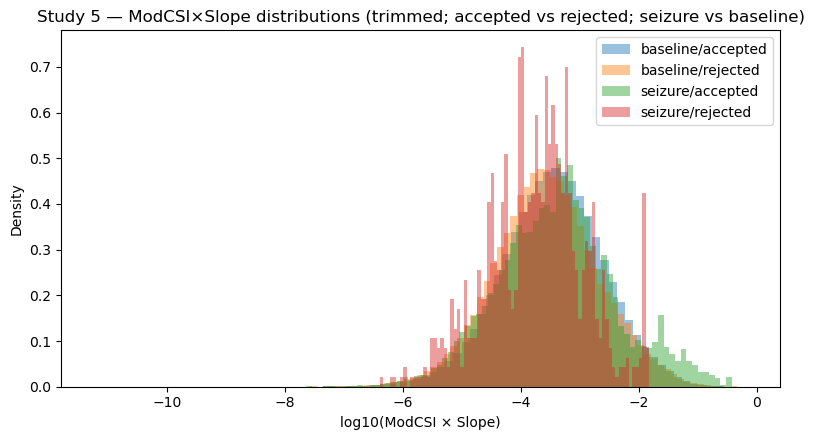

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

OUT_DIR = Path(r"E:\Speciale - Results\study5_out_trim_100rr")

df_all = pd.read_parquet(OUT_DIR / "study5_trim_100rr_features.parquet")
d = df_all[np.isfinite(df_all["ModCSI_x_Slope"])].copy()
d = d[d["ModCSI_x_Slope"] > 0].copy()
d["log_modcsi_x_slope"] = np.log10(d["ModCSI_x_Slope"])

plt.figure(figsize=(8,4.5))
for (grp, q), g in d.groupby(["group","q"]):
    plt.hist(g["log_modcsi_x_slope"], bins=80, density=True, alpha=0.45, label=f"{grp}/{q}")
plt.xlabel("log10(ModCSI × Slope)")
plt.ylabel("Density")
plt.title("Study 5 — ModCSI×Slope distributions (trimmed; accepted vs rejected; seizure vs baseline)")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "fig_dist_log10.png", dpi=220)
plt.show()


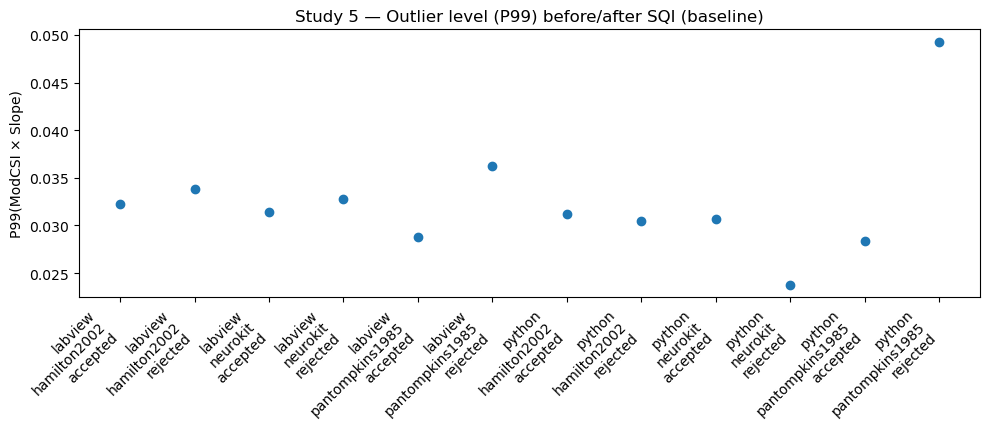

In [46]:
def p99(x):
    x = pd.to_numeric(x, errors="coerce")
    x = x[np.isfinite(x)]
    return np.nan if len(x) == 0 else np.nanpercentile(x, 99)

stab = (
    df_all
    .groupby(["rr_source","algo_id","group","q"], as_index=False)
    .agg(n=("ModCSI_x_Slope","size"), p99=("ModCSI_x_Slope", p99))
)

base = stab[stab["group"]=="baseline"].copy()

plt.figure(figsize=(10,4.5))
xlabels, xs, ys = [], [], []
for (rrs, algo) in sorted(base.groupby(["rr_source","algo_id"]).groups.keys()):
    for q in ["accepted","rejected"]:
        sub = base[(base["rr_source"]==rrs) & (base["algo_id"]==algo) & (base["q"]==q)]
        if sub.empty:
            continue
        xs.append(len(xs))
        ys.append(float(sub["p99"].iloc[0]))
        xlabels.append(f"{rrs}\n{algo}\n{q}")

plt.scatter(xs, ys)
plt.xticks(xs, xlabels, rotation=45, ha="right")
plt.ylabel("P99(ModCSI × Slope)")
plt.title("Study 5 — Outlier level (P99) before/after SQI (baseline)")
plt.tight_layout()
plt.savefig(OUT_DIR / "fig_p99_baseline.png", dpi=220)
plt.show()

stab.to_csv(OUT_DIR / "table_stability_p99.csv", index=False)


In [ ]:
import numpy as np
import pandas as pd

REFRACTORY_S = 60.0

def detect_events(times, values, threshold, refractory_s=60.0):
    """Return detection times with refractory period."""
    detections = []
    last_t = -np.inf
    for t, v in zip(times, values):
        if v >= threshold and (t - last_t) >= refractory_s:
            detections.append(t)
            last_t = t
    return np.array(detections)

def evaluate_recording(
    feat: pd.DataFrame,
    seiz: pd.DataFrame,
    *,
    use_sqi: bool
) -> dict:
    """
    Evaluate one recording.
    Returns counts: TP, FP, FN, duration_h
    """
    # Separate baseline / seizure
    if use_sqi:
        baseline = feat[(feat["group"]=="baseline") & (feat["is_acceptable"])]
        stream   = feat[feat["is_acceptable"]]
    else:
        baseline = feat[feat["group"]=="baseline"]
        stream   = feat

    # No baseline -> cannot compute threshold
    if baseline.empty or stream.empty:
        return dict(TP=0, FP=0, FN=len(seiz), duration_h=0.0)

    threshold = np.nanpercentile(baseline["ModCSI_x_Slope"], 95)

    det_times = detect_events(
        times=stream["t_s"].values,
        values=stream["ModCSI_x_Slope"].values,
        threshold=threshold,
        refractory_s=REFRACTORY_S,
    )

    # Match detections to seizures
    TP = 0
    matched = set()

    for _, s in seiz.iterrows():
        hits = det_times[(det_times >= s["t0_clinical"]) & (det_times <= s["t1_clinical"])]
        if len(hits):
            TP += 1
            matched.add(s["seizure_id"])

    FN = len(seiz) - TP

    # FP = detections not inside any seizure
    FP = 0
    for t in det_times:
        inside = ((t >= seiz["t0_clinical"]) & (t <= seiz["t1_clinical"])).any()
        if not inside:
            FP += 1

    duration_h = feat["t_s"].max() / 3600.0

    return dict(TP=TP, FP=FP, FN=FN, duration_h=duration_h)


In [48]:
from pathlib import Path

FEAT_PATH = Path(r"E:\Speciale - Results\study5_out_trim_100rr\study5_trim_100rr_features.parquet")
df_feat = pd.read_parquet(FEAT_PATH)

rows = []

for (rr_source, algo), g0 in df_feat.groupby(["rr_source","algo_id"], sort=False):
    for use_sqi in [False, True]:
        TP = FP = FN = 0
        duration_h = 0.0

        for rid, g in g0.groupby("recording_uid", sort=False):
            seiz = df_seiz[df_seiz["recording_uid"] == rid]
            if seiz.empty:
                continue

            res = evaluate_recording(
                feat=g,
                seiz=seiz,
                use_sqi=use_sqi
            )

            TP += res["TP"]
            FP += res["FP"]
            FN += res["FN"]
            duration_h += res["duration_h"]

        sens = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        prec = TP / (TP + FP) if (TP + FP) > 0 else np.nan
        f1   = (2*prec*sens)/(prec+sens) if prec and sens else np.nan
        far  = FP / duration_h if duration_h > 0 else np.nan

        rows.append(dict(
            rr_source=rr_source,
            algorithm=algo if rr_source=="python" else "LabVIEW",
            SQI="on" if use_sqi else "off",
            TP=TP, FP=FP, FN=FN,
            Sensitivity=sens,
            Precision=prec,
            F1=f1,
            FAR_per_h=far
        ))

df_main = pd.DataFrame(rows)
display(df_main)


,rr_source,algorithm,SQI,TP,FP,FN,Sensitivity,Precision,F1,FAR_per_h
0,labview,LabVIEW,off,13,9325,132,0.089655,0.001392,0.002742,6.456851
1,labview,LabVIEW,on,13,9315,132,0.089655,0.001394,0.002745,6.449927
2,python,hamilton2002,off,16,9295,129,0.110345,0.001718,0.003384,6.436929
3,python,hamilton2002,on,16,9272,129,0.110345,0.001723,0.003392,6.421001
4,labview,LabVIEW,off,15,16161,134,0.100671,0.000927,0.001838,6.481576
5,labview,LabVIEW,on,15,16126,134,0.100671,0.000929,0.001842,6.467538
6,python,neurokit,off,14,16242,135,0.093960,0.000861,0.001707,6.513140
7,python,neurokit,on,14,16199,135,0.093960,0.000864,0.001711,6.495897
8,labview,LabVIEW,off,7,5689,140,0.047619,0.001229,0.002396,6.555098
9,labview,LabVIEW,on,8,5678,139,0.054422,0.001407,0.002743,6.542423


In [49]:
df_main.to_csv(OUT_DIR / "study5_performance_summary.csv", index=False)

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

# -------------------------
# INPUTS
# -------------------------
FEAT_PATH = Path(r"E:\Speciale - Results\study5_out_trim_100rr\study5_trim_100rr_features.parquet")
THR_XLSX  = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Threshold values.xlsx")
# df_seiz skal være loaded i notebook (seizure_events.csv)

REFRACTORY_S = 60.0
WIN_RR = 100

# -------------------------
# Load features
# -------------------------
df_feat = pd.read_parquet(FEAT_PATH)

# Enforce trimmed + 100RR (bare for sikkerhed)
df_feat = df_feat[(df_feat["set"] == "trim") & (df_feat["win_rr"] == WIN_RR)].copy()

# --------- FIX: LabVIEW unique (one stream only) ----------
lab = df_feat[df_feat["rr_source"]=="labview"].copy()
lab = lab.drop_duplicates(subset=["recording_uid","t_s","rr_source","win_rr"])

pyt = df_feat[df_feat["rr_source"]=="python"].copy()
df_feat2 = pd.concat([lab, pyt], ignore_index=True)

# -------------------------
# Load Jeppesen thresholds
# -------------------------
# Hvis din xlsx ligger lokalt, så brug din lokale sti:
# thr_df = pd.read_excel(r"E:\...\Threshold values.xlsx")

thr_df = pd.read_excel(THR_XLSX)

thr_map_modcsi = (
    thr_df
    .set_index("Patient number")["Threshold ModCSI100_filt x slope"]
    .dropna()
    .to_dict()
)


# Her skal vi finde den relevante threshold.
# Jeg kender ikke dine kolonnenavne, så vi gør det robust:
print("Threshold sheet columns:", thr_df.columns.tolist())
display(thr_df.head())

# --------- VIGTIGT ---------
# Ret disse to linjer til så de passer til din xlsx:
THR_COL = "Threshold ModCSI100_filt x slope"   # <-- RET hvis nødvendigt
thr_value = float(thr_df[THR_COL].dropna().iloc[0])
print("Using ModCSI100_filt x slope threshold:", thr_value)

# -------------------------
# Detection + scoring
# -------------------------
def detect_times(t_s, x, thr, refractory_s=60.0):
    """Rising threshold detections with refractory."""
    det = []
    last = -np.inf
    for t, v in zip(t_s, x):
        if np.isfinite(v) and v >= thr and (t - last) >= refractory_s:
            det.append(float(t))
            last = float(t)
    return np.array(det, dtype=float)

def score_pipeline(
    feat: pd.DataFrame,
    seiz_all: pd.DataFrame,
    *,
    use_sqi: bool,
    thr_map_modcsi: dict,
    refractory_s: float = 60.0,
) -> dict:
    """
    Aggregate seizure coverage + FAR across all recordings
    using patient-specific Jeppesen thresholds.
    """

    n_seiz_total = 0
    n_seiz_with_points = 0
    n_seiz_detected = 0
    FP = 0
    total_h = 0.0

    # choose stream according to SQI
    if use_sqi:
        stream = feat[feat["is_acceptable"]].copy()
    else:
        stream = feat.copy()

    for rid, g in stream.groupby("recording_uid", sort=False):

        seiz = seiz_all[seiz_all["recording_uid"] == rid].copy()
        if seiz.empty or g.empty:
            continue

        g = g.sort_values("t_s")

        # FAR denominator (hours)
        total_h += g["t_s"].max() / 3600.0

        # patient-specific threshold
        pid = int(g["patient_id"].iloc[0])
        thr = thr_map_modcsi.get(pid, np.nan)

        if not np.isfinite(thr):
            # no threshold defined for this patient
            continue

        # ---------- DETECTIONS ----------
        det_t = detect_times(
            t_s=g["t_s"].values,
            x=g["ModCSI_x_Slope"].values,
            thr=thr,
            refractory_s=refractory_s,
        )

        # ---------- SEIZURE SCORING ----------
        for _, s in seiz.iterrows():
            n_seiz_total += 1
            t0 = float(s["t0_clinical"])
            t1 = float(s["t1_clinical"])

            # does this seizure have any feature points?
            has_pts = ((g["t_s"] >= t0) & (g["t_s"] <= t1)).any()
            if has_pts:
                n_seiz_with_points += 1

            # detected?
            if det_t.size and np.any((det_t >= t0) & (det_t <= t1)):
                n_seiz_detected += 1

        # ---------- FALSE POSITIVES ----------
        if det_t.size:
            inside_any = np.zeros(det_t.shape[0], dtype=bool)
            for _, s in seiz.iterrows():
                t0 = float(s["t0_clinical"])
                t1 = float(s["t1_clinical"])
                inside_any |= ((det_t >= t0) & (det_t <= t1))

            FP += int((~inside_any).sum())

    recall_total = n_seiz_detected / n_seiz_total if n_seiz_total else np.nan
    recall_eligible = (
        n_seiz_detected / n_seiz_with_points if n_seiz_with_points else np.nan
    )
    far = FP / total_h if total_h > 0 else np.nan

    return dict(
        n_seiz_total=n_seiz_total,
        n_seiz_with_points=n_seiz_with_points,
        n_seiz_detected=n_seiz_detected,
        recall_total=recall_total,
        recall_eligible=recall_eligible,
        FP=FP,
        FAR_per_h=far,
    )

# -------------------------
# Build final main table
# -------------------------
rows = []

# Sanity check
assert "recording_uid" in df_feat2.columns

# Build mapping recording_uid -> patient_id
uid_to_pid = (
    df_rec[["recording_uid", "patient_id"]]
    .drop_duplicates()
    .set_index("recording_uid")["patient_id"]
)

# Patient IDs set fra recordings_index
pids_rec = set(df_rec["patient_id"].dropna().astype(int).unique())

# Patient numbers set fra threshold-arket
pids_thr = set(thr_df["Patient number"].dropna().astype(int).unique())

print("n unique patient_id in recordings_index:", len(pids_rec))
print("n unique patient_id in thresholds:", len(pids_thr))
print("in recordings but not in thresholds:", sorted(pids_rec - pids_thr)[:20])
print("in thresholds but not in recordings:", sorted(pids_thr - pids_rec)[:20])

# Test om thresholds matcher patient_id+1 (klassisk 0-indekseringsfejl)
pids_rec_plus1 = set([p+1 for p in pids_rec])
pids_rec_minus1 = set([p-1 for p in pids_rec])

overlap_direct = len(pids_rec & pids_thr)
overlap_plus1  = len(pids_rec_plus1 & pids_thr)
overlap_minus1 = len(pids_rec_minus1 & pids_thr)

print("Overlap direct:", overlap_direct)
print("Overlap patient_id+1:", overlap_plus1)
print("Overlap patient_id-1:", overlap_minus1)



# Merge patient_id into feature dataframe
df_feat2["patient_id"] = df_feat2["recording_uid"].map(uid_to_pid)

# Sanity check
print("Missing patient_id:", df_feat2["patient_id"].isna().sum())
df_feat2["patient_id"] = df_feat2["patient_id"].astype(int)

df_feat2[["recording_uid", "patient_id"]].drop_duplicates().head()

# LabVIEW (single reference)
feat_lab = df_feat2[df_feat2["rr_source"] == "labview"].copy()

for use_sqi in [False, True]:
    res = score_pipeline(
        feat_lab,
        df_seiz,
        use_sqi=use_sqi,
        thr_map_modcsi=thr_map_modcsi,
        refractory_s=60.0,
    )

    rows.append({
        "RR_source": "LabVIEW",
        "Algorithm": "—",
        "SQI": "on" if use_sqi else "off",
        **res
    })


# Python (per algorithm)
feat_py = df_feat2[df_feat2["rr_source"] == "python"].copy()

for algo, g in feat_py.groupby("algo_id", sort=False):
    for use_sqi in [False, True]:
        res = score_pipeline(
            g,
            df_seiz,
            use_sqi=use_sqi,
            thr_map_modcsi=thr_map_modcsi,
            refractory_s=60.0,
        )

        rows.append({
            "RR_source": "Python",
            "Algorithm": algo,
            "SQI": "on" if use_sqi else "off",
            **res
        })


df_main = pd.DataFrame(rows)
df_main = df_main.sort_values(["RR_source","Algorithm","SQI"]).reset_index(drop=True)
display(df_main)

# Optional: save
OUT_TAB = Path(r"E:\Speciale - Results\study5_out_trim_100rr\table_main_jeppesen_threshold.csv")
df_main.to_csv(OUT_TAB, index=False)
print("Saved:", OUT_TAB)


Threshold sheet columns: ['Patient number', 'Unnamed: 1', 'Threshold ModCSI100_filt x slope', 'Unnamed: 3', 'Threshold CSI100 x slope']


,Patient number,Unnamed: 1,Threshold ModCSI100_filt x slope,Unnamed: 3,Threshold CSI100 x slope
0,1,NaN,16826.868000,NaN,16.384000
1,2,NaN,4991.459446,NaN,6.904475
2,3,NaN,10386.795000,NaN,13.768000
3,4,NaN,4174.910231,NaN,5.326577
4,5,NaN,6184.320000,NaN,8.660000


Using ModCSI100_filt x slope threshold: 16826.868
n unique patient_id in recordings_index: 43
n unique patient_id in thresholds: 43
in recordings but not in thresholds: []
in thresholds but not in recordings: []
Overlap direct: 43
Overlap patient_id+1: 42
Overlap patient_id-1: 42
Missing patient_id: 0


,RR_source,Algorithm,SQI,n_seiz_total,n_seiz_with_points,n_seiz_detected,recall_total,recall_eligible,FP,FAR_per_h
0,LabVIEW,—,off,149,114,0,0.0,0.0,0,0.0
1,LabVIEW,—,on,149,113,0,0.0,0.0,0,0.0
2,Python,hamilton2002,off,145,64,0,0.0,0.0,0,0.0
3,Python,hamilton2002,on,145,64,0,0.0,0.0,0,0.0
4,Python,neurokit,off,149,114,0,0.0,0.0,0,0.0
5,Python,neurokit,on,149,113,0,0.0,0.0,0,0.0
6,Python,pantompkins1985,off,147,43,0,0.0,0.0,0,0.0
7,Python,pantompkins1985,on,147,43,0,0.0,0.0,0,0.0


Saved: E:\Speciale - Results\study5_out_trim_100rr\table_main_jeppesen_threshold.csv


In [59]:
df_main[[
    "RR_source",
    "Algorithm",
    "SQI",
    "n_seiz_total",
    "n_seiz_with_points",
    "n_seiz_detected",
    "recall_total",
    "recall_eligible",
    "FAR_per_h",
]]


,RR_source,Algorithm,SQI,n_seiz_total,n_seiz_with_points,n_seiz_detected,recall_total,recall_eligible,FAR_per_h
0,LabVIEW,—,off,149,114,0,0.0,0.0,0.0
1,LabVIEW,—,on,149,113,0,0.0,0.0,0.0
2,Python,hamilton2002,off,145,64,0,0.0,0.0,0.0
3,Python,hamilton2002,on,145,64,0,0.0,0.0,0.0
4,Python,neurokit,off,149,114,0,0.0,0.0,0.0
5,Python,neurokit,on,149,113,0,0.0,0.0,0.0
6,Python,pantompkins1985,off,147,43,0,0.0,0.0,0.0
7,Python,pantompkins1985,on,147,43,0,0.0,0.0,0.0


In [61]:
import random
from pathlib import Path

TRIM_DIR = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim")
files = sorted(TRIM_DIR.glob("P*_R*_*.csv"))
sample = random.sample(files, 5)

for p in sample:
    meta = parse_rr_filename(p)  # din parse_rr_filename
    rid = lookup_recording_uid(meta, df_rec)  # din lookup_recording_uid
    pid_from_index = int(df_rec.loc[df_rec["recording_uid"]==rid, "patient_id"].iloc[0])
    print(p.name, " -> parsed patient:", meta["patient_id"], "| index patient_id:", pid_from_index, "| rid:", rid)


P34c_R01_pantompkins1985_rr_aligned.csv  -> parsed patient: 34 | index patient_id: 34 | rid: 58
P33_R01_hamilton2002_rr_aligned.csv  -> parsed patient: 33 | index patient_id: 33 | rid: 55
P10_R01_emrich2023_rr_aligned.csv  -> parsed patient: 10 | index patient_id: 10 | rid: 16
P27b_R01_hamilton2002_rr_aligned.csv  -> parsed patient: 27 | index patient_id: 27 | rid: 46
P13_R02_emrich2023_rr_aligned.csv  -> parsed patient: 13 | index patient_id: 13 | rid: 22


In [62]:
# Join patient thresholds onto features
thr_map_modcsi = (
    thr_df.set_index("Patient number")["Threshold ModCSI100_filt x slope"].dropna().to_dict()
)

df_feat2["thr_modcsi"] = df_feat2["patient_id"].map(thr_map_modcsi)

# Sanity
print("Missing thr:", df_feat2["thr_modcsi"].isna().sum())

# How often does ModCSI_x_Slope exceed the threshold?
exceed = (df_feat2["ModCSI_x_Slope"] >= df_feat2["thr_modcsi"])
print("Fraction points exceeding patient threshold:", float(exceed.mean()))

# Quick quantiles
print("ModCSI_x_Slope quantiles:", df_feat2["ModCSI_x_Slope"].quantile([0.5,0.9,0.99,0.999]).to_dict())
print("Threshold quantiles:", df_feat2["thr_modcsi"].quantile([0.5,0.9,0.99]).to_dict())


Missing thr: 0
Fraction points exceeding patient threshold: 0.0
ModCSI_x_Slope quantiles: {0.5: 0.0003576801011815802, 0.9: 0.0042026553043351825, 0.99: 0.03087707278765159, 0.999: 0.09464055272676022}
Threshold quantiles: {0.5: 16206.458, 0.9: 31203.081, 0.99: 70775.492}


In [63]:
# Pick one recording with seizures
rid = int(df_seiz["recording_uid"].iloc[0])
g = df_feat2[df_feat2["recording_uid"]==rid].copy()
s = df_seiz[df_seiz["recording_uid"]==rid].copy()

print("RID:", rid, "patient:", int(s["patient_id"].iloc[0]), "n_seiz:", len(s))
print("Feature t_s range:", float(g["t_s"].min()), "->", float(g["t_s"].max()))
print("Seizure t0/t1 range:", float(s["t0_clinical"].min()), "->", float(s["t1_clinical"].max()))

# Do we have ANY feature points inside seizure intervals?
inside_any = False
for _, row in s.iterrows():
    t0, t1 = float(row["t0_clinical"]), float(row["t1_clinical"])
    if ((g["t_s"] >= t0) & (g["t_s"] <= t1)).any():
        inside_any = True
        break
print("Has any feature points inside any seizure interval?", inside_any)


RID: 0 patient: 1 n_seiz: 1
Feature t_s range: 86.7734375 -> 190404.86256289482
Seizure t0/t1 range: 130187.0 -> 130228.0
Has any feature points inside any seizure interval? True


In [64]:
rid = int(df_seiz["recording_uid"].iloc[0])
g = df_feat2[(df_feat2["recording_uid"]==rid) & (df_feat2["rr_source"]=="python")].copy()
pid = int(g["patient_id"].iloc[0])
thr = thr_map_modcsi[pid]

g = g.sort_values("t_s")
det_t = detect_times(g["t_s"].values, g["ModCSI_x_Slope"].values, thr, 60.0)

print("RID:", rid, "PID:", pid, "thr:", thr)
print("n detections:", len(det_t))
if len(det_t):
    print("first det:", det_t[:5])


RID: 0 PID: 1 thr: 16826.868
n detections: 0


In [66]:
import numpy as np
import pandas as pd

REFRACTORY_S = 60.0
Q = 0.95  # threshold quantile

# -------------------------
# Helpers
# -------------------------
def detect_times(t_s, x, thr, refractory_s=60.0):
    det = []
    last = -np.inf
    for t, v in zip(t_s, x):
        if np.isfinite(v) and v >= thr and (t - last) >= refractory_s:
            det.append(float(t))
            last = float(t)
    return np.array(det, dtype=float)

def make_patient_thresholds_from_labview(df_feat2: pd.DataFrame, *, use_sqi_for_calib: bool, q: float = 0.95) -> dict:
    """
    Build patient-specific thresholds using LabVIEW baseline points.
    If use_sqi_for_calib=True, only use acceptable baseline points.
    """
    lab = df_feat2[df_feat2["rr_source"] == "labview"].copy()
    lab = lab[lab["group"] == "baseline"]

    if use_sqi_for_calib:
        lab = lab[lab["is_acceptable"]]

    # compute quantile per patient
    thr_map = (
        lab.groupby("patient_id")["ModCSI_x_Slope"]
        .quantile(q)
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
        .to_dict()
    )
    return thr_map

def score_pipeline(
    feat: pd.DataFrame,
    seiz_all: pd.DataFrame,
    *,
    use_sqi: bool,
    thr_map: dict,
    refractory_s: float = 60.0,
) -> dict:
    """
    Aggregate seizure coverage + FAR across all recordings using patient-specific thresholds (thr_map).
    """
    n_seiz_total = 0
    n_seiz_with_points = 0
    n_seiz_detected = 0
    FP = 0
    total_h = 0.0
    n_rec_used = 0
    n_rec_skipped_no_thr = 0

    if use_sqi:
        stream = feat[feat["is_acceptable"]].copy()
    else:
        stream = feat.copy()

    for rid, g in stream.groupby("recording_uid", sort=False):
        if g.empty:
            continue

        seiz = seiz_all[seiz_all["recording_uid"] == rid].copy()
        if seiz.empty:
            continue

        g = g.sort_values("t_s")

        # patient-specific threshold
        pid = int(g["patient_id"].iloc[0])
        thr = thr_map.get(pid, np.nan)
        if not np.isfinite(thr):
            n_rec_skipped_no_thr += 1
            continue

        n_rec_used += 1

        # FAR denominator
        total_h += float(g["t_s"].max()) / 3600.0

        # detections
        det_t = detect_times(g["t_s"].values, g["ModCSI_x_Slope"].values, thr, refractory_s)

        # seizures
        for _, s in seiz.iterrows():
            n_seiz_total += 1
            t0, t1 = float(s["t0_clinical"]), float(s["t1_clinical"])

            has_pts = ((g["t_s"] >= t0) & (g["t_s"] <= t1)).any()
            if has_pts:
                n_seiz_with_points += 1

            DELTA = 300.0  # seconds (5 minutes)

            if det_t.size and np.any((det_t >= t0 - DELTA) & (det_t <= t1 + DELTA)):
                n_seiz_detected += 1


        # FP
        if det_t.size:
            inside_any = np.zeros(det_t.shape[0], dtype=bool)
            for _, s in seiz.iterrows():
                t0, t1 = float(s["t0_clinical"]), float(s["t1_clinical"])
                inside_any |= ((det_t >= t0 - DELTA) & (det_t <= t1 + DELTA))
            FP += int((~inside_any).sum())

    recall_total = n_seiz_detected / n_seiz_total if n_seiz_total else np.nan
    recall_eligible = n_seiz_detected / n_seiz_with_points if n_seiz_with_points else np.nan
    far = FP / total_h if total_h > 0 else np.nan

    return dict(
        n_recordings_used=n_rec_used,
        n_recordings_skipped_no_threshold=n_rec_skipped_no_thr,
        n_seiz_total=n_seiz_total,
        n_seiz_with_points=n_seiz_with_points,
        n_seiz_detected=n_seiz_detected,
        recall_total=recall_total,
        recall_eligible=recall_eligible,
        FP=FP,
        FAR_per_h=far,
    )

def build_main_table(df_feat2: pd.DataFrame, df_seiz: pd.DataFrame, *, thr_map: dict, label: str) -> pd.DataFrame:
    rows = []

    # LabVIEW single stream (already de-duplicated earlier ideally)
    feat_lab = df_feat2[df_feat2["rr_source"]=="labview"].copy()
    for use_sqi in [False, True]:
        res = score_pipeline(feat_lab, df_seiz, use_sqi=use_sqi, thr_map=thr_map, refractory_s=REFRACTORY_S)
        rows.append({
            "threshold_calibration": label,
            "RR_source": "LabVIEW",
            "Algorithm": "—",
            "SQI": "on" if use_sqi else "off",
            **res
        })

    # Python per algorithm
    feat_py = df_feat2[df_feat2["rr_source"]=="python"].copy()
    for algo, g in feat_py.groupby("algo_id", sort=False):
        for use_sqi in [False, True]:
            res = score_pipeline(g, df_seiz, use_sqi=use_sqi, thr_map=thr_map, refractory_s=REFRACTORY_S)
            rows.append({
                "threshold_calibration": label,
                "RR_source": "Python",
                "Algorithm": algo,
                "SQI": "on" if use_sqi else "off",
                **res
            })

    out = pd.DataFrame(rows)
    out = out.sort_values(["RR_source","Algorithm","SQI"]).reset_index(drop=True)
    return out

# -------------------------
# (C) Two calibrations
# -------------------------
thr_map_from_lab_off = make_patient_thresholds_from_labview(df_feat2, use_sqi_for_calib=False, q=Q)
thr_map_from_lab_on  = make_patient_thresholds_from_labview(df_feat2, use_sqi_for_calib=True,  q=Q)

print("n thresholds (calib off):", len(thr_map_from_lab_off))
print("n thresholds (calib on): ", len(thr_map_from_lab_on))

df_main_thr_from_lab_off = build_main_table(df_feat2, df_seiz, thr_map=thr_map_from_lab_off, label="LabVIEW baseline q95 (no SQI)")
df_main_thr_from_lab_on  = build_main_table(df_feat2, df_seiz, thr_map=thr_map_from_lab_on,  label="LabVIEW baseline q95 (SQI)")

display(df_main_thr_from_lab_off)
display(df_main_thr_from_lab_on)


n thresholds (calib off): 43
n thresholds (calib on):  43


,threshold_calibration,RR_source,Algorithm,SQI,n_recordings_used,n_recordings_skipped_no_threshold,n_seiz_total,n_seiz_with_points,n_seiz_detected,recall_total,recall_eligible,FP,FAR_per_h
0,LabVIEW baseline q95 (no SQI),LabVIEW,—,off,57,0,149,114,92,0.617450,0.807018,24700,9.906231
1,LabVIEW baseline q95 (no SQI),LabVIEW,—,on,57,0,149,113,92,0.617450,0.814159,24631,9.878632
2,LabVIEW baseline q95 (no SQI),Python,hamilton2002,off,56,0,145,64,42,0.289655,0.656250,8732,6.047043
3,LabVIEW baseline q95 (no SQI),Python,hamilton2002,on,56,0,145,64,42,0.289655,0.656250,8716,6.036011
4,LabVIEW baseline q95 (no SQI),Python,neurokit,off,57,0,149,114,79,0.530201,0.692982,16358,6.559657
5,LabVIEW baseline q95 (no SQI),Python,neurokit,on,57,0,149,113,79,0.530201,0.699115,16314,6.542057
6,LabVIEW baseline q95 (no SQI),Python,pantompkins1985,off,56,0,147,43,23,0.156463,0.534884,4634,5.391007
7,LabVIEW baseline q95 (no SQI),Python,pantompkins1985,on,56,0,147,43,23,0.156463,0.534884,4613,5.366576


,threshold_calibration,RR_source,Algorithm,SQI,n_recordings_used,n_recordings_skipped_no_threshold,n_seiz_total,n_seiz_with_points,n_seiz_detected,recall_total,recall_eligible,FP,FAR_per_h
0,LabVIEW baseline q95 (SQI),LabVIEW,—,off,57,0,149,114,91,0.610738,0.798246,24724,9.915856
1,LabVIEW baseline q95 (SQI),LabVIEW,—,on,57,0,149,113,91,0.610738,0.805310,24650,9.886252
2,LabVIEW baseline q95 (SQI),Python,hamilton2002,off,56,0,145,64,42,0.289655,0.656250,8745,6.056045
3,LabVIEW baseline q95 (SQI),Python,hamilton2002,on,56,0,145,64,42,0.289655,0.656250,8728,6.044322
4,LabVIEW baseline q95 (SQI),Python,neurokit,off,57,0,149,114,79,0.530201,0.692982,16371,6.564870
5,LabVIEW baseline q95 (SQI),Python,neurokit,on,57,0,149,113,79,0.530201,0.699115,16326,6.546870
6,LabVIEW baseline q95 (SQI),Python,pantompkins1985,off,56,0,147,43,23,0.156463,0.534884,4647,5.406130
7,LabVIEW baseline q95 (SQI),Python,pantompkins1985,on,56,0,147,43,23,0.156463,0.534884,4626,5.381700


In [68]:
# 1) All recordings
all_rids = set(df_rec["recording_uid"])

# 2) Recordings with at least one seizure
rids_with_seiz = set(df_seiz["recording_uid"].unique())

# 3) Recordings present in Study 5 feature data
rids_with_feat = set(df_feat2["recording_uid"].unique())

# 4) Recordings actually used in scoring (from one result table)
used_rids = set()
for df in [df_main_thr_from_lab_off, df_main_thr_from_lab_on]:
    used_rids |= set(df["n_recordings_used"].index if "recording_uid" in df.columns else [])

print("Total recordings:", len(all_rids))
print("With seizures:", len(rids_with_seiz))
print("With features:", len(rids_with_feat))

print("\nRecordings without seizures:")
print(sorted(all_rids - rids_with_seiz))

print("\nRecordings with seizures but no features:")
print(sorted(rids_with_seiz - rids_with_feat))

print("\nRecordings with features but no seizures (baseline-only):")
print(sorted(rids_with_feat - rids_with_seiz))


Total recordings: 72
With seizures: 57
With features: 72

Recordings without seizures:
[8, 12, 15, 23, 25, 34, 35, 39, 43, 46, 52, 56, 57, 59, 64]

Recordings with seizures but no features:
[]

Recordings with features but no seizures (baseline-only):
[np.int64(8), np.int64(12), np.int64(15), np.int64(23), np.int64(25), np.int64(34), np.int64(35), np.int64(39), np.int64(43), np.int64(46), np.int64(52), np.int64(56), np.int64(57), np.int64(59), np.int64(64)]


In [69]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feat_around_seizure(
    df_feat2, df_seiz, *, recording_uid: int, rr_source="labview", algo_id=None,
    delta_s=600, thr=None, refractory_s=60.0, use_log=True
):
    g = df_feat2[df_feat2["recording_uid"]==recording_uid].copy()
    g = g[g["rr_source"]==rr_source]
    if algo_id is not None:
        g = g[g["algo_id"]==algo_id]
    g = g.sort_values("t_s")

    seiz = df_seiz[df_seiz["recording_uid"]==recording_uid].copy()
    if seiz.empty:
        raise ValueError("No seizures for this recording_uid")

    # pick first seizure
    s = seiz.iloc[0]
    t0, t1 = float(s["t0_clinical"]), float(s["t1_clinical"])
    a, b = t0 - delta_s, t1 + delta_s

    seg = g[(g["t_s"]>=a) & (g["t_s"]<=b)].copy()
    if seg.empty:
        raise ValueError("No feature points in window")

    x = seg["ModCSI_x_Slope"].values
    y = np.log10(x + 1e-12) if use_log else x

    if thr is None:
        pid = int(seg["patient_id"].iloc[0])
        thr = make_patient_thresholds_from_labview(df_feat2, use_sqi_for_calib=False, q=0.95)[pid]

    thr_line = np.log10(thr + 1e-12) if use_log else thr

    det_t = detect_times(seg["t_s"].values, seg["ModCSI_x_Slope"].values, thr, refractory_s)

    plt.figure()
    plt.plot(seg["t_s"].values, y)
    plt.axvspan(t0, t1, alpha=0.2)
    plt.axhline(thr_line, linestyle="--")
    for tt in det_t:
        plt.axvline(tt, alpha=0.2)
    plt.title(f"RID={recording_uid} {rr_source} {algo_id or ''}  (log={use_log})")
    plt.xlabel("t_s (s)")
    plt.ylabel("log10(ModCSI×Slope)" if use_log else "ModCSI×Slope")
    plt.show()


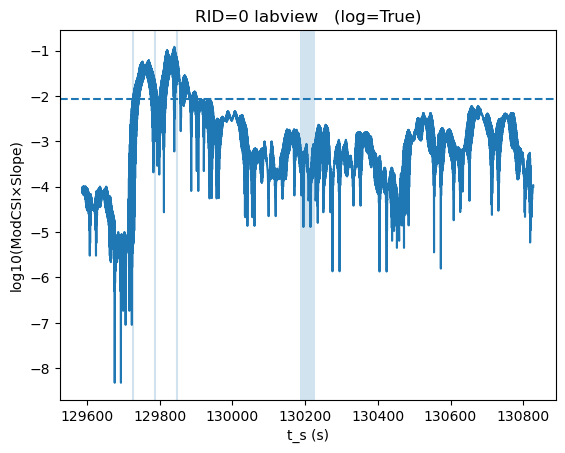

In [70]:
plot_feat_around_seizure(df_feat2, df_seiz, recording_uid=0, rr_source="labview")


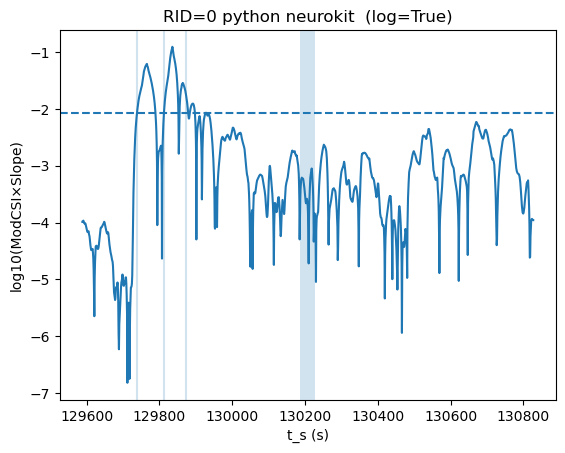

In [71]:
plot_feat_around_seizure(df_feat2, df_seiz, recording_uid=0, rr_source="python", algo_id="neurokit")


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def moving_mean(x: np.ndarray, k: int = 7) -> np.ndarray:
    """Simple k-point moving average (centered-ish via convolution)."""
    x = np.asarray(x, dtype=float)
    if k <= 1:
        return x
    kernel = np.ones(k) / k
    return np.convolve(x, kernel, mode="same")

def plot_feat_around_seizure_raw(
    df_feat2,
    df_seiz,
    *,
    recording_uid: int,
    rr_source: str = "labview",
    algo_id: str | None = None,
    delta_s: float = 600.0,
    thr: float | None = None,
    refractory_s: float = 60.0,
    use_sqi: bool = False,
    filt_k: int = 7,
    use_filt: bool = True,
):
    """
    Plot raw ModCSI×Slope around the first seizure in a recording (no log).
    Optionally apply k-point moving mean to match 'filt' look.
    """
    g = df_feat2[df_feat2["recording_uid"] == recording_uid].copy()
    g = g[g["rr_source"] == rr_source]
    if algo_id is not None:
        g = g[g["algo_id"] == algo_id]

    if use_sqi and "is_acceptable" in g.columns:
        g = g[g["is_acceptable"]]

    g = g.sort_values("t_s")
    seiz = df_seiz[df_seiz["recording_uid"] == recording_uid].copy()
    if seiz.empty:
        raise ValueError(f"No seizures for recording_uid={recording_uid}")

    s = seiz.iloc[0]
    t0, t1 = float(s["t0_clinical"]), float(s["t1_clinical"])
    a, b = t0 - delta_s, t1 + delta_s

    seg = g[(g["t_s"] >= a) & (g["t_s"] <= b)].copy()
    if seg.empty:
        raise ValueError("No feature points in window")

    x = seg["ModCSI_x_Slope"].astype(float).values
    y = moving_mean(x, filt_k) if use_filt else x

    # threshold (raw)
    if thr is None:
        pid = int(seg["patient_id"].iloc[0])
        # Use your Jeppesen threshold map if you want:
        # thr = thr_map_modcsi[pid]
        # Otherwise fall back to a quantile-based threshold for plotting
        thr = np.nanquantile(x, 0.95)

    # Detection times based on raw x (or use filtered y if you prefer)
    det_t = detect_times(seg["t_s"].values, x, thr, refractory_s)

    plt.figure()
    plt.plot(seg["t_s"].values, y, linewidth=1.2)
    plt.axvspan(t0, t1, alpha=0.2, label="Seizure interval")
    plt.axhline(thr, linestyle="--", label=f"Threshold={thr:.3g}")

    for tt in det_t:
        plt.axvline(tt, alpha=0.15)

    title = f"RID={recording_uid} {rr_source}" + (f" {algo_id}" if algo_id else "")
    title += f" | {'filt k='+str(filt_k) if use_filt else 'raw'}"
    plt.title(title)
    plt.xlabel("t_s (s)")
    plt.ylabel("ModCSI×Slope (raw scale)")
    plt.legend()
    plt.show()


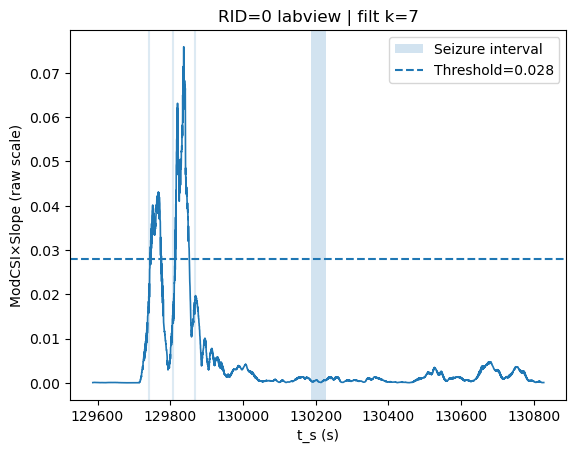

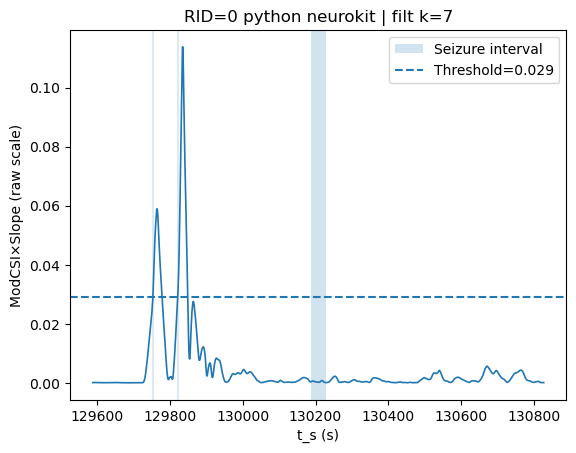

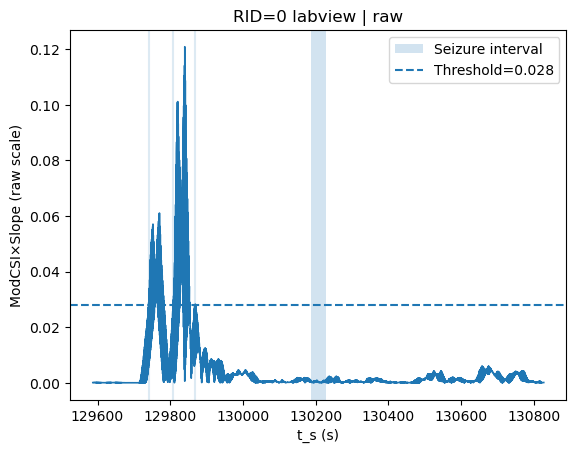

In [73]:
# LabVIEW raw (no log), with 7-mean smoothing
plot_feat_around_seizure_raw(df_feat2, df_seiz, recording_uid=0, rr_source="labview", use_filt=True, filt_k=7)

# Python NeuroKit raw, with 7-mean smoothing
plot_feat_around_seizure_raw(df_feat2, df_seiz, recording_uid=0, rr_source="python", algo_id="neurokit", use_filt=True, filt_k=7)

# Hvis du vil se HELT rå (ingen smoothing):
plot_feat_around_seizure_raw(df_feat2, df_seiz, recording_uid=0, rr_source="labview", use_filt=False)


In [74]:
import numpy as np
import pandas as pd

def poincare_sd1_sd2(rr: np.ndarray) -> tuple[float, float]:
    rr = np.asarray(rr, dtype=float)
    drr = np.diff(rr)
    var_rr = np.var(rr, ddof=1) if rr.size > 1 else np.nan
    var_drr = np.var(drr, ddof=1) if drr.size > 1 else np.nan
    sd1 = np.sqrt(0.5 * var_drr) if np.isfinite(var_drr) else np.nan
    sd2 = np.sqrt(2.0 * var_rr - 0.5 * var_drr) if (np.isfinite(var_rr) and np.isfinite(var_drr) and (2.0*var_rr - 0.5*var_drr) > 0) else np.nan
    return sd1, sd2

def compute_modcsi100_continuous(
    rr_s: np.ndarray,
    *,
    win_n: int = 100,
    step: int = 1,
    eps: float = 1e-12,
) -> pd.DataFrame:
    """
    Continuous ModCSI over sliding RR windows.
    Returns one feature point per window, timestamped at the window end (index).
    """
    rr = np.asarray(rr_s, dtype=float)
    n = rr.size
    if n < win_n:
        return pd.DataFrame(columns=["i_end", "ModCSI", "T", "L"])

    rows = []
    for i_end in range(win_n, n + 1, step):
        w = rr[i_end - win_n : i_end]
        if np.any(~np.isfinite(w)) or np.any(w <= 0):
            rows.append((i_end - 1, np.nan, np.nan, np.nan))
            continue

        sd1, sd2 = poincare_sd1_sd2(w)
        if not (np.isfinite(sd1) and np.isfinite(sd2)):
            rows.append((i_end - 1, np.nan, np.nan, np.nan))
            continue

        T = 4.0 * sd1
        L = 4.0 * sd2
        ModCSI = (L * L) / (T + eps)  # Jeppesen: L^2 / T
        rows.append((i_end - 1, ModCSI, T, L))

    return pd.DataFrame(rows, columns=["i_end", "ModCSI", "T", "L"])

def compute_slope_on_feature(
    t_s: np.ndarray,
    x: np.ndarray,
    *,
    slope_win: int = 7,
) -> np.ndarray:
    """
    Simple slope estimate: linear regression over last slope_win points.
    Returns slope per point (NaN until enough points).
    """
    t = np.asarray(t_s, dtype=float)
    y = np.asarray(x, dtype=float)
    out = np.full_like(y, np.nan, dtype=float)
    for i in range(len(y)):
        j0 = i - slope_win + 1
        if j0 < 0:
            continue
        tt = t[j0:i+1]
        yy = y[j0:i+1]
        if np.any(~np.isfinite(tt)) or np.any(~np.isfinite(yy)):
            continue
        # linear regression slope
        tt0 = tt - tt.mean()
        denom = np.sum(tt0**2)
        if denom <= 0:
            continue
        out[i] = np.sum(tt0 * (yy - yy.mean())) / denom
    return out

def rr_to_t_s(rr_s: np.ndarray, *, start_t_s: float = 0.0) -> np.ndarray:
    """Convert RR intervals to cumulative time in seconds (event time at end of each interval)."""
    rr = np.asarray(rr_s, dtype=float)
    t = start_t_s + np.cumsum(rr)
    return t


In [75]:
rid = 9

# 1) hent LabVIEW RR-serien for denne recording (sek)
# eksempel: df_rr har kolonne "RR_labview_s"
rr = df_rr["RR_labview_s"].values

# 2) continuous ModCSI100
feat = compute_modcsi100_continuous(rr, win_n=100, step=1)

# 3) tid i sekunder (t_s ved window end)
t_rr = rr_to_t_s(rr)  # t for each RR end
feat["t_s"] = t_rr[feat["i_end"].values]

# 4) 7-point smoothing på ModCSI (Jeppesen “filt”)
feat["ModCSI_filt"] = pd.Series(feat["ModCSI"]).rolling(7, center=True, min_periods=1).mean()

# 5) slope på den filtrerede ModCSI (slope af feature, ikke RR!)
feat["Slope"] = compute_slope_on_feature(feat["t_s"].values, feat["ModCSI_filt"].values, slope_win=7)

# 6) product
feat["ModCSIxSlope"] = feat["ModCSI_filt"] * feat["Slope"]


In [76]:
import matplotlib.pyplot as plt

def plot_modcsi_series_around_seiz(
    feat_df: pd.DataFrame,
    df_seiz: pd.DataFrame,
    *,
    recording_uid: int,
    seizure_id: int,
    delta_s: float = 600.0,
    col: str = "ModCSI_filt",
):
    s = df_seiz[(df_seiz["recording_uid"]==recording_uid) & (df_seiz["seizure_id"]==seizure_id)].iloc[0]
    t0, t1 = float(s["t0_clinical"]), float(s["t1_clinical"])
    a, b = t0-delta_s, t1+delta_s
    seg = feat_df[(feat_df["t_s"]>=a) & (feat_df["t_s"]<=b)].copy()

    plt.figure()
    plt.plot(seg["t_s"].values, seg[col].values, linewidth=1.2)
    plt.axvspan(t0, t1, alpha=0.2)
    plt.title(f"RID={recording_uid} seizure={seizure_id}  ({col})")
    plt.xlabel("t_s (s)")
    plt.ylabel(col)
    plt.show()


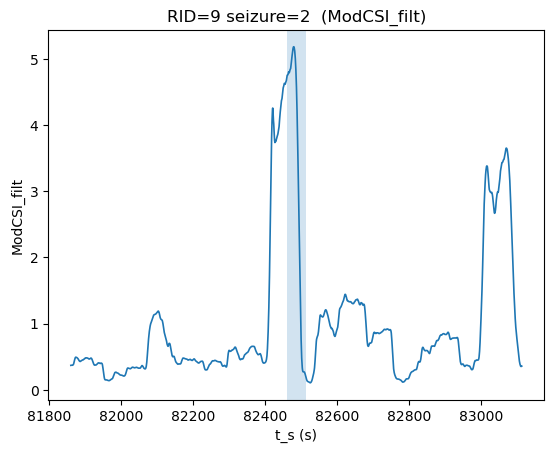

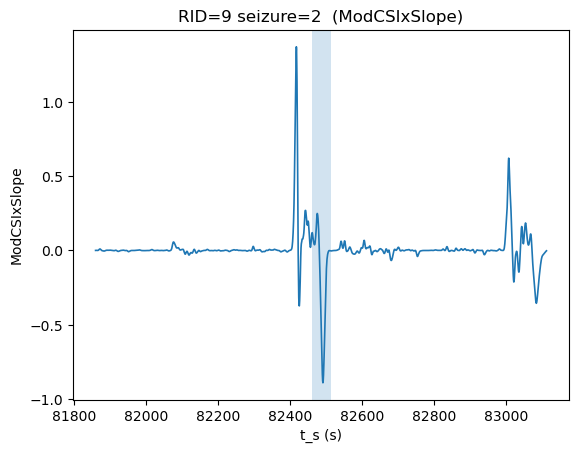

In [77]:
plot_modcsi_series_around_seiz(feat, df_seiz, recording_uid=9, seizure_id=2, col="ModCSI_filt")
plot_modcsi_series_around_seiz(feat, df_seiz, recording_uid=9, seizure_id=2, col="ModCSIxSlope")


In [78]:
feat["ModCSIxSlope"].describe(percentiles=[0.9,0.95,0.99,0.999])


count    226339.000000
mean          0.008816
std           0.247341
min          -5.596825
50%          -0.000014
90%           0.033543
95%           0.090165
99%           0.590031
99.9%         2.945127
max          10.124875
Name: ModCSIxSlope, dtype: float64

In [82]:
from pathlib import Path
import numpy as np
import pandas as pd

TRIM_DIR = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim")

def load_rr_series_for_recording_uid(
    rid: int,
    df_rec_index: pd.DataFrame,
    *,
    base_dir: Path,
    rr_col: str = "RR_labview_s",
    algo_hint: str | None = None,  # e.g. "neurokit" to pick a specific file if multiple match
) -> np.ndarray:
    """
    Returns RR intervals (seconds) for a given recording_uid from the aligned RR csv files.
    Uses recordings_index to map recording_uid -> patient/enrollment/recording ids -> filename prefix.
    """
    rec = df_rec_index.loc[df_rec_index["recording_uid"] == rid].iloc[0]
    pid = int(rec["patient_id"])
    rec_id = int(rec["recording_id"])
    enr = rec.get("enrollment_id", "")
    enr = "" if pd.isna(enr) else str(enr)

    # Build the filename prefix used in your RR-alignment files
    # Example: P27b_R01_...
    prefix = f"P{pid:02d}{enr}_R{rec_id:02d}_"
    candidates = list(base_dir.glob(prefix + "*_rr_aligned.csv"))
    if not candidates:
        raise FileNotFoundError(f"No aligned RR files found for prefix {prefix} in {base_dir}")

    # If many files exist (different algos), pick one deterministically
    if algo_hint is not None:
        cand2 = [p for p in candidates if f"_{algo_hint}_" in p.name]
        if cand2:
            candidates = cand2

    path = sorted(candidates)[0]
    df = pd.read_csv(path)

    if rr_col not in df.columns:
        raise KeyError(f"Column '{rr_col}' not found in {path.name}. Columns: {df.columns.tolist()}")

    rr = pd.to_numeric(df[rr_col], errors="coerce").dropna()

    # Basic sanity filtering (remove zeros/negatives and extreme outliers)
    rr = rr[(rr > 0.2) & (rr < 3.0)]  # adjust if needed

    return rr.to_numpy(dtype=float)

# === Use it (RID=9, LabVIEW RR series) ===
rr_labview_s_for_rid9 = load_rr_series_for_recording_uid(
    rid=9,
    df_rec_index=df_rec,     # your loaded recordings_index.csv
    base_dir=TRIM_DIR,
    rr_col="RR_labview_s",
    algo_hint=None,          # optional
)

print("RR series length:", len(rr_labview_s_for_rid9))
print("RR seconds quantiles:", np.quantile(rr_labview_s_for_rid9, [0.01, 0.5, 0.99]))


RR series length: 165335
RR seconds quantiles: [0.46635464 1.08176708 1.47945076]


In [83]:
def compute_feat_variants(rr_s):
    rr_s = np.asarray(rr_s, float)
    rr_ms = rr_s * 1000.0

    def build(rr, label):
        feat = compute_modcsi100_continuous(rr, win_n=100, step=1)
        t = rr_to_t_s(rr_s)  # IMPORTANT: keep time axis in seconds for both variants
        feat["t_s"] = t[feat["i_end"].values]

        feat["ModCSI_filt"] = pd.Series(feat["ModCSI"]).rolling(7, center=True, min_periods=1).mean()

        # slope variants
        # 1) regression slope per second (your current)
        feat["Slope_reg"] = compute_slope_on_feature(feat["t_s"].values, feat["ModCSI_filt"].values, slope_win=7)
        feat["Prod_reg"] = feat["ModCSI_filt"] * feat["Slope_reg"]

        # 2) finite-diff per second
        x = feat["ModCSI_filt"].values
        tt = feat["t_s"].values
        dx = np.diff(x, prepend=np.nan)
        dt = np.diff(tt, prepend=np.nan)
        feat["Slope_diff"] = dx / dt
        feat["Prod_diff"] = feat["ModCSI_filt"] * feat["Slope_diff"]

        # 3) finite-diff per step (no /dt)
        feat["Slope_step"] = dx
        feat["Prod_step"] = feat["ModCSI_filt"] * feat["Slope_step"]

        # summary
        def q(s):
            s = pd.Series(s).dropna()
            return dict(p99=s.quantile(0.99), p999=s.quantile(0.999), max=s.max())

        out = {
            "label": label,
            "ModCSI": q(feat["ModCSI_filt"]),
            "Prod_reg": q(feat["Prod_reg"]),
            "Prod_diff": q(feat["Prod_diff"]),
            "Prod_step": q(feat["Prod_step"]),
        }
        return feat, out

    feat_s, sum_s = build(rr_s, "RR in seconds")
    feat_ms, sum_ms = build(rr_ms, "RR in milliseconds")
    return (feat_s, sum_s), (feat_ms, sum_ms)

# run for rid=9 labview RR series
(res_s, sum_s), (res_ms, sum_ms) = compute_feat_variants(rr_labview_s_for_rid9)
print(sum_s)
print(sum_ms)


{'label': 'RR in seconds', 'ModCSI': {'p99': np.float64(7.523107624892865), 'p999': np.float64(11.218369126051787), 'max': 15.577344500931332}, 'Prod_reg': {'p99': np.float64(0.8772695112819459), 'p999': np.float64(2.9704443864049344), 'max': 8.848423574249844}, 'Prod_diff': {'p99': np.float64(0.83038552909568), 'p999': np.float64(2.7814796537619677), 'max': 8.323147885996168}, 'Prod_step': {'p99': np.float64(0.7498577947194932), 'p999': np.float64(2.546321103792856), 'max': 6.336781409670957}}
{'label': 'RR in milliseconds', 'ModCSI': {'p99': np.float64(7523.107624981612), 'p999': np.float64(11218.369126173204), 'max': 15577.344501097814}, 'Prod_reg': {'p99': np.float64(877269.5112978984), 'p999': np.float64(2970444.386486206), 'max': 8848423.574564837}, 'Prod_diff': {'p99': np.float64(830385.5291105882), 'p999': np.float64(2781479.653866034), 'max': 8323147.886284767}, 'Prod_step': {'p99': np.float64(749857.7947561117), 'p999': np.float64(2546321.103913472), 'max': 6336781.409846243}

In [ ]:
def assign_window_center_time(rr_s, i_end, win_n=100):
    t = rr_to_t_s(rr_s)
    i0 = i_end - win_n + 1
    return np.mean(t[i0:i_end+1])

feat = compute_modcsi100_continuous(rr_labview_s_for_rid9, win_n=100, step=1)
feat["t_end"] = rr_to_t_s(rr_labview_s_for_rid9)[feat["i_end"].values]
feat["t_center"] = [assign_window_center_time(rr_labview_s_for_rid9, ie, 100) for ie in feat["i_end"].values]

# plot both to see alignment difference

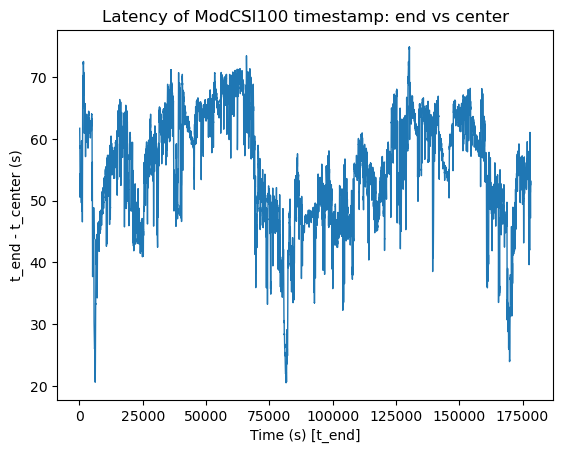

Δt quantiles (s): [23.16024334 53.78779941 70.07013229]


In [88]:
import matplotlib.pyplot as plt
import numpy as np

feat = feat.copy()
feat["dt_end_minus_center"] = feat["t_end"] - feat["t_center"]

plt.figure()
plt.plot(feat["t_end"].values, feat["dt_end_minus_center"].values, linewidth=1)
plt.xlabel("Time (s) [t_end]")
plt.ylabel("t_end - t_center (s)")
plt.title("Latency of ModCSI100 timestamp: end vs center")
plt.show()

print("Δt quantiles (s):", np.quantile(feat["dt_end_minus_center"].dropna(), [0.01, 0.5, 0.99]))


In [92]:
import pandas as pd
import numpy as np

# Hvis feat kun har ModCSI, så lav ModCSI_filt her:
if "ModCSI_filt" not in feat.columns:
    feat["ModCSI_filt"] = (
        pd.Series(feat["ModCSI"])
        .rolling(7, center=True, min_periods=1)
        .mean()
        .to_numpy()
    )

# sanity
print("Columns present:", [c for c in ["ModCSI","ModCSI_filt","t_end","t_center"] if c in feat.columns])


Columns present: ['ModCSI', 'ModCSI_filt', 't_end', 't_center']


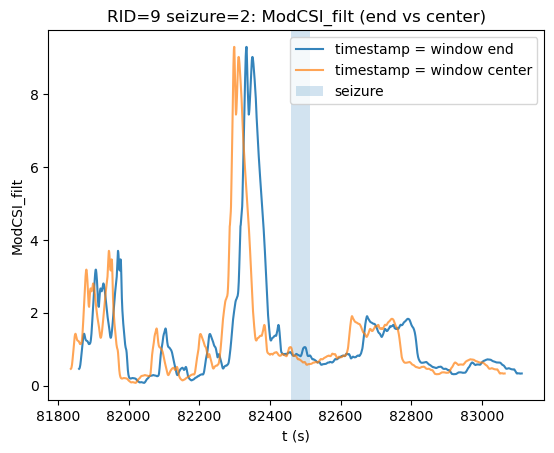

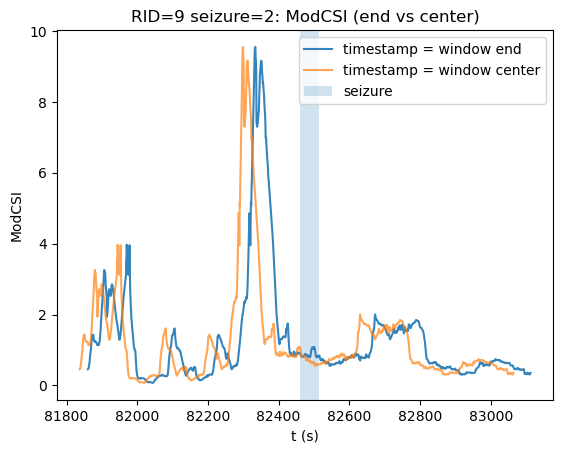

In [95]:
def plot_end_vs_center_around_seiz(feat_df, df_seiz, *, rid, seizure_id, delta_s=600, ycol="ModCSI_filt"):
    s = df_seiz[(df_seiz["recording_uid"]==rid) & (df_seiz["seizure_id"]==seizure_id)].iloc[0]
    t0, t1 = float(s["t0_clinical"]), float(s["t1_clinical"])
    a, b = t0-delta_s, t1+delta_s

    seg = feat_df[(feat_df["t_end"]>=a) & (feat_df["t_end"]<=b)].copy()

    plt.figure()
    plt.plot(seg["t_end"].values, seg[ycol].values, label="timestamp = window end", alpha=0.9)
    plt.plot(seg["t_center"].values, seg[ycol].values, label="timestamp = window center", alpha=0.7)
    plt.axvspan(t0, t1, alpha=0.2, label="seizure")
    plt.xlabel("t (s)")
    plt.ylabel(ycol)
    plt.title(f"RID={rid} seizure={seizure_id}: {ycol} (end vs center)")
    plt.legend()
    plt.show()

# Example:
plot_end_vs_center_around_seiz(feat, df_seiz, rid=9, seizure_id=2, ycol="ModCSI_filt")
plot_end_vs_center_around_seiz(feat, df_seiz, rid=9, seizure_id=2, ycol="ModCSI")



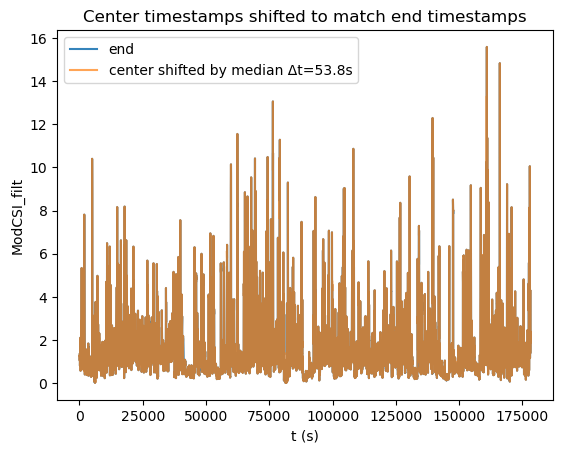

In [94]:
seg = feat.copy()
dt_med = float(np.nanmedian(seg["t_end"] - seg["t_center"]))
seg["t_center_shifted"] = seg["t_center"] + dt_med

plt.figure()
plt.plot(seg["t_end"], seg["ModCSI_filt"], label="end", alpha=0.9)
plt.plot(seg["t_center_shifted"], seg["ModCSI_filt"], label=f"center shifted by median Δt={dt_med:.1f}s", alpha=0.7)
plt.legend()
plt.title("Center timestamps shifted to match end timestamps")
plt.xlabel("t (s)")
plt.ylabel("ModCSI_filt")
plt.show()


In [ ]:
def plot_modcsi_and_product(feat, df_seiz, *, rid, seizure_id):
    g = feat[feat["recording_uid"] == rid].sort_values("t_end")
    s = df_seiz[(df_seiz["recording_uid"] == rid) &
                (df_seiz["seizure_id"] == seizure_id)].iloc[0]

    t0, t1 = float(s["t0_clinical"]), float(s["t1_clinical"])

    fig, ax1 = plt.subplots(figsize=(10,4))
    ax2 = ax1.twinx()

    ax1.plot(g["t_end"], g["ModCSI_filt"],
             color="tab:blue", label="ModCSI (100RR, filt)")
    ax2.plot(g["t_end"], g["ModCSIxSlope"],
             color="tab:red", alpha=0.7, label="ModCSI × Slope")

    ax1.axvspan(t0, t1, color="grey", alpha=0.3, label="Seizure")

    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("ModCSI")
    ax2.set_ylabel("ModCSI × Slope")

    # threshold
    pid = int(g["patient_id"].iloc[0])
    thr = thr_map_modcsi.get(pid, None)
    if thr is not None:
        ax2.axhline(thr, color="red", linestyle="--", alpha=0.6,
                    label="Threshold")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines+lines2, labels+labels2, loc="upper left")

    plt.title(f"RID={rid}, seizure={seizure_id}")
    plt.tight_layout()
    plt.show()


In [103]:
rid = 9

# 1) tilføj recording_uid hvis den mangler
if "recording_uid" not in feat.columns:
    feat = feat.copy()
    feat["recording_uid"] = rid

# 2) tilføj patient_id hvis den mangler (hentes fra recordings_index)
if "patient_id" not in feat.columns:
    pid = int(df_rec.loc[df_rec["recording_uid"] == rid, "patient_id"].iloc[0])
    feat["patient_id"] = pid

# 3) sørg for t_end findes (hvis du kun har t_s)
if "t_end" not in feat.columns and "t_s" in feat.columns:
    feat["t_end"] = feat["t_s"]

# 4) sanity
print("feat columns ok:", all(c in feat.columns for c in ["recording_uid","patient_id","t_end"]))


feat columns ok: True


In [105]:
import matplotlib.pyplot as plt

def plot_modcsi_and_product(feat, df_seiz, *, rid, seizure_id, t_col=None):
    # vælg tidskolonne automatisk
    if t_col is None:
        t_col = "t_end" if "t_end" in feat.columns else ("t_s" if "t_s" in feat.columns else None)
    if t_col is None:
        raise KeyError("feat must have a time column: 't_end' or 't_s'")

    g = feat.sort_values(t_col).copy()

    s = df_seiz[(df_seiz["recording_uid"] == rid) & (df_seiz["seizure_id"] == seizure_id)].iloc[0]
    t0, t1 = float(s["t0_clinical"]), float(s["t1_clinical"])

    fig, ax1 = plt.subplots(figsize=(10,4))
    ax2 = ax1.twinx()

    y1 = "ModCSI_filt" if "ModCSI_filt" in g.columns else "ModCSI"
    if y1 not in g.columns:
        raise KeyError("feat must have ModCSI or ModCSI_filt")

    ax1.plot(g[t_col], g[y1], label=y1, alpha=0.9)
    if "ModCSIxSlope" in g.columns:
        ax2.plot(g[t_col], g["ModCSIxSlope"], alpha=0.7, label="ModCSIxSlope")
    else:
        raise KeyError("feat must have 'ModCSIxSlope' to plot the product")

    ax1.axvspan(t0, t1, alpha=0.2, label="seizure")

    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(y1)
    ax2.set_ylabel("ModCSIxSlope")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines+lines2, labels+labels2, loc="upper left")

    plt.title(f"RID={rid}, seizure={seizure_id}")
    plt.tight_layout()
    plt.show()


KeyError: "feat must have 'ModCSIxSlope' to plot the product"

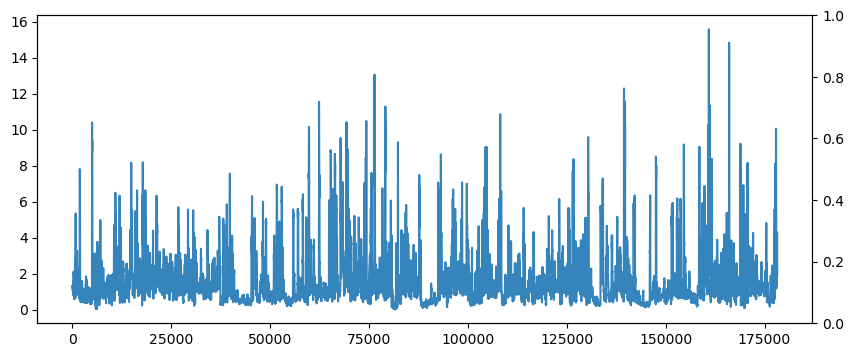

In [106]:
plot_modcsi_and_product(feat, df_seiz, rid=9, seizure_id=2)


In [109]:
import numpy as np
import pandas as pd

def add_rr_slope_and_product(
    feat: pd.DataFrame,
    rr_ms: np.ndarray,
    *,
    win_rr: int = 100,
    slope_method: str = "regression",   # "regression" eller "diff"
    filt_len: int = 7,
) -> pd.DataFrame:
    """
    Adds RR-slope (based on RR in ms) and ModCSIxSlope to a feature dataframe that
    already contains ModCSI and (optionally) ModCSI_filt.

    Assumes feat rows correspond to sliding windows of length win_rr with step=1 beat,
    and are timestamped at t_end of the window.
    """
    out = feat.copy()

    rr_ms = np.asarray(rr_ms, float)
    if len(rr_ms) < win_rr + 2:
        raise ValueError("RR series too short for win_rr.")

    # Ensure ModCSI_filt exists
    if "ModCSI_filt" not in out.columns:
        out["ModCSI_filt"] = (
            pd.Series(out["ModCSI"])
            .rolling(filt_len, center=True, min_periods=1)
            .mean()
            .to_numpy()
        )

    # Number of feature rows expected from a step=1 sliding window:
    n_expected = len(rr_ms) - win_rr + 1
    if len(out) != n_expected:
        # If mismatch, we can still attempt alignment by trimming to min length
        n = min(len(out), n_expected)
        out = out.iloc[:n].copy()
        rr_ms = rr_ms[: (n + win_rr - 1)]  # keep RR length consistent

    # Build slope per window (one value per feature row)
    slopes = np.empty(len(out), dtype=float)

    if slope_method == "diff":
        # simple: slope = |RR_last - RR_first| / win_rr  (ms/beat)
        # (robust-ish, but ignores within-window pattern)
        for i in range(len(out)):
            w = rr_ms[i : i + win_rr]
            slopes[i] = abs(w[-1] - w[0]) / (win_rr - 1)

    elif slope_method == "regression":
        # regression of RR vs beat index within window: slope in ms/beat
        x = np.arange(win_rr, dtype=float)
        x_mean = x.mean()
        x_denom = ((x - x_mean) ** 2).sum()

        for i in range(len(out)):
            y = rr_ms[i : i + win_rr]
            y_mean = y.mean()
            slopes[i] = abs(((x - x_mean) * (y - y_mean)).sum() / x_denom)

    else:
        raise ValueError("slope_method must be 'regression' or 'diff'")

    out["RR_slope_ms_per_beat"] = slopes
    out["ModCSIxSlope"] = out["ModCSI_filt"] * out["RR_slope_ms_per_beat"]
    return out

# === Eksempel: RID=9 (LabVIEW RR) ===
rid = 9
rr_lab_ms = rr_labview_s_for_rid9 * 1000.0  # du har rr i sekunder -> ms

feat2 = add_rr_slope_and_product(
    feat,
    rr_ms=rr_lab_ms,
    win_rr=100,
    slope_method="regression",  # start her
    filt_len=7
)

print(feat2[["ModCSI_filt","RR_slope_ms_per_beat","ModCSIxSlope"]].describe(percentiles=[0.9,0.95,0.99]))


         ModCSI_filt  RR_slope_ms_per_beat   ModCSIxSlope
count  165236.000000         165236.000000  165236.000000
mean        1.588481              0.825981       2.261606
std         1.427251              0.895045       5.330168
min         0.013215              0.000005       0.000002
50%         1.210894              0.521008       0.573498
90%         3.069034              1.994675       5.478363
95%         4.511660              2.747952      10.594879
99%         7.523108              4.204323      26.661154
max        15.577345              6.803439     105.342838


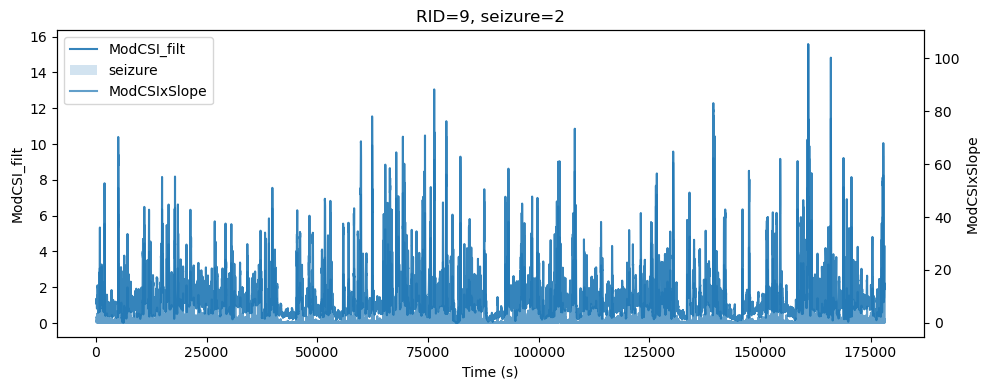

In [110]:
plot_modcsi_and_product(feat2, df_seiz, rid=9, seizure_id=2, t_col="t_end")


       ModCSI_filt_ms  RR_slope_ms_per_beat  ModCSIxSlope_ms
count   165236.000000         165236.000000    165236.000000
mean      1588.481467              0.825981      2261.606198
std       1427.251287              0.895045      5330.168091
min         13.215489              0.000005         0.002016
50%       1210.894481              0.521008       573.498387
90%       3069.034417              1.994675      5478.362896
95%       4511.659956              2.747952     10594.879492
99%       7523.107625              4.204323     26661.153678
99.9%    11218.369126              5.591931     55375.788617
max      15577.344501              6.803439    105342.837666


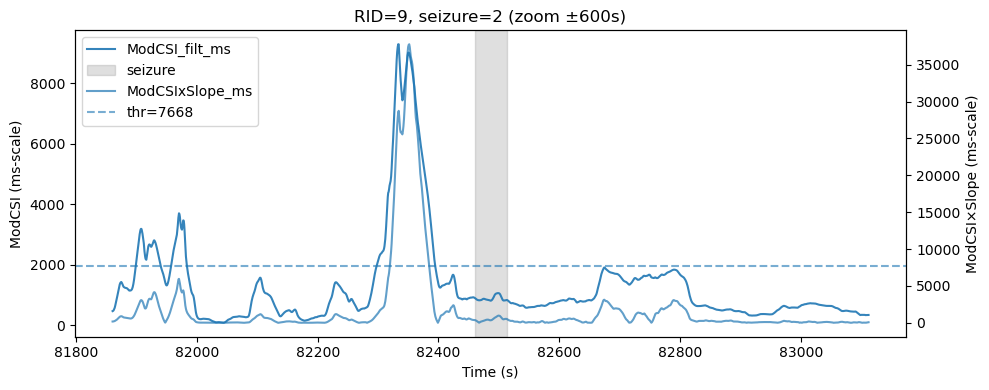

In [111]:
feat2 = feat2.copy()

feat2["ModCSI_ms"] = feat2["ModCSI"] * 1000.0
feat2["ModCSI_filt_ms"] = feat2["ModCSI_filt"] * 1000.0
feat2["ModCSIxSlope_ms"] = feat2["ModCSI_filt_ms"] * feat2["RR_slope_ms_per_beat"]

print(feat2[["ModCSI_filt_ms","RR_slope_ms_per_beat","ModCSIxSlope_ms"]].describe(percentiles=[0.9,0.95,0.99,0.999]))

import matplotlib.pyplot as plt

def plot_zoom_modcsi_and_product(
    feat_df, df_seiz, *, rid, seizure_id,
    delta_s=600,
    modcsi_col="ModCSI_filt_ms",
    prod_col="ModCSIxSlope_ms"
):
    s = df_seiz[(df_seiz["recording_uid"]==rid) & (df_seiz["seizure_id"]==seizure_id)].iloc[0]
    t0, t1 = float(s["t0_clinical"]), float(s["t1_clinical"])
    a, b = t0-delta_s, t1+delta_s

    g = feat_df[(feat_df["t_end"]>=a) & (feat_df["t_end"]<=b)].sort_values("t_end").copy()

    fig, ax1 = plt.subplots(figsize=(10,4))
    ax2 = ax1.twinx()

    ax1.plot(g["t_end"], g[modcsi_col], label=modcsi_col, alpha=0.9)
    ax2.plot(g["t_end"], g[prod_col], label=prod_col, alpha=0.7)

    ax1.axvspan(t0, t1, color="grey", alpha=0.25, label="seizure")

    # optional: threshold line (if you have it)
    pid = int(feat_df["patient_id"].iloc[0]) if "patient_id" in feat_df.columns else None
    if pid is not None and "thr_map_modcsi" in globals():
        thr = thr_map_modcsi.get(pid, None)
        if thr is not None:
            ax2.axhline(thr, linestyle="--", alpha=0.6, label=f"thr={thr:.0f}")

    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("ModCSI (ms-scale)")
    ax2.set_ylabel("ModCSI×Slope (ms-scale)")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines+lines2, labels+labels2, loc="upper left")

    plt.title(f"RID={rid}, seizure={seizure_id} (zoom ±{delta_s}s)")
    plt.tight_layout()
    plt.show()

# Kør for rid=9 seizure=2
plot_zoom_modcsi_and_product(feat2, df_seiz, rid=9, seizure_id=2)


In [112]:
import numpy as np
import pandas as pd

def add_slope_variants_and_products(feat2, rr_ms, win_rr=100):
    rr_ms = np.asarray(rr_ms, float)
    n = len(feat2)
    # n windows -> rr length should be n+win_rr-1
    rr_ms = rr_ms[: n + win_rr - 1]

    # our existing regression slope in ms/beat (recompute quickly)
    x = np.arange(win_rr, dtype=float)
    xm = x.mean()
    denom = ((x - xm)**2).sum()

    slope_msbeat = np.empty(n, float)
    slope_rel = np.empty(n, float)   # dimensionless

    for i in range(n):
        w = rr_ms[i:i+win_rr]
        ym = w.mean()
        slope_msbeat[i] = abs(((x-xm)*(w-ym)).sum()/denom)

        d = np.abs(np.diff(w))
        slope_rel[i] = np.median(d) / np.median(w)

    out = feat2.copy()
    out["slope_msbeat"] = slope_msbeat
    out["slope_sbeat"]  = slope_msbeat / 1000.0
    out["slope_rel"]    = slope_rel

    # products (use ModCSI_filt_ms!)
    out["prod_msbeat"] = out["ModCSI_filt_ms"] * out["slope_msbeat"]
    out["prod_sbeat"]  = out["ModCSI_filt_ms"] * out["slope_sbeat"]
    out["prod_rel"]    = out["ModCSI_filt_ms"] * out["slope_rel"]

    return out

rid = 9
rr_lab_ms = rr_labview_s_for_rid9 * 1000.0

feat3 = add_slope_variants_and_products(feat2, rr_lab_ms, win_rr=100)

thr = thr_map_modcsi[int(feat3["patient_id"].iloc[0])]
print("threshold:", thr)

for col in ["prod_msbeat","prod_sbeat","prod_rel"]:
    frac = (feat3[col] > thr).mean()
    print(col, "p99=", np.quantile(feat3[col], 0.99), "max=", feat3[col].max(), "frac>thr=", frac)


threshold: 7668.27
prod_msbeat p99= 26661.153677754122 max= 105342.8376660959 frac>thr= 0.07124960662325401
prod_sbeat p99= 26.66115367775412 max= 105.34283766609592 frac>thr= 0.0
prod_rel p99= 144.68423307753778 max= 228.96987340272034 frac>thr= 0.0


In [113]:
import numpy as np

thr = 7668.27  # patient 7 / rid=9 fra dit ark

# Window-mean RR (sekunder) for samme 100RR windows (step=1)
win_rr = 100
rr_ms = rr_labview_s_for_rid9 * 1000.0
rr_s  = rr_labview_s_for_rid9

n = len(feat2)  # feat2 har ModCSI_filt_ms
rr_s_use = rr_s[: n + win_rr - 1]

mean_rr_s = np.array([rr_s_use[i:i+win_rr].mean() for i in range(n)])  # seconds

# eksisterende slope i ms/beat
slope_msbeat = feat2["RR_slope_ms_per_beat"].to_numpy()

# konverter til ms/s
slope_mss = slope_msbeat / mean_rr_s

# produkter (behold ModCSI_filt_ms da den matcher threshold skalaen)
prod_msbeat = feat2["ModCSI_filt_ms"].to_numpy() * slope_msbeat
prod_mss    = feat2["ModCSI_filt_ms"].to_numpy() * slope_mss
prod_plain  = feat2["ModCSI_filt_ms"].to_numpy()  # bare ModCSI_filt_ms alene

def summarize(name, x):
    print(
        name,
        "p99=", np.quantile(x, 0.99),
        "max=", np.max(x),
        "frac>thr=", np.mean(x > thr)
    )

summarize("ModCSI_filt_ms only", prod_plain)
summarize("ModCSI_filt_ms * slope_msbeat", prod_msbeat)
summarize("ModCSI_filt_ms * slope_mss", prod_mss)


ModCSI_filt_ms only p99= 7523.107624892866 max= 15577.344500931333 frac>thr= 0.00921106780604711
ModCSI_filt_ms * slope_msbeat p99= 26661.153677754122 max= 105342.8376660959 frac>thr= 0.07124960662325401
ModCSI_filt_ms * slope_mss p99= 27291.805511532024 max= 115769.66059672687 frac>thr= 0.06848991745140284


In [117]:
import numpy as np
import pandas as pd

# ----------------------------
# Config
# ----------------------------
TOL_SEIZ_S = 5 * 60          # ±5 min
GAP_MERGE_S = 30             # merge crossings if gap <= 30s
REFRACTORY_S = 5 * 60        # collapse events within 5 min. set None to disable

responders = [3,5,6,8,14,15,16,21,23,27,28,29,31,34,37,39,40,41,42]  # patient_id list

def pick_time_col(df: pd.DataFrame, candidates=("t_end","t_s","t_center")) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found in df columns.")

TIME_COL = pick_time_col(df_feat2)
print("Using time column:", TIME_COL)

# ----------------------------
# Helpers
# ----------------------------
def add_responder_label(df: pd.DataFrame, responders_list) -> pd.DataFrame:
    out = df.copy()
    if "patient_id" not in out.columns:
        raise KeyError("patient_id missing – cannot assign responder label")
    out["is_responder"] = out["patient_id"].isin(responders_list)
    return out

def _collapse_events(times: np.ndarray, *, gap_s: float, refractory_s: float | None):
    if times.size == 0:
        return np.array([], dtype=float)
    t = np.sort(times.astype(float))

    # merge crossings by gap
    starts = [t[0]]
    last = t[0]
    for x in t[1:]:
        if (x - last) > gap_s:
            starts.append(x)
        last = x
    starts = np.array(starts, dtype=float)

    if refractory_s is None:
        return starts

    # refractory
    kept = [starts[0]]
    last_kept = starts[0]
    for x in starts[1:]:
        if (x - last_kept) >= refractory_s:
            kept.append(x)
            last_kept = x
    return np.array(kept, dtype=float)

def extract_events_from_feature(
    g: pd.DataFrame,
    *,
    value_col: str,
    thr: float,
    time_col: str = TIME_COL,
    gap_s: float = GAP_MERGE_S,
    refractory_s: float | None = REFRACTORY_S,
) -> np.ndarray:
    x = g[[time_col, value_col]].dropna().sort_values(time_col)
    if x.empty:
        return np.array([], dtype=float)
    crossings = x.loc[x[value_col].to_numpy() > thr, time_col].to_numpy(dtype=float)
    return _collapse_events(crossings, gap_s=gap_s, refractory_s=refractory_s)

def score_recording_events(
    *,
    rid: int,
    g: pd.DataFrame,
    seiz_rec: pd.DataFrame,
    value_col: str,
    thr: float,
    use_sqi: bool,
    tol_s: float = TOL_SEIZ_S,
) -> dict:
    if use_sqi:
        g = g[g["is_acceptable"].astype(bool)].copy()

    if g.empty:
        return dict(rid=rid, hours=0.0, fp_events=0, n_seiz_total=len(seiz_rec), n_seiz_detected=0)

    tmax = float(g[TIME_COL].max())
    hours = tmax / 3600.0 if np.isfinite(tmax) else 0.0

    ev = extract_events_from_feature(g, value_col=value_col, thr=thr, time_col=TIME_COL)
    n_events = int(ev.size)

    if seiz_rec.empty:
        return dict(rid=rid, hours=hours, fp_events=n_events, n_seiz_total=0, n_seiz_detected=0)

    # expanded seizure intervals
    intervals = []
    for _, s in seiz_rec.iterrows():
        t0, t1 = float(s["t0_clinical"]), float(s["t1_clinical"])
        intervals.append((t0 - tol_s, t1 + tol_s))

    # seizure detected per seizure row
    n_seiz_total = len(seiz_rec)
    n_seiz_detected = 0
    for _, s in seiz_rec.iterrows():
        t0, t1 = float(s["t0_clinical"]), float(s["t1_clinical"])
        a, b = t0 - tol_s, t1 + tol_s
        if (ev.size > 0) and np.any((ev >= a) & (ev <= b)):
            n_seiz_detected += 1

    # FP events (outside all expanded seizure intervals)
    inside_any = np.zeros(ev.shape[0], dtype=bool)
    for a, b in intervals:
        inside_any |= ((ev >= a) & (ev <= b))
    fp_events = int((~inside_any).sum())

    return dict(rid=rid, hours=hours, fp_events=fp_events, n_seiz_total=n_seiz_total, n_seiz_detected=n_seiz_detected)

def score_pipeline_events_thrcol(
    feat: pd.DataFrame,
    seiz_all: pd.DataFrame,
    *,
    value_col: str,
    thr_col: str,
    use_sqi: bool,
) -> dict:
    rec_rows = []
    for rid, g in feat.groupby("recording_uid", sort=False):
        # threshold from column (constant per patient, but already attached)
        if thr_col not in g.columns:
            raise KeyError(f"Missing threshold column: {thr_col}")
        thr = float(g[thr_col].dropna().iloc[0]) if g[thr_col].notna().any() else np.nan
        if not np.isfinite(thr):
            continue

        seiz_rec = seiz_all[seiz_all["recording_uid"] == rid].copy()
        rec_rows.append(
            score_recording_events(
                rid=int(rid), g=g, seiz_rec=seiz_rec,
                value_col=value_col, thr=thr, use_sqi=use_sqi
            )
        )

    if not rec_rows:
        return dict(n_recordings_used=0, n_seiz_total=0, n_seiz_detected=0,
                    recall=np.nan, fp_events=0, far_per_h=np.nan, total_h=0.0)

    df = pd.DataFrame(rec_rows)
    n_recordings_used = int(df["rid"].nunique())
    n_seiz_total = int(df["n_seiz_total"].sum())
    n_seiz_detected = int(df["n_seiz_detected"].sum())
    recall = (n_seiz_detected / n_seiz_total) if n_seiz_total else np.nan

    fp_events = int(df["fp_events"].sum())
    total_h = float(df["hours"].sum())
    far_per_h = (fp_events / total_h) if total_h > 0 else np.nan

    return dict(
        n_recordings_used=n_recordings_used,
        n_seiz_total=n_seiz_total,
        n_seiz_detected=n_seiz_detected,
        recall=recall,
        fp_events=fp_events,
        far_per_h=far_per_h,
        total_h=total_h
    )

def build_event_main_table_thrcol(
    df_feat2: pd.DataFrame,
    df_seiz: pd.DataFrame,
    *,
    thr_col: str,
    feature_specs: list[tuple[str,str]],   # (label, value_col)
):
    rows = []

    # LabVIEW: single stream
    feat_lab = df_feat2[df_feat2["rr_source"].str.lower() == "labview"].copy()
    for feat_label, value_col in feature_specs:
        for use_sqi in [False, True]:
            res = score_pipeline_events_thrcol(
                feat_lab, df_seiz, value_col=value_col, thr_col=thr_col, use_sqi=use_sqi
            )
            rows.append({
                "RR_source": "LabVIEW",
                "Algorithm": "—",
                "Feature": feat_label,
                "SQI": "on" if use_sqi else "off",
                **res
            })

    # Python: per algo
    feat_py = df_feat2[df_feat2["rr_source"].str.lower() == "python"].copy()
    for algo, g in feat_py.groupby("algo_id", sort=False):
        for feat_label, value_col in feature_specs:
            for use_sqi in [False, True]:
                res = score_pipeline_events_thrcol(
                    g, df_seiz, value_col=value_col, thr_col=thr_col, use_sqi=use_sqi
                )
                rows.append({
                    "RR_source": "Python",
                    "Algorithm": algo,
                    "Feature": feat_label,
                    "SQI": "on" if use_sqi else "off",
                    **res
                })

    return pd.DataFrame(rows)

def build_event_tables_with_responder_split_thrcol(
    df_feat2: pd.DataFrame,
    df_seiz: pd.DataFrame,
    *,
    thr_col: str,
    feature_specs: list[tuple[str,str]],
):
    feat2 = add_responder_label(df_feat2, responders)
    seiz2 = add_responder_label(df_seiz, responders)

    df_main = build_event_main_table_thrcol(feat2, seiz2, thr_col=thr_col, feature_specs=feature_specs)

    parts = []
    for is_resp, feat_g in feat2.groupby("is_responder", sort=False):
        seiz_g = seiz2[seiz2["is_responder"] == is_resp].copy()
        tab = build_event_main_table_thrcol(feat_g, seiz_g, thr_col=thr_col, feature_specs=feature_specs)
        tab.insert(0, "is_responder", bool(is_resp))
        parts.append(tab)
    df_split = pd.concat(parts, ignore_index=True)

    return df_main, df_split


# ----------------------------
# RUN: use your actual column names
# ----------------------------
# Your df_feat2 columns show:
# - ModCSI
# - ModCSI_x_Slope
# We'll score both.
feature_specs = [
    ("ModCSI (filt)", "ModCSI"),
    ("ModCSI × Slope", "ModCSI_x_Slope"),
]

df_main, df_split = build_event_tables_with_responder_split_thrcol(
    df_feat2=df_feat2,
    df_seiz=df_seiz,
    thr_col="thr_modcsi",
    feature_specs=feature_specs
)

display(df_main.sort_values(["RR_source","Algorithm","Feature","SQI"]).reset_index(drop=True))
display(df_split.sort_values(["is_responder","RR_source","Algorithm","Feature","SQI"]).reset_index(drop=True))


Using time column: t_s


,RR_source,Algorithm,Feature,SQI,n_recordings_used,n_seiz_total,n_seiz_detected,recall,fp_events,far_per_h,total_h
0,LabVIEW,—,ModCSI (filt),off,72,149,0,0.0,0,0.0,3149.682340
1,LabVIEW,—,ModCSI (filt),on,72,149,0,0.0,0,0.0,3149.663562
2,LabVIEW,—,ModCSI × Slope,off,72,149,0,0.0,0,0.0,3149.682340
3,LabVIEW,—,ModCSI × Slope,on,72,149,0,0.0,0,0.0,3149.663562
4,Python,hamilton2002,ModCSI (filt),off,71,145,0,0.0,0,0.0,1735.700965
5,Python,hamilton2002,ModCSI (filt),on,71,145,0,0.0,0,0.0,1735.689215
6,Python,hamilton2002,ModCSI × Slope,off,71,145,0,0.0,0,0.0,1735.700965
7,Python,hamilton2002,ModCSI × Slope,on,71,145,0,0.0,0,0.0,1735.689215
8,Python,neurokit,ModCSI (filt),off,72,149,0,0.0,0,0.0,3150.104535
9,Python,neurokit,ModCSI (filt),on,72,149,0,0.0,0,0.0,3150.087298


,is_responder,RR_source,Algorithm,Feature,SQI,n_recordings_used,n_seiz_total,n_seiz_detected,recall,fp_events,far_per_h,total_h
0,False,LabVIEW,—,ModCSI (filt),off,36,80,0,0.0,0,0.0,1441.007747
1,False,LabVIEW,—,ModCSI (filt),on,36,80,0,0.0,0,0.0,1441.005612
2,False,LabVIEW,—,ModCSI × Slope,off,36,80,0,0.0,0,0.0,1441.007747
3,False,LabVIEW,—,ModCSI × Slope,on,36,80,0,0.0,0,0.0,1441.005612
4,False,Python,hamilton2002,ModCSI (filt),off,35,76,0,0.0,0,0.0,869.173191
5,False,Python,hamilton2002,ModCSI (filt),on,35,76,0,0.0,0,0.0,869.173191
6,False,Python,hamilton2002,ModCSI × Slope,off,35,76,0,0.0,0,0.0,869.173191
7,False,Python,hamilton2002,ModCSI × Slope,on,35,76,0,0.0,0,0.0,869.173191
8,False,Python,neurokit,ModCSI (filt),off,36,80,0,0.0,0,0.0,1441.350839
9,False,Python,neurokit,ModCSI (filt),on,36,80,0,0.0,0,0.0,1441.350839


In [116]:
print(df_feat2.columns)


Index(['t_s', 'ModCSI', 'Slope', 'ModCSI_x_Slope', 'recording_uid', 'algo_id',
       'set', 'rr_source', 'win_rr', 'prefilter', 'win_start_s', 'win_end_s',
       'is_acceptable', 'window_overlaps_seizure', 'group', 'q', 'patient_id',
       'thr_modcsi'],
      dtype='object')


In [118]:
from __future__ import annotations

import re
from pathlib import Path
import numpy as np
import pandas as pd


# ----------------------------
# Core math (Jeppesen-style)
# ----------------------------
def poincare_sd1_sd2(rr_ms: np.ndarray) -> tuple[float, float]:
    """
    Poincaré SD1/SD2 from RR (ms). Standard definitions:
      SD1 = sqrt(0.5) * std(diff(RR))
      SD2 = sqrt(2*std(RR)^2 - 0.5*std(diff(RR))^2)
    Uses sample std (ddof=1) to match common HRV conventions.
    """
    rr_ms = np.asarray(rr_ms, dtype=float)
    if rr_ms.size < 3:
        return np.nan, np.nan

    d = np.diff(rr_ms)
    sd_rr = np.std(rr_ms, ddof=1)
    sd_d  = np.std(d, ddof=1)

    sd1 = np.sqrt(0.5) * sd_d
    v = 2.0 * sd_rr**2 - 0.5 * sd_d**2
    sd2 = np.sqrt(v) if v > 0 else np.nan
    return sd1, sd2


def modcsi_from_rr(rr_ms: np.ndarray) -> float:
    """
    Jeppesen: T = 4*SD1, L = 4*SD2, ModCSI = L^2 / T
    """
    sd1, sd2 = poincare_sd1_sd2(rr_ms)
    if not np.isfinite(sd1) or not np.isfinite(sd2):
        return np.nan
    T = 4.0 * sd1
    L = 4.0 * sd2
    if T <= 0:
        return np.nan
    return (L**2) / T


def slope_lr_ms_per_beat(rr_ms: np.ndarray) -> float:
    """
    Slope over the 100-RR window as linear regression slope of RR(ms) vs beat index.
    Returns absolute slope in ms/beat.
    """
    rr_ms = np.asarray(rr_ms, dtype=float)
    n = rr_ms.size
    if n < 3:
        return np.nan
    x = np.arange(n, dtype=float)
    y = rr_ms
    # slope = cov(x,y)/var(x)
    vx = np.var(x)
    if vx <= 0:
        return np.nan
    slope = np.cov(x, y, ddof=1)[0, 1] / vx
    return float(abs(slope))


def moving_mean(x: np.ndarray, k: int = 7) -> np.ndarray:
    """
    Simple moving average of length k (centered-ish via 'same' convolution).
    """
    x = np.asarray(x, dtype=float)
    if k <= 1:
        return x.copy()
    kernel = np.ones(k, dtype=float) / k
    return np.convolve(x, kernel, mode="same")


def compute_modcsi100_filt_x_slope(
    rr_s: np.ndarray,
    *,
    win_rr: int = 100,
    filt_k: int = 7,
) -> pd.DataFrame:
    """
    Compute continuous ModCSI100_filt × Slope100.
    - RR input in seconds.
    - Internally uses ms.
    - One output row per window end (i_end = index of last RR in the window).
    - Timestamp t_s is end-of-window time (cumulative RR up to i_end).
    """
    rr_s = np.asarray(rr_s, dtype=float)
    rr_s = rr_s[np.isfinite(rr_s)]
    rr_s = rr_s[(rr_s > 0.05) & (rr_s < 5.0)]  # crude sanity filter (optional)

    if rr_s.size < win_rr:
        return pd.DataFrame(columns=["i_end", "t_s", "ModCSI", "ModCSI_filt", "Slope", "ModCSI_x_Slope"])

    rr_ms = rr_s * 1000.0
    cum_t = np.cumsum(rr_s)  # end time of each RR interval

    modcsi = np.full(rr_s.size, np.nan, dtype=float)
    slope  = np.full(rr_s.size, np.nan, dtype=float)

    # compute at each window end index i
    for i in range(win_rr - 1, rr_s.size):
        w = rr_ms[i - win_rr + 1 : i + 1]
        modcsi[i] = modcsi_from_rr(w)
        slope[i]  = slope_lr_ms_per_beat(w)

    modcsi_filt = moving_mean(modcsi, k=filt_k)
    prod = modcsi_filt * slope

    out = pd.DataFrame({
        "i_end": np.arange(rr_s.size, dtype=int),
        "t_s": cum_t,
        "ModCSI": modcsi,
        "ModCSI_filt": modcsi_filt,
        "Slope": slope,
        "ModCSI_x_Slope": prod,
    })

    # keep only rows where the 100RR window is valid
    out = out.loc[out["i_end"] >= (win_rr - 1)].reset_index(drop=True)
    return out


# ----------------------------
# IO: parse filenames + map to recording_uid
# ----------------------------
_RX = re.compile(
    r"^P(?P<pid>\d{2})(?P<enr>[a-z]?)_R(?P<rec>\d{2})_(?P<algo>[A-Za-z0-9]+)_rr_aligned\.csv$"
)

def parse_rr_filename(p: Path) -> dict:
    m = _RX.match(p.name)
    if not m:
        raise ValueError(f"Cannot parse filename: {p.name}")
    return {
        "patient_number": int(m.group("pid")),   # 1..43
        "enrollment_id": (m.group("enr") or ""), # "", "a", "b", "c"
        "recording_id": int(m.group("rec")),     # 1..??
        "algo_id": m.group("algo"),
    }

def lookup_recording_uid(meta: dict, df_rec_index: pd.DataFrame) -> int:
    """
    df_rec_index must include: patient_id, enrollment_id, recording_id, recording_uid
    NOTE: patient_id in df_rec_index is 1..43 (matches patient_number).
    """
    pid = meta["patient_number"]
    enr = meta["enrollment_id"] if meta["enrollment_id"] != "" else np.nan
    rec = meta["recording_id"]

    # allow both NaN and "" matching for enrollment
    cand = df_rec_index.copy()
    if "enrollment_id" in cand.columns:
        # normalize
        cand["enrollment_id_norm"] = cand["enrollment_id"].fillna("").astype(str)
        enr_norm = "" if (enr is np.nan) else str(meta["enrollment_id"])
        m = cand[
            (cand["patient_id"].astype(int) == int(pid)) &
            (cand["recording_id"].astype(int) == int(rec)) &
            (cand["enrollment_id_norm"] == enr_norm)
        ]
    else:
        m = cand[
            (cand["patient_id"].astype(int) == int(pid)) &
            (cand["recording_id"].astype(int) == int(rec))
        ]

    if m.empty:
        raise KeyError(f"No match in recordings_index for pid={pid} enr={meta['enrollment_id']} rec={rec}")
    return int(m["recording_uid"].iloc[0])


# ----------------------------
# Build df_feat2 for Study5 (TRIM, 100RR) using patient-specific thresholds
# ----------------------------
def build_study5_feat_df(
    rr_dir: Path,
    *,
    df_rec_index: pd.DataFrame,
    thr_map_modcsi: dict[int, float],   # patient_id -> threshold (same scale as ModCSI_x_Slope)
    rr_source: str,                     # "labview" or "python"
    rr_col: str,                        # "RR_labview_s" or "RR_python_s"
    algo_filter: set[str] | None = None,
) -> pd.DataFrame:
    rows = []
    for p in sorted(rr_dir.glob("*.csv")):
        meta = parse_rr_filename(p)

        if algo_filter is not None and meta["algo_id"] not in algo_filter:
            continue

        rid = lookup_recording_uid(meta, df_rec_index)
        pid = int(meta["patient_number"])  # 1..43

        df_rr = pd.read_csv(p)
        if rr_col not in df_rr.columns:
            continue

        rr_s = pd.to_numeric(df_rr[rr_col], errors="coerce").to_numpy()
        feat = compute_modcsi100_filt_x_slope(rr_s, win_rr=100, filt_k=7)

        if feat.empty:
            continue

        feat["recording_uid"] = rid
        feat["patient_id"] = pid
        feat["algo_id"] = meta["algo_id"]
        feat["rr_source"] = rr_source

        thr = float(thr_map_modcsi.get(pid, np.nan))
        feat["thr_modcsi"] = thr

        rows.append(feat)

    if not rows:
        return pd.DataFrame()

    return pd.concat(rows, ignore_index=True)


In [121]:
TRIM_DIR = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim")

ALGO_KEEP = {"hamilton2002", "pantompkins1985", "neurokit", "emrich2023"}  # justér

# Build features for LABVIEW RR (samme filer, men rr_col = RR_labview_s)
feat_lab = build_study5_feat_df(
    TRIM_DIR,
    df_rec_index=df_rec,
    thr_map_modcsi=thr_map_modcsi,
    rr_source="labview",
    rr_col="RR_labview_s",
    algo_filter=ALGO_KEEP,   # valgfrit: ellers tager den alle algo_id den finder
)

# Build features for PYTHON RR
feat_py = build_study5_feat_df(
    TRIM_DIR,
    df_rec_index=df_rec,
    thr_map_modcsi=thr_map_modcsi,
    rr_source="python",
    rr_col="RR_python_s",
    algo_filter=ALGO_KEEP,
)

df_feat2 = pd.concat([feat_lab, feat_py], ignore_index=True)

print(df_feat2[["ModCSI_x_Slope","thr_modcsi"]].describe(percentiles=[0.9,0.95,0.99,0.999]))
print("Fraction > thr:", np.mean(df_feat2["ModCSI_x_Slope"] > df_feat2["thr_modcsi"]))


KeyboardInterrupt: 

thr: 7668.27
max prod: 0.20915093133497634
frac>thr: 0.0


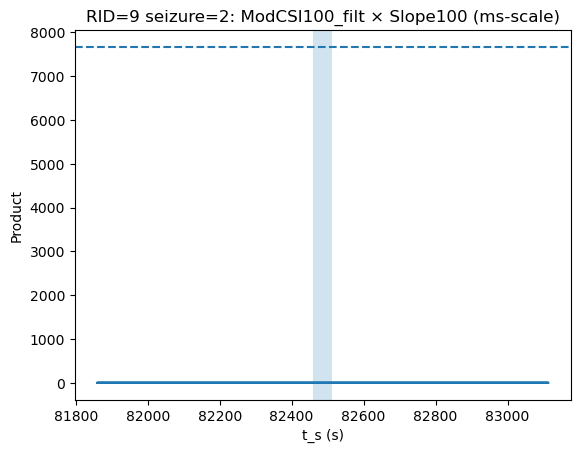

In [120]:
# vælg rid=9, rr_source="labview"
g = df_feat2[(df_feat2["recording_uid"]==9) & (df_feat2["rr_source"]=="labview")].copy()
print("thr:", g["thr_modcsi"].iloc[0])
print("max prod:", g["ModCSI_x_Slope"].max())
print("frac>thr:", np.mean(g["ModCSI_x_Slope"] > g["thr_modcsi"]))

# hvis du vil se om det overhovedet krydser threshold i nærheden af seizure:
s = df_seiz[(df_seiz["recording_uid"]==9) & (df_seiz["seizure_id"]==2)].iloc[0]
t0, t1 = float(s["t0_clinical"]), float(s["t1_clinical"])
zoom = 600
gg = g[(g["t_s"] >= t0-zoom) & (g["t_s"] <= t1+zoom)]

import matplotlib.pyplot as plt
plt.figure()
plt.plot(gg["t_s"], gg["ModCSI_x_Slope"])
plt.axhline(g["thr_modcsi"].iloc[0], linestyle="--")
plt.axvspan(t0, t1, alpha=0.2)
plt.title("RID=9 seizure=2: ModCSI100_filt × Slope100 (ms-scale)")
plt.xlabel("t_s (s)")
plt.ylabel("Product")
plt.show()


In [123]:
from pathlib import Path
import pandas as pd
import numpy as np

p = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim\P07_R01_neurokit_rr_aligned.csv")  # <- brug din rigtige fil
df_rr = pd.read_csv(p)

x = pd.to_numeric(df_rr["RR_labview_s"], errors="coerce").dropna().to_numpy()

print("median:", np.median(x))
print("p5..p95:", np.quantile(x, [0.05,0.95]))
print("min/max:", np.min(x), np.max(x))


median: 1.081767559051514
p5..p95: [0.69256979 1.39478374]
min/max: 0.2575941085815429 2.1335949897766118


In [124]:
import numpy as np

def normalize_rr_to_seconds(rr: np.ndarray) -> np.ndarray:
    rr = np.asarray(rr, float)
    rr = rr[np.isfinite(rr)]

    if rr.size == 0:
        return rr

    med = float(np.median(rr))

    # Heuristik:
    # - Hvis median er 100..3000 => sandsynligvis ms => /1000
    # - Hvis median er <0.02 => sandsynligvis sek/1000 => *1000
    # - Ellers antag sekunder
    if 100.0 <= med <= 3000.0:
        rr_s = rr / 1000.0
        scale = "ms -> s (/1000)"
    elif med < 0.02:
        rr_s = rr * 1000.0
        scale = "s/1000 -> s (*1000)"
    else:
        rr_s = rr
        scale = "already seconds"

    # fjern tydelige garbage værdier efter skalering
    rr_s = rr_s[(rr_s > 0.05) & (rr_s < 5.0)]
    # debug-print (kan slås fra senere)
    print(f"[normalize_rr_to_seconds] median={med:.6g}, scale={scale}, kept={rr_s.size}")
    return rr_s



In [125]:
g = df_feat2[(df_feat2["recording_uid"]==9) & (df_feat2["rr_source"]=="labview")].copy()
print(g[["ModCSI","ModCSI_filt","Slope","ModCSI_x_Slope","thr_modcsi"]].describe(percentiles=[0.9,0.95,0.99,0.999]))
print("thr:", g["thr_modcsi"].iloc[0])
print("max prod:", g["ModCSI_x_Slope"].max())
print("frac>thr:", np.mean(g["ModCSI_x_Slope"] > g["thr_modcsi"]))


KeyError: "['ModCSI_filt'] not in index"

In [4]:
from __future__ import annotations

import re
from pathlib import Path
import numpy as np
import pandas as pd


# ----------------------------
# 0) Build windows_df (SQI + seizure overlap)
# ----------------------------
def add_is_acceptable(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in ["is_flatline", "is_noiseburst", "is_clipping"]:
        out[c] = out[c].astype(bool)
    out["is_acceptable"] = ~(out["is_flatline"] | out["is_noiseburst"] | out["is_clipping"])
    return out

def build_windows_df(df_rec: pd.DataFrame, df_seiz: pd.DataFrame, df_winq: pd.DataFrame, *, axis="clinical") -> pd.DataFrame:
    t0c = f"t0_{axis}"
    t1c = f"t1_{axis}"

    df = (
        df_winq
        .merge(df_rec, on=["recording_uid", "patient_id", "recording_id"], how="left")
        .merge(df_seiz, on=["recording_uid", "patient_id", "recording_id"], how="left", suffixes=("", "_seiz"))
    )
    df = add_is_acceptable(df)

    df["window_overlaps_seizure"] = (
        (df["win_end_s"] > df[t0c]) &
        (df["win_start_s"] < df[t1c])
    ).fillna(False)

    df = df.drop_duplicates(subset=["recording_uid", "window_idx"]).copy()

    return df[[
        "recording_uid", "window_idx", "win_start_s", "win_end_s",
        "is_acceptable", "window_overlaps_seizure"
    ]]


# ----------------------------
# 1) Parse RR filenames + lookup recording_uid
# ----------------------------
_RX = re.compile(
    r"^P(?P<pid>\d{2})(?P<enr>[a-z]?)_R(?P<rec>\d{2})_(?P<algo>[A-Za-z0-9]+)_rr_aligned\.csv$"
)

def parse_rr_filename(p: Path) -> dict:
    m = _RX.match(p.name)
    if not m:
        raise ValueError(f"Cannot parse filename: {p.name}")
    return {
        "patient_number": int(m.group("pid")),       # 01..43
        "enrollment_id": (m.group("enr") or ""),     # "" or "a"/"b"/...
        "recording_id": int(m.group("rec")),         # 01..xx
        "algo_id": m.group("algo").lower(),
    }

def lookup_recording_uid(meta: dict, df_rec_index: pd.DataFrame) -> int:
    pid = int(meta["patient_number"])
    rec = int(meta["recording_id"])
    enr = str(meta["enrollment_id"] or "")

    cand = df_rec_index.copy()
    cand["enr_norm"] = cand.get("enrollment_id", pd.Series([np.nan]*len(cand))).fillna("").astype(str)

    m = cand[
        (cand["patient_id"].astype(int) == pid) &
        (cand["recording_id"].astype(int) == rec) &
        (cand["enr_norm"] == enr)
    ]
    if len(m) != 1:
        raise KeyError(f"UID lookup failed: pid={pid} enr='{enr}' rec={rec} (n={len(m)})")
    return int(m.iloc[0]["recording_uid"])


# ----------------------------
# 2) RR normalisation (robust mod ms/seconds)
# ----------------------------
def normalize_rr_to_seconds(rr: np.ndarray) -> np.ndarray:
    rr = np.asarray(rr, float)
    rr = rr[np.isfinite(rr)]
    if rr.size == 0:
        return rr

    med = float(np.median(rr))

    # Heuristik: median ~ 300..1500 => ms
    if 100.0 <= med <= 3000.0:
        rr_s = rr / 1000.0
    else:
        rr_s = rr

    rr_s = rr_s[(rr_s > 0.05) & (rr_s < 5.0)]
    return rr_s


# ----------------------------
# 3) Jeppesen-style ModCSI100_filt × Slope100 (MATCH THRESHOLD SCALE)
#    - RR i ms for ModCSI + slope
#    - slope: regression af RR(ms) vs beat-index => ms/beat (abs)
#    - ModCSI: L^2 / T med SD1/SD2 fra RR(ms)
#    - filt: 7-pt moving average på ModCSI (centered-ish)
# ----------------------------
def poincare_sd1_sd2_ms(rr_ms: np.ndarray) -> tuple[float, float]:
    rr_ms = np.asarray(rr_ms, float)
    if rr_ms.size < 3:
        return np.nan, np.nan

    d = np.diff(rr_ms)
    sd_rr = np.std(rr_ms, ddof=1)
    sd_d  = np.std(d, ddof=1)

    sd1 = np.sqrt(0.5) * sd_d
    v = 2.0 * sd_rr**2 - 0.5 * sd_d**2
    sd2 = np.sqrt(v) if v > 0 else np.nan
    return sd1, sd2

def modcsi_from_rr_ms(rr_ms: np.ndarray) -> float:
    sd1, sd2 = poincare_sd1_sd2_ms(rr_ms)
    if not (np.isfinite(sd1) and np.isfinite(sd2)):
        return np.nan
    T = 4.0 * sd1
    L = 4.0 * sd2
    if T <= 0:
        return np.nan
    return (L * L) / T

def slope_rr_ms_per_beat(rr_ms: np.ndarray) -> float:
    rr_ms = np.asarray(rr_ms, float)
    n = rr_ms.size
    if n < 3:
        return np.nan
    x = np.arange(n, dtype=float)
    xm = x.mean()
    denom = np.sum((x - xm) ** 2)
    if denom <= 0:
        return np.nan
    y = rr_ms
    ym = y.mean()
    b = np.sum((x - xm) * (y - ym)) / denom
    return float(abs(b))  # ms/beat

def moving_mean(x: np.ndarray, k: int = 7) -> np.ndarray:
    x = np.asarray(x, float)
    if k <= 1:
        return x.copy()
    ker = np.ones(k, float) / k
    return np.convolve(x, ker, mode="same")

def compute_modcsi100_filt_x_slope(rr_s: np.ndarray, *, win_rr: int = 100, filt_k: int = 7) -> pd.DataFrame:
    rr_s = normalize_rr_to_seconds(rr_s)
    if rr_s.size < win_rr:
        return pd.DataFrame(columns=["t_s","ModCSI","ModCSI_filt","Slope","ModCSI_x_Slope"])

    rr_ms = rr_s * 1000.0
    t_end = np.cumsum(rr_s)

    mod = np.full(rr_s.size, np.nan, float)
    slp = np.full(rr_s.size, np.nan, float)

    for i in range(win_rr - 1, rr_s.size):
        w = rr_ms[i - win_rr + 1 : i + 1]
        mod[i] = modcsi_from_rr_ms(w)
        slp[i] = slope_rr_ms_per_beat(w)

    mod_f = moving_mean(mod, k=filt_k)
    prod = mod_f * slp

    out = pd.DataFrame({
        "i_end": np.arange(rr_s.size, dtype=int),
        "t_s": t_end,
        "ModCSI": mod,
        "ModCSI_filt": mod_f,
        "Slope": slp,
        "ModCSI_x_Slope": prod,
    })
    out = out[out["i_end"] >= (win_rr - 1)].reset_index(drop=True)
    return out


# ----------------------------
# 4) Thresholds (patient-specific)
# ----------------------------
def load_thr_map(THR_XLSX: Path, *, pid_col="Patient number", thr_col="Threshold ModCSI100_filt x slope") -> dict[int, float]:
    thr_df = pd.read_excel(THR_XLSX)
    if pid_col not in thr_df.columns or thr_col not in thr_df.columns:
        raise KeyError(f"Missing columns in threshold sheet. Have={thr_df.columns.tolist()}")
    m = (
        thr_df[[pid_col, thr_col]]
        .dropna()
        .assign(**{pid_col: lambda d: d[pid_col].astype(int)})
        .set_index(pid_col)[thr_col]
        .astype(float)
        .to_dict()
    )
    return m


# ----------------------------
# 5) Map feature points -> SQI windows (per recording, robust)
# ----------------------------
def map_features_to_windows_one_recording(feat: pd.DataFrame, w: pd.DataFrame) -> pd.DataFrame:
    feat = feat.sort_values("t_s").reset_index(drop=True)
    w = w.sort_values("win_start_s").reset_index(drop=True)

    m = pd.merge_asof(
        feat,
        w[["win_start_s","win_end_s","is_acceptable","window_overlaps_seizure"]],
        left_on="t_s",
        right_on="win_start_s",
        direction="backward",
        allow_exact_matches=True,
    )
    m = m[m["t_s"] < m["win_end_s"]].copy()
    return m


# ----------------------------
# 6) Event detection + scoring (patient threshold, refractory, seizure tolerance)
# ----------------------------
def collapse_by_gap_and_refractory(times: np.ndarray, *, gap_s: float = 30.0, refractory_s: float = 300.0) -> np.ndarray:
    if times.size == 0:
        return np.array([], float)
    t = np.sort(times.astype(float))

    # merge threshold crossings into "events"
    starts = [t[0]]
    last = t[0]
    for x in t[1:]:
        if (x - last) > gap_s:
            starts.append(x)
        last = x
    starts = np.asarray(starts, float)

    # refractory
    kept = [starts[0]]
    lastk = starts[0]
    for x in starts[1:]:
        if (x - lastk) >= refractory_s:
            kept.append(x)
            lastk = x
    return np.asarray(kept, float)

def extract_events(g: pd.DataFrame, *, value_col: str, thr: float, use_sqi: bool,
                   gap_s: float = 30.0, refractory_s: float = 300.0) -> np.ndarray:
    gg = g.copy()
    if use_sqi:
        gg = gg[gg["is_acceptable"].astype(bool)]
    gg = gg[["t_s", value_col]].dropna().sort_values("t_s")
    if gg.empty or (not np.isfinite(thr)):
        return np.array([], float)

    crossings = gg.loc[gg[value_col].to_numpy() >= thr, "t_s"].to_numpy(float)
    return collapse_by_gap_and_refractory(crossings, gap_s=gap_s, refractory_s=refractory_s)

def score_events_for_recording(rid: int, g: pd.DataFrame, seiz_rec: pd.DataFrame, *,
                              thr: float, value_col: str, use_sqi: bool,
                              tol_s: float = 300.0) -> dict:
    ev = extract_events(g, value_col=value_col, thr=thr, use_sqi=use_sqi)
    hours = float(g["t_s"].max()) / 3600.0 if (not g.empty and np.isfinite(g["t_s"].max())) else 0.0

    n_seiz_total = int(len(seiz_rec))
    n_seiz_detected = 0

    if n_seiz_total:
        for _, s in seiz_rec.iterrows():
            t0 = float(s["t0_clinical"])
            t1 = float(s["t1_clinical"])
            if ev.size and np.any((ev >= (t0 - tol_s)) & (ev <= (t1 + tol_s))):
                n_seiz_detected += 1

        # FP = events outside ALL expanded seizure intervals
        inside_any = np.zeros(ev.shape[0], dtype=bool)
        for _, s in seiz_rec.iterrows():
            t0 = float(s["t0_clinical"]) - tol_s
            t1 = float(s["t1_clinical"]) + tol_s
            inside_any |= ((ev >= t0) & (ev <= t1))
        fp_events = int((~inside_any).sum())
    else:
        fp_events = int(ev.size)

    return dict(rid=rid, hours=hours, fp_events=fp_events, n_seiz_total=n_seiz_total, n_seiz_detected=n_seiz_detected)


def score_pipeline(df_feat: pd.DataFrame, df_seiz: pd.DataFrame, *, use_sqi: bool, value_col="ModCSI_x_Slope",
                   gap_s=30.0, refractory_s=300.0, tol_s=300.0) -> dict:
    rec_rows = []
    for rid, g in df_feat.groupby("recording_uid", sort=False):
        thr = float(g["thr_modcsi"].dropna().iloc[0]) if g["thr_modcsi"].notna().any() else np.nan
        if not np.isfinite(thr):
            continue

        seiz_rec = df_seiz[df_seiz["recording_uid"] == rid]
        rec_rows.append(score_events_for_recording(
            int(rid), g, seiz_rec, thr=thr, value_col=value_col, use_sqi=use_sqi, tol_s=tol_s
        ))

    if not rec_rows:
        return dict(n_recordings_used=0, n_seiz_total=0, n_seiz_detected=0, recall=np.nan, fp_events=0, far_per_h=np.nan, total_h=0.0)

    r = pd.DataFrame(rec_rows)
    total_h = float(r["hours"].sum())
    fp = int(r["fp_events"].sum())
    n_seiz_total = int(r["n_seiz_total"].sum())
    n_seiz_det = int(r["n_seiz_detected"].sum())
    recall = (n_seiz_det / n_seiz_total) if n_seiz_total else np.nan
    far = (fp / total_h) if total_h > 0 else np.nan

    return dict(
        n_recordings_used=int(r["rid"].nunique()),
        n_seiz_total=n_seiz_total,
        n_seiz_detected=n_seiz_det,
        recall=recall,
        fp_events=fp,
        far_per_h=far,
        total_h=total_h,
    )


# ----------------------------
# 7) MAIN: build df_feat2 (LabVIEW + Python) using patient thresholds
# ----------------------------
def build_features_from_rr_folder(
    rr_dir: Path,
    *,
    df_rec_index: pd.DataFrame,
    windows_df: pd.DataFrame,
    thr_map: dict[int, float],
    rr_source: str,
    rr_col: str,
    algo_keep: set[str] | None = None,
) -> pd.DataFrame:
    windows_by_rid = {rid: g for rid, g in windows_df.groupby("recording_uid", sort=False)}

    rows = []
    for p in sorted(rr_dir.glob("*.csv")):
        meta = parse_rr_filename(p)
        if algo_keep is not None and meta["algo_id"] not in algo_keep:
            continue

        rid = lookup_recording_uid(meta, df_rec_index)
        pid = int(meta["patient_number"])  # 1..43

        df_rr = pd.read_csv(p)
        if rr_col not in df_rr.columns:
            continue

        rr = pd.to_numeric(df_rr[rr_col], errors="coerce").to_numpy()
        feat = compute_modcsi100_filt_x_slope(rr, win_rr=100, filt_k=7)
        if feat.empty:
            continue

        w = windows_by_rid.get(rid, None)
        if w is None or w.empty:
            continue

        feat = map_features_to_windows_one_recording(feat, w)
        if feat.empty:
            continue

        feat["recording_uid"] = int(rid)
        feat["patient_id"] = pid
        feat["algo_id"] = meta["algo_id"]
        feat["rr_source"] = rr_source
        feat["thr_modcsi"] = float(thr_map.get(pid, np.nan))

        feat["group"] = np.where(feat["window_overlaps_seizure"], "seizure", "baseline")
        rows.append(feat)

    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()



In [135]:

# ============================
# RUN (du sætter dine paths her)
# ============================
TRIM_DIR = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim")
THR_XLSX = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Threshold values.xlsx")

windows_df = build_windows_df(df_rec, df_seiz, df_winq, axis="clinical")
thr_map = load_thr_map(THR_XLSX)

ALGO_KEEP = {"neurokit","hamilton2002","pantompkins1985","emrich2023"}  # justér

ALGO_KEEP_PILOT = {"neurokit"}  # kun én metode

import numpy as np

from time import perf_counter

def ensure_patient_number(df_rec_index: pd.DataFrame) -> pd.DataFrame:
    out = df_rec_index.copy()
    pid = out["patient_id"].astype(int)

    # Hvis der findes 0, antager vi 0-indeksering og laver patient_number = patient_id + 1
    if pid.min() == 0:
        out["patient_number"] = pid + 1
    else:
        out["patient_number"] = pid

    return out

def lookup_recording_uid(meta: dict, df_rec_index: pd.DataFrame) -> int:
    pid = int(meta["patient_number"])          # 1..43 fra filnavn
    enr = meta.get("enrollment_id", "") or ""  # '' / 'b' / 'c'
    rec_from_name = int(meta["recording_id"])  # fx 1 for R01

    cand = df_rec_index.copy()
    cand["enrollment_id"] = cand["enrollment_id"].fillna("").astype(str)
    cand["patient_id"] = cand["patient_id"].astype(int)
    cand["recording_id"] = cand["recording_id"].astype(int)

    # match på patient + enrollment først
    base = cand[
        (cand["patient_id"] == pid) &
        (cand["enrollment_id"] == enr)
    ]

    # prøv rec som 1-indekseret (R01->1), og hvis ikke: 0-indekseret (R01->0)
    for rec_try in (rec_from_name, rec_from_name - 1):
        m = base[base["recording_id"] == rec_try]
        if len(m) == 1:
            return int(m.iloc[0]["recording_uid"])

    # hvis stadig ikke fundet: smid en mere informativ fejl
    raise KeyError(
        f"UID lookup failed: pid={pid} enr='{enr}' rec_from_name={rec_from_name} "
        f"(tried recording_id={rec_from_name} and {rec_from_name-1}); "
        f"available recording_id for this pid/enr: {sorted(base['recording_id'].unique().tolist())}"
    )

def build_features_from_rr_folder(
    rr_dir: Path,
    *,
    df_rec_index: pd.DataFrame,
    windows_df: pd.DataFrame,
    thr_map: dict[int, float],
    rr_source: str,
    rr_col: str,
    algo_keep: set[str] | None = None,
    patient_allowlist: set[int] | None = None,   # <-- NYT
) -> pd.DataFrame:
    # NORMALISÉR index (NaN enrollment -> "")
    rec_index = df_rec_index.copy()
    rec_index["enrollment_id"] = rec_index["enrollment_id"].fillna("").astype(str)
    rec_index["patient_id"] = rec_index["patient_id"].astype(int)
    rec_index["recording_id"] = rec_index["recording_id"].astype(int)

    windows_by_rid = {rid: g for rid, g in windows_df.groupby("recording_uid", sort=False)}

    rows = []
    for p in sorted(rr_dir.glob("*.csv")):
        meta = parse_rr_filename(p)

        # 1) FILTER på patient før lookup (så pilot ikke crasher på andre patienter)
        pid = int(meta["patient_number"])
        if patient_allowlist is not None and pid not in patient_allowlist:
            continue

        # 2) FILTER på algo
        if algo_keep is not None and meta["algo_id"] not in algo_keep:
            continue

        rid = lookup_recording_uid(meta, rec_index)

        df_rr = pd.read_csv(p)
        if rr_col not in df_rr.columns:
            continue

        rr = pd.to_numeric(df_rr[rr_col], errors="coerce").to_numpy()
        feat = compute_modcsi100_filt_x_slope(rr, win_rr=100, filt_k=7)
        if feat.empty:
            continue

        w = windows_by_rid.get(rid, None)
        if w is None or w.empty:
            continue

        feat = map_features_to_windows_one_recording(feat, w)
        if feat.empty:
            continue

        feat["recording_uid"] = int(rid)
        feat["patient_id"] = pid
        feat["algo_id"] = meta["algo_id"]
        feat["rr_source"] = rr_source
        feat["thr_modcsi"] = float(thr_map.get(pid, np.nan))
        feat["group"] = np.where(feat["window_overlaps_seizure"], "seizure", "baseline")

        rows.append(feat)

    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()



from time import perf_counter

PILOT_PIDS = {7}
ALGO_KEEP_PILOT = {"neurokit","hamilton2002"}  # hurtig pilot

t0 = perf_counter()
feat_lab_pilot = build_features_from_rr_folder(
    TRIM_DIR,
    df_rec_index=df_rec,            # du kan bruge fuld df_rec nu
    windows_df=windows_df,          # fuld windows ok
    thr_map=thr_map,
    rr_source="labview",
    rr_col="RR_labview_s",
    algo_keep=ALGO_KEEP_PILOT,
    patient_allowlist=PILOT_PIDS,
)
feat_py_pilot = build_features_from_rr_folder(
    TRIM_DIR,
    df_rec_index=df_rec,
    windows_df=windows_df,
    thr_map=thr_map,
    rr_source="python",
    rr_col="RR_python_s",
    algo_keep=ALGO_KEEP_PILOT,
    patient_allowlist=PILOT_PIDS,
)
df_feat2_pilot = pd.concat([feat_lab_pilot, feat_py_pilot], ignore_index=True)
t1 = perf_counter()

print(f"Pilot rows={len(df_feat2_pilot):,} time={(t1-t0):.2f}s")
print("Pilot patients:", sorted(df_feat2_pilot["patient_id"].unique().tolist()))
print("Pilot recordings:", df_feat2_pilot["recording_uid"].nunique())


# # vælg fx 5 patienter (1..43)
# PILOT_PIDS = {1, 2}

# df_rec2 = ensure_patient_number(df_rec)

# # Pilot vælges i patient_number (matcher Pxx i filnavne)

# df_rec_pilot = df_rec2[df_rec2["patient_number"].isin(PILOT_PIDS)].copy()

# # Windows subset (samme recording_uid domæne)
# windows_df_pilot = windows_df[windows_df["recording_uid"].isin(df_rec_pilot["recording_uid"])].copy()

# # (valgfrit) tilsvarende mini seizure df (ikke strengt nødvendigt for feature build)
# df_seiz_pilot = df_seiz[df_seiz["patient_id"].isin(PILOT_PIDS)].copy()

# print("df_rec patient_id min/max:", df_rec["patient_id"].astype(int).min(), df_rec["patient_id"].astype(int).max())
# print("df_rec2 patient_number min/max:", df_rec2["patient_number"].astype(int).min(), df_rec2["patient_number"].astype(int).max())

# print(df_rec[df_rec["patient_id"] == 3][["patient_id","enrollment_id","recording_id","recording_uid"]]
#       .sort_values("recording_id"))


# t0 = perf_counter()
# feat_lab_pilot = build_features_from_rr_folder(
#     TRIM_DIR, df_rec_index=df_rec_pilot, windows_df=windows_df_pilot, thr_map=thr_map,
#     rr_source="labview", rr_col="RR_labview_s", algo_keep=ALGO_KEEP_PILOT
# )
# feat_py_pilot = build_features_from_rr_folder(
#     TRIM_DIR, df_rec_index=df_rec_pilot, windows_df=windows_df_pilot, thr_map=thr_map,
#     rr_source="python", rr_col="RR_python_s", algo_keep=ALGO_KEEP_PILOT
# )
# df_feat2_pilot = pd.concat([feat_lab_pilot, feat_py_pilot], ignore_index=True)
# t1 = perf_counter()

# print(f"Pilot rows={len(df_feat2_pilot):,}  time={(t1-t0):.2f} s")
# print("Pilot unique recordings:", df_feat2_pilot["recording_uid"].nunique())
# print("Pilot unique patients:", df_feat2_pilot["patient_id"].nunique())


Pilot rows=1,000,717 time=28.78s
Pilot patients: [7]
Pilot recordings: 2


In [138]:
print(df_feat2_pilot.columns)
print(df_feat2_pilot[df_feat2_pilot["recording_uid"]==9][["t_s","ModCSI","Slope","ModCSI_x_Slope","thr_modcsi"]].describe())


Index(['i_end', 't_s', 'ModCSI', 'ModCSI_filt', 'Slope', 'ModCSI_x_Slope',
       'win_start_s', 'win_end_s', 'is_acceptable', 'window_overlaps_seizure',
       'recording_uid', 'patient_id', 'algo_id', 'rr_source', 'thr_modcsi',
       'group'],
      dtype='object')
                 t_s         ModCSI          Slope  ModCSI_x_Slope  \
count  658256.000000  658256.000000  658256.000000   658244.000000   
mean    89556.074356    1492.875180       0.829890     2105.182456   
std     51171.200262    1363.056439       0.900432     5060.114360   
min       122.208984      11.985340       0.000000        0.000000   
25%     45515.430664     700.343871       0.220992      158.414409   
50%     89419.078683    1122.041264       0.523072      543.382936   
75%    132464.183001    1775.091047       1.105446     1707.233703   
max    178192.143919   16873.440225       7.589130   105578.570374   

         thr_modcsi  
count  6.582560e+05  
mean   7.668270e+03  
std    5.329643e-08  
min    7.668

In [140]:
def plot_reference_modcsi(df_feat, df_seiz, rid, seizure_id, *, zoom_s=900):
    import matplotlib.pyplot as plt

    g = df_feat[df_feat["recording_uid"] == rid].copy()
    s = df_seiz[
        (df_seiz["recording_uid"] == rid) &
        (df_seiz["seizure_id"] == seizure_id)
    ].iloc[0]

    t0, t1 = float(s["t0_clinical"]), float(s["t1_clinical"])
    thr = g["thr_modcsi"].iloc[0]

    # Zoom window
    tmin = max(g["t_s"].min(), t0 - zoom_s)
    tmax = min(g["t_s"].max(), t1 + zoom_s)
    g = g[(g["t_s"] >= tmin) & (g["t_s"] <= tmax)]

    fig, ax = plt.subplots(figsize=(12, 4))

    # Plot product
    ax.plot(
        g["t_s"], g["ModCSI_x_Slope"],
        color="tab:blue", lw=1.2, label="ModCSI × Slope"
    )

    # Threshold
    ax.axhline(
        thr, color="red", ls="--", lw=1.5,
        label="Patient threshold"
    )

    # Seizure shading
    ax.axvspan(t0, t1, color="gray", alpha=0.25, label="Seizure")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("ModCSI × Slope")
    ax.legend(loc="upper right")
    ax.set_title(f"RID {rid} – Seizure {seizure_id} (LabVIEW RR)")

    plt.tight_layout()
    plt.show()


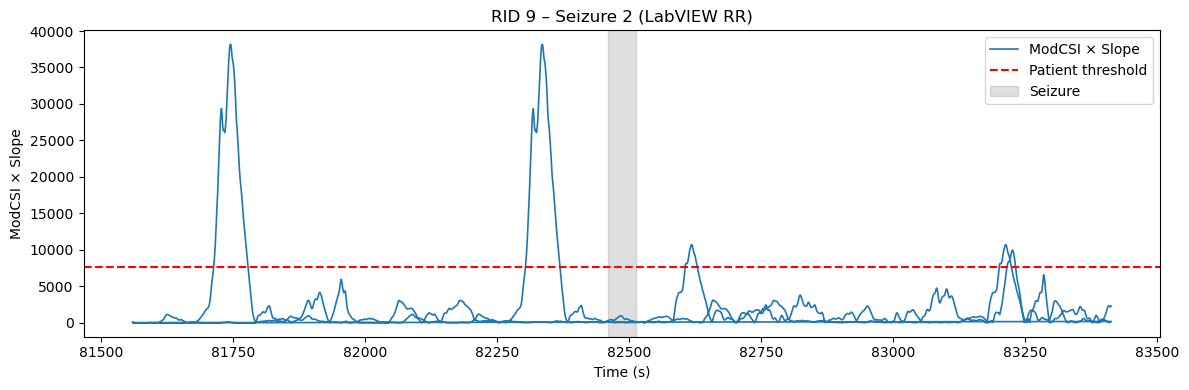

In [141]:
plot_reference_modcsi(
    df_feat2_pilot[df_feat2_pilot["rr_source"] == "labview"],
    df_seiz,
    rid=9,
    seizure_id=2
)


In [142]:
import numpy as np
import pandas as pd

def detect_events_from_timeseries(
    g: pd.DataFrame,
    *,
    t_col="t_s",
    value_col="ModCSI_x_Slope",
    thr_col="thr_modcsi",
    max_gap_s=60.0,      # merge spikes within 60s
    min_event_s=30.0,    # ignore very short excursions
    refractory_s=300.0,  # count at most 1 event per 5 min
):
    g = g.sort_values(t_col).copy()
    thr = float(g[thr_col].iloc[0])
    above = g[value_col].values > thr
    t = g[t_col].values

    idx = np.where(above)[0]
    if len(idx) == 0:
        return pd.DataFrame(columns=["t_start","t_end","duration_s","t_peak","peak_value"])

    # split into groups when time gap between consecutive above-points exceeds max_gap_s
    splits = np.where(np.diff(t[idx]) > max_gap_s)[0] + 1
    groups = np.split(idx, splits)

    events = []
    for grp in groups:
        t_start = float(t[grp[0]])
        t_end   = float(t[grp[-1]])
        dur = t_end - t_start
        if dur < min_event_s:
            continue

        # peak within event
        vals = g.iloc[grp][value_col].values
        k = int(np.argmax(vals))
        t_peak = float(t[grp[k]])
        peak_val = float(vals[k])

        events.append((t_start, t_end, dur, t_peak, peak_val))

    ev = pd.DataFrame(events, columns=["t_start","t_end","duration_s","t_peak","peak_value"])
    if ev.empty:
        return ev

    # refractory: keep earliest peak, drop events too close after previous kept peak
    ev = ev.sort_values("t_peak").reset_index(drop=True)
    keep = []
    last = -np.inf
    for i, r in ev.iterrows():
        if r["t_peak"] - last >= refractory_s:
            keep.append(True)
            last = r["t_peak"]
        else:
            keep.append(False)
    return ev.loc[keep].reset_index(drop=True)


In [143]:
g = df_feat2[(df_feat2["recording_uid"]==9) & (df_feat2["rr_source"]=="labview")].copy()
ev = detect_events_from_timeseries(g)
ev


,t_start,t_end,duration_s,t_peak,peak_value


In [146]:
frac_above = (g["ModCSI_x_Slope"] > g["thr_modcsi"].iloc[0]).mean()
print("Fraction of points above threshold:", frac_above)
print("n points:", len(g))
print("n events:", len(ev))


Fraction of points above threshold: 0.0
n points: 424919
n events: 0


In [147]:
val = "ModCSI_x_Slope"   # eller den du mener er “rigtig”
print("thr:", g["thr_modcsi"].iloc[0])
print("max:", g[val].max())
print("p99:", g[val].quantile(0.99))
print("frac>thr:", (g[val] > g["thr_modcsi"].iloc[0]).mean())
print(g[[val]].describe(percentiles=[0.9,0.95,0.99,0.999]))


thr: 7668.27
max: 0.20915093133497634
p99: 0.0468158119341534
frac>thr: 0.0
       ModCSI_x_Slope
count    4.249190e+05
mean     3.664025e-03
std      9.742613e-03
min      2.512833e-10
50%      6.930767e-04
90%      8.936779e-03
95%      1.760096e-02
99%      4.681581e-02
99.9%    1.108635e-01
max      2.091509e-01


In [148]:

# # ============================
# # RUN (du sætter dine paths her)
# # ============================
# TRIM_DIR = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim")
# THR_XLSX = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Threshold values.xlsx")

# windows_df = build_windows_df(df_rec, df_seiz, df_winq, axis="clinical")
# thr_map = load_thr_map(THR_XLSX)

# ALGO_KEEP = {"neurokit","hamilton2002","pantompkins1985","emrich2023"}  # justér


# feat_lab = build_features_from_rr_folder(
#     TRIM_DIR, df_rec_index=df_rec, windows_df=windows_df, thr_map=thr_map,
#     rr_source="labview", rr_col="RR_labview_s", algo_keep=ALGO_KEEP
# )
# feat_py = build_features_from_rr_folder(
#     TRIM_DIR, df_rec_index=df_rec, windows_df=windows_df, thr_map=thr_map,
#     rr_source="python", rr_col="RR_python_s", algo_keep=ALGO_KEEP
# )
# df_feat2 = pd.concat([feat_lab, feat_py], ignore_index=True)

# print("Sanity: frac points > thr:", float(np.nanmean(df_feat2["ModCSI_x_Slope"] > df_feat2["thr_modcsi"])))

# # Main table
# rows = []
# for (rr_source, algo), g in df_feat2.groupby(["rr_source","algo_id"], sort=False):
#     for use_sqi in [False, True]:
#         res = score_pipeline(g, df_seiz, use_sqi=use_sqi, value_col="ModCSI_x_Slope", tol_s=300.0)
#         rows.append({
#             "RR_source": rr_source,
#             "Algorithm": algo,
#             "SQI": "on" if use_sqi else "off",
#             **res
#         })
# df_main = pd.DataFrame(rows).sort_values(["RR_source","Algorithm","SQI"]).reset_index(drop=True)
# display(df_main)

import numpy as np
import pandas as pd

# ---------- Core feature math ----------

def _rolling_linreg_slope(y: np.ndarray, win: int) -> np.ndarray:
    """
    Slope of y vs index within each rolling window (least squares).
    Returns slope at window end; first win-1 are NaN.
    """
    n = len(y)
    out = np.full(n, np.nan, dtype=float)
    if n < win:
        return out

    x = np.arange(win, dtype=float)
    x_mean = x.mean()
    x_demean = x - x_mean
    denom = np.sum(x_demean**2)

    for i in range(win - 1, n):
        yy = y[i - win + 1 : i + 1]
        if np.any(~np.isfinite(yy)):
            continue
        y_mean = yy.mean()
        num = np.sum((yy - y_mean) * x_demean)
        out[i] = num / denom  # units: (units of y) per beat
    return out


def compute_modcsi100_ms(rr_ms: np.ndarray, win: int = 100) -> pd.DataFrame:
    """
    Compute Modified CSI = L^2 / T using Poincaré SD1/SD2 on RR in milliseconds.
    Value assigned at window end index i_end.
    """
    rr_ms = np.asarray(rr_ms, float)
    n = len(rr_ms)
    ModCSI = np.full(n, np.nan, float)
    T = np.full(n, np.nan, float)
    L = np.full(n, np.nan, float)

    if n < win + 1:
        return pd.DataFrame({"i_end": np.arange(n), "ModCSI": ModCSI, "T": T, "L": L})

    for i in range(win - 1, n):
        seg = rr_ms[i - win + 1 : i + 1]
        if np.any(~np.isfinite(seg)):
            continue
        d = np.diff(seg)
        sd_rr = np.std(seg, ddof=1) if win > 1 else np.nan
        sd_d  = np.std(d, ddof=1) if win > 2 else np.nan

        # SD1/SD2 (standard Poincaré relations)
        sd1 = np.sqrt(0.5) * sd_d
        # guard small negatives due to numerical issues:
        tmp = max(0.0, 2.0 * sd_rr**2 - 0.5 * sd_d**2)
        sd2 = np.sqrt(tmp)

        T_i = 4.0 * sd1
        L_i = 4.0 * sd2

        # Modified CSI = (L^2)/T
        if T_i > 0:
            ModCSI[i] = (L_i**2) / T_i
            T[i] = T_i
            L[i] = L_i

    return pd.DataFrame({"i_end": np.arange(n), "ModCSI": ModCSI, "T": T, "L": L})


def add_time_axis_from_rr(rr_s: np.ndarray) -> np.ndarray:
    """Time-at-beat-end in seconds (cumulative sum of RR)."""
    rr_s = np.asarray(rr_s, float)
    t_s = np.cumsum(rr_s)
    return t_s


def build_modcsi_pipeline_from_rr(
    rr_s: np.ndarray,
    *,
    win_rr: int = 100,
    ma_win: int = 7,
) -> pd.DataFrame:
    """
    Returns dataframe with:
      t_s (sec), ModCSI_ms, ModCSI_filt_ms, RR_slope_ms_per_beat, ModCSIxSlope_ms
    """
    rr_s = np.asarray(rr_s, float)
    rr_ms = rr_s * 1000.0
    t_s = add_time_axis_from_rr(rr_s)

    feat = compute_modcsi100_ms(rr_ms, win=win_rr)
    feat["t_s"] = t_s

    # MA7 filter on ModCSI (ms-scale)
    feat["ModCSI_ms"] = feat["ModCSI"]
    feat["ModCSI_filt_ms"] = (
        pd.Series(feat["ModCSI_ms"]).rolling(ma_win, min_periods=1).mean().to_numpy()
    )

    # Slope of RR (ms/beat) over last 100 beats (same win as ModCSI)
    feat["RR_slope_ms_per_beat"] = _rolling_linreg_slope(rr_ms, win=win_rr)

    # Product (ms-scale)
    feat["ModCSIxSlope_ms"] = feat["ModCSI_filt_ms"] * feat["RR_slope_ms_per_beat"]

    return feat


# ---------- SQI mapping (window-based) ----------

def map_points_to_windows(points: pd.DataFrame, windows_df: pd.DataFrame) -> pd.DataFrame:
    """
    Map each feature point (t_s) to window acceptance + seizure-overlap, via searchsorted per recording.
    Requires windows_df columns: recording_uid, win_start_s, win_end_s, is_acceptable, window_overlaps_seizure
    Requires points columns: recording_uid, t_s
    """
    w = windows_df.drop_duplicates(["recording_uid", "window_idx"]).copy()
    w = w.sort_values(["recording_uid", "win_start_s"]).reset_index(drop=True)

    p = points.copy()
    p = p.sort_values(["recording_uid", "t_s"]).reset_index(drop=True)

    out_rows = []
    for rid, g in p.groupby("recording_uid", sort=False):
        ww = w[w["recording_uid"] == rid]
        if ww.empty:
            gg = g.copy()
            gg["is_acceptable"] = True
            gg["window_overlaps_seizure"] = False
            out_rows.append(gg)
            continue

        starts = ww["win_start_s"].to_numpy(float)
        ends   = ww["win_end_s"].to_numpy(float)

        idx = np.searchsorted(starts, g["t_s"].to_numpy(float), side="right") - 1
        idx = np.clip(idx, 0, len(ww) - 1)

        gg = g.copy()
        gg["win_start_s"] = starts[idx]
        gg["win_end_s"]   = ends[idx]

        inside = gg["t_s"].to_numpy(float) < gg["win_end_s"].to_numpy(float)
        gg = gg.loc[inside].copy()

        ww_take = ww.iloc[idx].reset_index(drop=True)
        ww_take = ww_take.loc[inside].reset_index(drop=True)
        gg = gg.reset_index(drop=True)

        gg["is_acceptable"] = ww_take["is_acceptable"].to_numpy(bool)
        gg["window_overlaps_seizure"] = ww_take["window_overlaps_seizure"].to_numpy(bool)

        out_rows.append(gg)

    return pd.concat(out_rows, ignore_index=True) if out_rows else p


# ---------- Event detection + scoring ----------

def detect_events_from_series(t: np.ndarray, x: np.ndarray, thr: float, *, max_gap_s: float = 300.0):
    """
    Turn threshold crossings into events (clusters) based on time gap <= max_gap_s.
    Returns list of dicts with t_start, t_end, t_peak, peak_value, duration_s.
    """
    t = np.asarray(t, float)
    x = np.asarray(x, float)
    above = np.isfinite(x) & (x >= thr)
    idx = np.where(above)[0]
    if idx.size == 0:
        return []

    events = []
    start = idx[0]
    prev = idx[0]
    for i in idx[1:]:
        if (t[i] - t[prev]) > max_gap_s:
            seg = np.arange(start, prev + 1)
            peak_i = seg[np.nanargmax(x[seg])]
            events.append(dict(
                t_start=float(t[start]),
                t_end=float(t[prev]),
                duration_s=float(t[prev] - t[start]),
                t_peak=float(t[peak_i]),
                peak_value=float(x[peak_i]),
            ))
            start = i
        prev = i

    seg = np.arange(start, prev + 1)
    peak_i = seg[np.nanargmax(x[seg])]
    events.append(dict(
        t_start=float(t[start]),
        t_end=float(t[prev]),
        duration_s=float(t[prev] - t[start]),
        t_peak=float(t[peak_i]),
        peak_value=float(x[peak_i]),
    ))
    return events


def score_events_against_seizures(
    feat_points: pd.DataFrame,
    df_seiz: pd.DataFrame,
    *,
    value_col: str,
    thr_map: dict,
    use_sqi: bool,
    seizure_axis: str = "clinical",
    match_margin_s: float = 300.0,   # ±5 min
    max_gap_s: float = 300.0,        # event clustering gap
) -> dict:
    """
    Event-based scoring across ALL recordings (including those without seizures for FAR).
    - One event = cluster of points above threshold.
    - Seizure detected if any event peak is within [t0-margin, t1+margin].
    - FP events = events that do not match any seizure interval.
    """
    start_col = f"t0_{seizure_axis}" if f"t0_{seizure_axis}" in df_seiz.columns else "t0"
    end_col   = f"t1_{seizure_axis}" if f"t1_{seizure_axis}" in df_seiz.columns else "t1"

    stream = feat_points.copy()
    if use_sqi:
        stream = stream[stream["is_acceptable"]].copy()

    n_seiz_total = 0
    n_seiz_detected = 0
    fp_events = 0
    total_h = 0.0

    # Pre-group seizures by recording for speed
    seiz_by_rid = {rid: g.copy() for rid, g in df_seiz.groupby("recording_uid", sort=False)}

    for rid, g in stream.groupby("recording_uid", sort=False):
        g = g.sort_values("t_s")
        if g.empty:
            continue

        # FAR denominator: duration covered by feature stream
        total_h += (float(g["t_s"].max()) / 3600.0)

        pid = int(g["patient_id"].iloc[0]) if "patient_id" in g.columns else None
        thr = float(thr_map.get(pid, np.nan))
        if not np.isfinite(thr):
            continue

        events = detect_events_from_series(
            t=g["t_s"].to_numpy(float),
            x=g[value_col].to_numpy(float),
            thr=thr,
            max_gap_s=max_gap_s
        )

        seiz = seiz_by_rid.get(rid, None)

        if seiz is not None and not seiz.empty:
            # Seizure recall
            for _, s in seiz.iterrows():
                n_seiz_total += 1
                t0 = float(s[start_col])
                t1 = float(s[end_col])
                lo = t0 - match_margin_s
                hi = t1 + match_margin_s

                hit = any((ev["t_peak"] >= lo) and (ev["t_peak"] <= hi) for ev in events)
                if hit:
                    n_seiz_detected += 1

            # FP = events not matching any seizure window
            for ev in events:
                inside_any = False
                for _, s in seiz.iterrows():
                    lo = float(s[start_col]) - match_margin_s
                    hi = float(s[end_col]) + match_margin_s
                    if (ev["t_peak"] >= lo) and (ev["t_peak"] <= hi):
                        inside_any = True
                        break
                if not inside_any:
                    fp_events += 1
        else:
            # No seizures in this recording: ALL events are FP events
            fp_events += len(events)

    recall = (n_seiz_detected / n_seiz_total) if n_seiz_total else np.nan
    far_per_h = (fp_events / total_h) if total_h > 0 else np.nan

    return dict(
        n_seiz_total=n_seiz_total,
        n_seiz_detected=n_seiz_detected,
        recall=recall,
        fp_events=fp_events,
        far_per_h=far_per_h,
        total_h=total_h
    )


In [149]:
# eksempel: rr_s = df_rr["RR_labview_s"].values
feat = build_modcsi_pipeline_from_rr(rr_s, win_rr=100, ma_win=7)

# sanity: sammenlign mod threshold
thr = thr_map_modcsi[7]  # patient 7 -> rid=9 i dit eksempel
print("thr:", thr)
print("max product:", np.nanmax(feat["ModCSIxSlope_ms"]))
print("frac>thr:", np.nanmean(feat["ModCSIxSlope_ms"] > thr))


thr: 7668.27
max product: 105759.63732565776
frac>thr: 0.03461457041763692


In [154]:
df_feat2.columns

Index(['t_s', 'ModCSI', 'Slope', 'ModCSI_x_Slope', 'recording_uid', 'algo_id',
       'set', 'rr_source', 'win_rr', 'prefilter', 'win_start_s', 'win_end_s',
       'is_acceptable', 'window_overlaps_seizure', 'group', 'q', 'patient_id',
       'thr_modcsi'],
      dtype='object')

In [155]:
df_feat2_pilot.columns

Index(['i_end', 't_s', 'ModCSI', 'ModCSI_filt', 'Slope', 'ModCSI_x_Slope',
       'win_start_s', 'win_end_s', 'is_acceptable', 'window_overlaps_seizure',
       'recording_uid', 'patient_id', 'algo_id', 'rr_source', 'thr_modcsi',
       'group'],
      dtype='object')

In [157]:
df_feat = df_feat2_pilot.copy()

df_feat = df_feat.rename(columns={
    "ModCSI": "ModCSI_ms",
    "ModCSI_filt": "ModCSI_filt_ms",
    "Slope": "RR_slope_ms_per_beat",
    "ModCSI_x_Slope": "ModCSIxSlope_ms"
})

REQUIRED = {
    "t_s",
    "recording_uid",
    "patient_id",
    "ModCSIxSlope_ms",
    "thr_modcsi"
}

missing = REQUIRED - set(df_feat.columns)
if missing:
    raise RuntimeError(
        f"Study 5 requires MS-scale features. Missing: {missing}"
    )


In [150]:
# after you have df_feat2 with recording_uid, patient_id, t_s, ModCSIxSlope_ms ...
df_feat2 = map_points_to_windows(df_feat2, windows_df)

res_off = score_events_against_seizures(
    feat_points=df_feat2,
    df_seiz=df_seiz,
    value_col="ModCSIxSlope_ms",
    thr_map=thr_map_modcsi,
    use_sqi=False,
    match_margin_s=300,
    max_gap_s=300,
)
res_on = score_events_against_seizures(
    feat_points=df_feat2,
    df_seiz=df_seiz,
    value_col="ModCSIxSlope_ms",
    thr_map=thr_map_modcsi,
    use_sqi=True,
    match_margin_s=300,
    max_gap_s=300,
)
print(res_off)
print(res_on)


KeyboardInterrupt: 

In [11]:
from __future__ import annotations

import re
from pathlib import Path
from typing import Optional, Iterable, Dict, Tuple, List

import numpy as np
import pandas as pd


# ----------------------------
# 0) Filnavn → meta
# ----------------------------
_RX = re.compile(
    r"^P(?P<pid>\d{2})(?P<enr>[a-z]?)_R(?P<rec>\d{2})_(?P<algo>[^_]+)_rr_aligned\.csv$",
    re.IGNORECASE
)

def parse_rr_filename(p: Path) -> dict:
    m = _RX.match(p.name)
    if not m:
        raise ValueError(f"Cannot parse filename: {p.name}")
    return {
        "patient_number": int(m.group("pid")),              # 1..43
        "enrollment_id": (m.group("enr") or ""),            # "" / "a" / "b" / "c"
        "recording_id": int(m.group("rec")),                # 1..99
        "algo_id": m.group("algo").lower(),
    }


def _norm_enrollment(x) -> str:
    # recordings_index kan have NaN eller "" for "ingen enrollment"
    if x is None:
        return ""
    if isinstance(x, float) and np.isnan(x):
        return ""
    s = str(x).strip()
    if s.lower() == "nan":
        return ""
    return s


def lookup_recording_uid(meta: dict, df_rec_index: pd.DataFrame) -> int:
    """
    Find recording_uid ud fra (patient_id, enrollment_id, recording_id)
    meta: patient_number (1..43), enrollment_id "", "a", "b", "c", recording_id
    df_rec_index: recordings_index.csv loaded
    """
    pid = int(meta["patient_number"])
    enr = _norm_enrollment(meta["enrollment_id"]).lower()
    rec = int(meta["recording_id"])

    cand = df_rec_index.copy()
    # normalisér enrollment
    cand["enrollment_id_norm"] = cand["enrollment_id"].apply(_norm_enrollment).str.lower()

    # match
    m = cand[
        (cand["patient_id"].astype(int) == pid) &
        (cand["enrollment_id_norm"] == enr) &
        (cand["recording_id"].astype(int) == rec)
    ]

    if len(m) != 1:
        # debug-hjælp
        base = cand[(cand["patient_id"].astype(int) == pid) & (cand["enrollment_id_norm"] == enr)]
        raise KeyError(
            f"UID lookup failed: pid={pid} enr='{enr}' rec={rec} (n={len(m)}). "
            f"Available recording_id for this pid/enr: {sorted(base['recording_id'].unique().tolist())}"
        )
    return int(m.iloc[0]["recording_uid"])

import numpy as np
import pandas as pd

def compute_thresholds_105pct_from_early_baseline(
    df_feat: pd.DataFrame,
    *,
    value_col: str,
    time_col: str = "t_s",
    patient_col: str = "patient_id",
    rid_col: str = "recording_uid",
    exclude_seizure_windows: bool = True,
    seiz_flag_col: str = "window_overlaps_seizure",
    # definitions of "early baseline"
    hours_list: tuple[float, ...] = (12.0, 24.0),
    include_half_recording: bool = True,
) -> pd.DataFrame:
    """
    For each (patient_id, recording_uid), compute:
      - max(value_col) within first N hours (t_s <= N*3600)
      - max(value_col) within first half of recording (t_s <= 0.5*max(t_s))
    Then aggregate to patient-level (max across recordings) because Jeppesen threshold is patient-specific.

    Returns a tidy table with per-patient max and 105% thresholds for each definition window.
    """

    need = {patient_col, rid_col, time_col, value_col}
    miss = need - set(df_feat.columns)
    if miss:
        raise KeyError(f"df_feat missing columns: {miss}")

    df = df_feat[[patient_col, rid_col, time_col, value_col] + ([seiz_flag_col] if seiz_flag_col in df_feat.columns else [])].copy()

    # numeric coerce
    df[patient_col] = pd.to_numeric(df[patient_col], errors="coerce")
    df[rid_col] = pd.to_numeric(df[rid_col], errors="coerce")
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")

    df = df.dropna(subset=[patient_col, rid_col, time_col, value_col]).copy()
    df[patient_col] = df[patient_col].astype(int)
    df[rid_col] = df[rid_col].astype(int)

    # Optional: exclude seizure-overlapping windows from baseline threshold estimation
    if exclude_seizure_windows:
        if seiz_flag_col not in df.columns:
            raise KeyError(f"exclude_seizure_windows=True requires column '{seiz_flag_col}' in df_feat")
        df = df[~df[seiz_flag_col].astype(bool)].copy()

    # Per recording duration proxy: max(t_s) (since t_s is cumulative from start)
    dur = df.groupby([patient_col, rid_col], sort=False)[time_col].max().rename("rec_duration_s").reset_index()
    df = df.merge(dur, on=[patient_col, rid_col], how="left")

    out_rows = []

    # --- first N hours
    for h in hours_list:
        cutoff_s = float(h) * 3600.0
        dfx = df[df[time_col] <= cutoff_s].copy()
        if dfx.empty:
            continue

        # max per (patient, recording)
        rec_max = (
            dfx.groupby([patient_col, rid_col], sort=False)[value_col]
            .max()
            .rename("max_value")
            .reset_index()
        )
        rec_max["definition"] = f"first_{int(h)}h"
        out_rows.append(rec_max)

    # --- first half of recording
    if include_half_recording:
        dfx = df[df[time_col] <= 0.5 * df["rec_duration_s"]].copy()
        if not dfx.empty:
            rec_max = (
                dfx.groupby([patient_col, rid_col], sort=False)[value_col]
                .max()
                .rename("max_value")
                .reset_index()
            )
            rec_max["definition"] = "first_half_recording"
            out_rows.append(rec_max)

    if not out_rows:
        return pd.DataFrame(columns=[patient_col, "definition", "max_value_patient", "thr_105pct"])

    rec_max_all = pd.concat(out_rows, ignore_index=True)

    # Patient-specific threshold: take max across that patient's recordings (matches "baseline max" idea)
    patient_max = (
        rec_max_all.groupby([patient_col, "definition"], sort=False)["max_value"]
        .max()
        .rename("max_value_patient")
        .reset_index()
    )
    patient_max["thr_105pct"] = 1.05 * patient_max["max_value_patient"]
    patient_max["value_col"] = value_col

    return patient_max




# ----------------------------
# 1) ModCSI + slope (ms-skala)
# ----------------------------
def rr_median_prefilter_7(rr_ms: np.ndarray) -> np.ndarray:
    rr = np.asarray(rr_ms, float)
    out = np.empty_like(rr)
    for i in range(rr.size):
        j0 = max(0, i - 6)
        out[i] = np.median(rr[j0:i+1])
    return out



# def compute_modcsi_win(rr_ms: np.ndarray, *, win_rr: int = 100) -> np.ndarray:
#     """
#     ModCSI over sliding windows of length win_rr.
#     Uses Poincaré SD1/SD2:
#       SD1 = std(diff)/sqrt(2), SD2 = std(sum)/sqrt(2)
#       T=4*SD1, L=4*SD2, ModCSI = L^2 / T
#     Returns modcsi of length n-win_rr+1, aligned to window END.
#     """
#     rr = np.asarray(rr_ms, float)
#     n = rr.size
#     if n < win_rr:
#         return np.array([], dtype=float)

#     W = np.lib.stride_tricks.sliding_window_view(rr, window_shape=win_rr)
#     x = W[:, :-1]
#     y = W[:, 1:]
#     d = y - x
#     s = y + x

#     sd1 = np.std(d, axis=1, ddof=1) / np.sqrt(2.0)
#     sd2 = np.std(s, axis=1, ddof=1) / np.sqrt(2.0)

#     T = 4.0 * sd1
#     L = 4.0 * sd2
#     modcsi = (L**2) / np.maximum(T, 1e-12)
#     return modcsi

def compute_csi_modcsi_win(rr_ms: np.ndarray, *, win_rr: int = 100) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute CSI and ModCSI over sliding windows of length win_rr.
    Uses Poincaré SD1/SD2:
      SD1 = std(diff)/sqrt(2), SD2 = std(sum)/sqrt(2)
      T = 4*SD1, L = 4*SD2
      CSI = L / T
      ModCSI = L^2 / T
    Returns arrays (csi, modcsi), length n-win_rr+1.
    """
    rr = np.asarray(rr_ms, float)
    n = rr.size
    if n < win_rr:
        return np.array([], dtype=float), np.array([], dtype=float)

    W = np.lib.stride_tricks.sliding_window_view(rr, window_shape=win_rr)
    x = W[:, :-1]
    y = W[:, 1:]
    d = y - x
    s = y + x

    sd1 = np.std(d, axis=1, ddof=1) / np.sqrt(2.0)
    sd2 = np.std(s, axis=1, ddof=1) / np.sqrt(2.0)

    T = 4.0 * sd1
    L = 4.0 * sd2
    T = np.maximum(T, 1e-12)

    csi = L / T
    modcsi = (L**2) / T
    return csi, modcsi



def slope_ls_abs_win(y: np.ndarray, t_s: np.ndarray, *, win_rr: int = 100) -> np.ndarray:
    """
    |Least Squares slope| for y(t) over sliding windows of length win_rr.
    Returns abs slope per window, aligned to window END.
    """
    y = np.asarray(y, float)
    t = np.asarray(t_s, float)
    n = y.size
    if n < win_rr:
        return np.array([], dtype=float)

    W_y = np.lib.stride_tricks.sliding_window_view(y, window_shape=win_rr)
    W_t = np.lib.stride_tricks.sliding_window_view(t, window_shape=win_rr)

    t_mean = W_t.mean(axis=1)
    y_mean = W_y.mean(axis=1)
    t0 = W_t - t_mean[:, None]
    y0 = W_y - y_mean[:, None]

    denom = np.sum(t0**2, axis=1)
    numer = np.sum(t0 * y0, axis=1)
    m = numer / np.where(denom > 0, denom, np.nan)
    return np.abs(m)




# ----------------------------
# 2) Map points → Study4 windows (SQI + seizure overlap)
# ----------------------------
def map_points_to_windows(df_feat: pd.DataFrame, windows_df: pd.DataFrame) -> pd.DataFrame:
    """
    Map feature points (t_s) to Study4 windows without merge_asof.
    Robust against pandas 'keys must be sorted'.
    """
    f = df_feat.copy()
    w = windows_df[["recording_uid","win_start_s","win_end_s","is_acceptable","window_overlaps_seizure"]].copy()

    # enforce dtypes
    f["recording_uid"] = pd.to_numeric(f["recording_uid"], errors="coerce")
    f["t_s"] = pd.to_numeric(f["t_s"], errors="coerce")
    f = f.dropna(subset=["recording_uid","t_s"]).copy()
    f["recording_uid"] = f["recording_uid"].astype(int)

    w["recording_uid"] = pd.to_numeric(w["recording_uid"], errors="coerce")
    w["win_start_s"] = pd.to_numeric(w["win_start_s"], errors="coerce")
    w["win_end_s"] = pd.to_numeric(w["win_end_s"], errors="coerce")
    w = w.dropna(subset=["recording_uid","win_start_s","win_end_s"]).copy()
    w["recording_uid"] = w["recording_uid"].astype(int)

    out_parts = []

    for rid, g in f.groupby("recording_uid", sort=False):
        ww = w[w["recording_uid"] == rid].copy()
        if ww.empty:
            continue

        ww = ww.sort_values("win_start_s", kind="mergesort").reset_index(drop=True)

        starts = ww["win_start_s"].to_numpy(dtype=float)
        ends   = ww["win_end_s"].to_numpy(dtype=float)

        t = g["t_s"].to_numpy(dtype=float)

        # index of last window start <= t
        idx = np.searchsorted(starts, t, side="right") - 1

        # valid indices and inside-window constraint
        ok = (idx >= 0) & (t < ends[np.clip(idx, 0, len(ends)-1)])
        if not np.any(ok):
            continue

        gg = g.iloc[np.where(ok)[0]].copy()
        idx_ok = idx[ok]

        gg["win_start_s"] = starts[idx_ok]
        gg["win_end_s"]   = ends[idx_ok]
        gg["is_acceptable"] = ww["is_acceptable"].to_numpy()[idx_ok]
        gg["window_overlaps_seizure"] = ww["window_overlaps_seizure"].to_numpy()[idx_ok]

        gg["group"] = np.where(gg["window_overlaps_seizure"], "seizure", "baseline")
        gg["q"] = np.where(gg["is_acceptable"], "accepted", "rejected")

        out_parts.append(gg)

    if not out_parts:
        return pd.DataFrame(columns=list(df_feat.columns) + ["win_start_s","win_end_s","is_acceptable","window_overlaps_seizure","group","q"])

    return pd.concat(out_parts, ignore_index=True)





# ----------------------------
# 3) Build features from rr_aligned folder (ONE consistent MS-frame)
# ----------------------------
def build_features_from_rr_folder(
    rr_dir: Path,
    *,
    df_rec_index: pd.DataFrame,
    windows_df: pd.DataFrame,
    thr_map: Dict[int, float],                   # patient_id (1..43) -> threshold
    rr_source: str,                              # "labview" or "python"
    rr_col: str,                                 # "RR_labview_s" or "RR_python_s"
    algo_keep: Optional[set] = None,
    recording_uid_keep: Optional[set] = None,     # e.g. {9} for pilot
    set_label: str = "trim",
    prefilter: bool = True,
    win_rr: int = 100,
) -> pd.DataFrame:

    rows: List[pd.DataFrame] = []

    for p in sorted(rr_dir.glob("*.csv")):
        meta = parse_rr_filename(p)
        algo_id = meta["algo_id"]

        if algo_keep is not None and algo_id not in algo_keep:
            continue

        rid = lookup_recording_uid(meta, df_rec_index)
        if recording_uid_keep is not None and rid not in recording_uid_keep:
            continue

        pid = int(meta["patient_number"])
        thr = float(thr_map.get(pid, np.nan))

        if not np.isfinite(thr):
            # hvis du hellere vil skippe silently, kan du continue
            raise KeyError(f"Missing threshold for patient_id={pid} (needed: ModCSI100_filt x slope)")


        df_rr = pd.read_csv(p)
        if rr_col not in df_rr.columns:
            continue

        rr_s = pd.to_numeric(df_rr[rr_col], errors="coerce").to_numpy(dtype=float)
        rr_s = rr_s[np.isfinite(rr_s)]
        if rr_s.size < win_rr:
            continue

        rr_ms = rr_s * 1000.0

        # time axis at beat ends (seconds)
        t_beats_s = np.cumsum(rr_s)
        i_end = np.arange(win_rr - 1, rr_s.size, dtype=int)
        t_end_s = t_beats_s[i_end]

        # --- Prefilter (ONLY for ModCSI + Slope), not for CSI
        rr_ms_f = rr_median_prefilter_7(rr_ms)

        # --- CSI on UNFILTERED tachogram (Jesper point 3)
        csi_100, _ = compute_csi_modcsi_win(rr_ms, win_rr=win_rr)

        # --- ModCSI on FILTERED tachogram
        _, modcsi_100_f = compute_csi_modcsi_win(rr_ms_f, win_rr=win_rr)

        # --- Slope on PULSE/HR (bpm), computed from FILTERED tachogram (Jesper point 2 + 3)
        rr_s_f = rr_ms_f / 1000.0
        hr_bpm_f = 60.0 / np.maximum(rr_s_f, 1e-6)  # bpm
        slope_hr_bpm_per_s = slope_ls_abs_win(hr_bpm_f, t_beats_s, win_rr=win_rr)

        # --- Products
        prod_modcsi = modcsi_100_f * slope_hr_bpm_per_s
        prod_csi = csi_100 * slope_hr_bpm_per_s

        # --- Align lengths safely
        m = min(t_end_s.size, csi_100.size, modcsi_100_f.size, slope_hr_bpm_per_s.size)
        t_s = t_end_s[:m]
        i_end2 = i_end[:m]
        csi_100 = csi_100[:m]
        modcsi_100_f = modcsi_100_f[:m]
        slope_hr_bpm_per_s = slope_hr_bpm_per_s[:m]
        prod_modcsi = prod_modcsi[:m]
        prod_csi = prod_csi[:m]

        feat = pd.DataFrame({
            "i_end": i_end2,
            "t_s": t_s,

            # Core series (for debugging/plotting)
            "CSI100": csi_100,                         # unfiltered CSI
            "ModCSI100_filt": modcsi_100_f,            # filtered ModCSI
            "SlopeHR100_abs_bpm_per_s": slope_hr_bpm_per_s,  # slope on HR (bpm) based on filtered RR

            # Products
            "CSI100_x_SlopeHR": prod_csi,
            "ModCSI100_filt_x_SlopeHR": prod_modcsi,

            # Keep legacy column name so your scoring code can stay unchanged:
            "ModCSIxSlope_ms": prod_modcsi,

            "recording_uid": rid,
            "patient_id": pid,
            "algo_id": algo_id,
            "rr_source": rr_source,
            "set": set_label,
            "prefilter": prefilter,
            "win_rr": win_rr,
            "thr_modcsi": thr,
        })

        # Map to Study4 windows (adds is_acceptable + seizure overlap)
        feat = map_points_to_windows(feat, windows_df)

        rows.append(feat)

    if not rows:
        return pd.DataFrame()

    out = pd.concat(rows, ignore_index=True)

    # HARD GUARD: ensure correct MS-scale columns exist
    REQUIRED = {"t_s","recording_uid","patient_id","ModCSIxSlope_ms","thr_modcsi"}
    missing = REQUIRED - set(out.columns)
    if missing:
        raise RuntimeError(f"Study 5 requires MS-scale features. Missing: {missing}")

    return out



In [18]:
TRIM_DIR = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim")
THR_XLSX = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Threshold values - Modified.xlsx")

df_rec=pd.read_csv(r"E:\Speciale - Results\Datastruct\recordings_index.csv")
df_seiz=pd.read_csv(r"E:\Speciale - Results\Datastruct\seizure_events.csv")
df_winq=pd.read_csv(r"E:\Speciale - Results\Datastruct\window_quality_baseline_vs_seizure.csv")

windows_df = build_windows_df(df_rec, df_seiz, df_winq, axis="clinical")
thr_map = load_thr_map(THR_XLSX)

thr_df = pd.read_excel(THR_XLSX)

thr_map_modcsi = (
    thr_df.set_index("Patient number")["Threshold ModCSI100_filt x slope"].dropna().to_dict()
)


# ----------------------------
# 4) Pilot-run (RID=9)
# ----------------------------
# ---- inputs you already have:
# df_rec = pd.read_csv("...recordings_index.csv")
# windows_df = out["windows_df"]  (Study4 output with is_acceptable + window_overlaps_seizure)
# thr_map_modcsi = {patient_id -> threshold}  (from Threshold excel)
# TRIM_DIR = Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim")

RID_KEEP = {7} #{4,5,9,11}  # Patient 07R01
ALGO_KEEP = {"hamilton2002","neurokit","pantompkins1985","emrich2023"}  # adjust if needed

# Build pilot features from trim-folder
feat_lab_pilot = build_features_from_rr_folder(
    TRIM_DIR,
    df_rec_index=df_rec,
    windows_df=windows_df,
    thr_map=thr_map_modcsi,
    rr_source="labview",
    rr_col="RR_labview_s",
    algo_keep=ALGO_KEEP,
    recording_uid_keep=RID_KEEP,
    set_label="trim",
    prefilter=True,
    win_rr=100,
)

feat_py_pilot = build_features_from_rr_folder(
    TRIM_DIR,
    df_rec_index=df_rec,
    windows_df=windows_df,
    thr_map=thr_map_modcsi,
    rr_source="python",
    rr_col="RR_python_s",
    algo_keep=ALGO_KEEP,
    recording_uid_keep=RID_KEEP,
    set_label="trim",
    prefilter=True,
    win_rr=100,
)

df_feat5_pilot = pd.concat([feat_lab_pilot, feat_py_pilot], ignore_index=True)

print("Pilot shape:", df_feat5_pilot.shape)
print("Pilot columns:", df_feat5_pilot.columns.tolist())
display(df_feat5_pilot.head())
# display(df_feat5_pilot[["ModCSI_filt_ms","RR_slope_ms_per_beat","ModCSIxSlope_ms","thr_modcsi","q","group"]].describe(percentiles=[0.9,0.95,0.99,0.999]))

# Optional: save pilot
OUT_DIR = Path(r"E:\Speciale - Results\study5_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)
df_feat5_pilot.to_parquet(OUT_DIR / "study5_features_ms_trim_win100_RID8.parquet", index=False)
print("Saved pilot parquet.")

Pilot shape: (1544769, 22)
Pilot columns: ['i_end', 't_s', 'CSI100', 'ModCSI100_filt', 'SlopeHR100_abs_bpm_per_s', 'CSI100_x_SlopeHR', 'ModCSI100_filt_x_SlopeHR', 'ModCSIxSlope_ms', 'recording_uid', 'patient_id', 'algo_id', 'rr_source', 'set', 'prefilter', 'win_rr', 'thr_modcsi', 'win_start_s', 'win_end_s', 'is_acceptable', 'window_overlaps_seizure', 'group', 'q']


,i_end,t_s,CSI100,ModCSI100_filt,SlopeHR100_abs_bpm_per_s,CSI100_x_SlopeHR,ModCSI100_filt_x_SlopeHR,ModCSIxSlope_ms,recording_uid,patient_id,...,set,prefilter,win_rr,thr_modcsi,win_start_s,win_end_s,is_acceptable,window_overlaps_seizure,group,q
0,99,63.114835,7.768227,3714.015132,0.317170,2.463850,1177.974959,1177.974959,7,6,...,trim,True,100,15189.367,60.0,70.0,True,False,baseline,accepted
1,100,63.695181,7.816033,3721.004151,0.323408,2.527767,1203.402235,1203.402235,7,6,...,trim,True,100,15189.367,60.0,70.0,True,False,baseline,accepted
2,101,64.275527,7.856089,3721.076974,0.330480,2.596279,1229.740788,1229.740788,7,6,...,trim,True,100,15189.367,60.0,70.0,True,False,baseline,accepted
3,102,64.857826,7.906176,3745.658690,0.338908,2.679470,1269.435343,1269.435343,7,6,...,trim,True,100,15189.367,60.0,70.0,True,False,baseline,accepted
4,103,65.442078,8.094143,3776.144146,0.346572,2.805206,1308.707029,1308.707029,7,6,...,trim,True,100,15189.367,60.0,70.0,True,False,baseline,accepted


Saved pilot parquet.


In [48]:
# test bare mapping på en lille del
tmp = windows_df[windows_df["recording_uid"] == 71].copy()
print(tmp[["recording_uid","win_start_s","win_end_s"]].head())
print(tmp["win_start_s"].dtype, tmp["recording_uid"].dtype)


         recording_uid  win_start_s  win_end_s
2523921             71          0.0       10.0
2523922             71         10.0       20.0
2523923             71         20.0       30.0
2523924             71         30.0       40.0
2523925             71         40.0       50.0
float64 int64


In [19]:
thr_modcsi = compute_thresholds_105pct_from_early_baseline(
    df_feat5_pilot,  # dit fulde DF
    value_col="ModCSI100_filt_x_SlopeHR",
    exclude_seizure_windows=True,   # vigtigt: baseline bør ikke inkludere seizures
    hours_list=(12.0, 24.0),
    include_half_recording=True,
)
display(thr_modcsi.sort_values(["definition","patient_id"]).head(20))


,patient_id,definition,max_value_patient,thr_105pct,value_col
0,6,first_12h,8629.871857,9061.365450,ModCSI100_filt_x_SlopeHR
1,6,first_24h,53797.242120,56487.104226,ModCSI100_filt_x_SlopeHR
2,6,first_half_recording,53797.242120,56487.104226,ModCSI100_filt_x_SlopeHR


In [20]:
thr_csi = compute_thresholds_105pct_from_early_baseline(
    df_feat5_pilot,
    value_col="CSI100_x_SlopeHR",
    exclude_seizure_windows=True,
    hours_list=(12.0, 24.0),
    include_half_recording=True,
)
display(thr_csi.sort_values(["definition","patient_id"]).head(20))


,patient_id,definition,max_value_patient,thr_105pct,value_col
0,6,first_12h,10.421069,10.942123,CSI100_x_SlopeHR
1,6,first_24h,49.117303,51.573168,CSI100_x_SlopeHR
2,6,first_half_recording,49.117303,51.573168,CSI100_x_SlopeHR


In [10]:
rids = df_feat5_pilot["recording_uid"].unique()  # brug dit fulde df, ikke pilot
seiz_in = df_seiz[df_seiz["recording_uid"].isin(rids)].copy()
print("Seiz in used recordings (raw):", len(seiz_in))

t0_col, t1_col = "t0_clinical", "t1_clinical"
print("Missing t0:", seiz_in[t0_col].isna().sum())
print("Missing t1:", seiz_in[t1_col].isna().sum())
print("Missing either:", seiz_in[[t0_col, t1_col]].isna().any(axis=1).sum())


Seiz in used recordings (raw): 149
Missing t0: 33
Missing t1: 33
Missing either: 33


In [ ]:
import numpy as np
import pandas as pd

# ---------------------------
# Helpers: event extraction
# ---------------------------
def _extract_events_from_series(t: np.ndarray, x: np.ndarray, *, gap_s: float = 180.0) -> list[dict]:
    """
    Given times t (sorted) and values x for points exceeding threshold,
    cluster into events: consecutive points separated by <= gap_s belong to same event.
    Returns list of dicts: t_start, t_end, duration_s, t_peak, peak_value, n_points
    """
    if t.size == 0:
        return []

    # split indices where gap is large
    dt = np.diff(t)
    splits = np.where(dt > gap_s)[0] + 1
    groups = np.split(np.arange(t.size), splits)

    events = []
    for idx in groups:
        tt = t[idx]
        xx = x[idx]
        k = int(np.argmax(xx))
        events.append({
            "t_start": float(tt[0]),
            "t_end": float(tt[-1]),
            "duration_s": float(tt[-1] - tt[0]),
            "t_peak": float(tt[k]),
            "peak_value": float(xx[k]),
            "n_points": int(len(idx)),
        })
    return events


def build_event_list(
    df_feat: pd.DataFrame,
    *,
    value_col: str = "ModCSIxSlope_ms",
    thr_col: str = "thr_modcsi",
    time_col: str = "t_s",
    gap_s: float = 180.0,
) -> pd.DataFrame:
    """
    Build per-recording event list for a given feature column using patient-specific thresholds.
    Expects df_feat has columns: recording_uid, time_col, value_col, thr_col.
    """
    need = {"recording_uid", time_col, value_col, thr_col}
    miss = need - set(df_feat.columns)
    if miss:
        raise KeyError(f"df_feat missing columns: {miss}")

    out = []
    # enforce numeric
    df = df_feat.copy()
    df["recording_uid"] = pd.to_numeric(df["recording_uid"], errors="coerce")
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df[thr_col] = pd.to_numeric(df[thr_col], errors="coerce")
    df = df.dropna(subset=["recording_uid", time_col, value_col, thr_col]).copy()
    df["recording_uid"] = df["recording_uid"].astype(int)

    for rid, g in df.groupby("recording_uid", sort=False):
        thr = float(g[thr_col].iloc[0])
        gg = g[g[value_col] > thr].copy()
        if gg.empty:
            continue
        gg = gg.sort_values(time_col, kind="mergesort")

        t = gg[time_col].to_numpy(dtype=float)
        x = gg[value_col].to_numpy(dtype=float)

        events = _extract_events_from_series(t, x, gap_s=gap_s)
        for e in events:
            e2 = {"recording_uid": int(rid), **e}
            out.append(e2)

    if not out:
        return pd.DataFrame(columns=["recording_uid","t_start","t_end","duration_s","t_peak","peak_value","n_points"])
    return pd.DataFrame(out)


# ---------------------------
# Helpers: time accounting
# ---------------------------
def _analyzable_hours_from_windows(df_feat: pd.DataFrame, *, use_sqi: bool) -> float:
    """
    Compute analyzable hours from UNIQUE windows (avoid beat duplication).
    Uses (recording_uid, win_start_s, win_end_s) unique set.
    If use_sqi=True, only acceptable windows counted.
    """
    need = {"recording_uid","win_start_s","win_end_s","is_acceptable"}
    miss = need - set(df_feat.columns)
    if miss:
        raise KeyError(f"df_feat missing columns for time accounting: {miss}")

    w = df_feat[["recording_uid","win_start_s","win_end_s","is_acceptable"]].drop_duplicates().copy()
    w["recording_uid"] = pd.to_numeric(w["recording_uid"], errors="coerce")
    w["win_start_s"] = pd.to_numeric(w["win_start_s"], errors="coerce")
    w["win_end_s"] = pd.to_numeric(w["win_end_s"], errors="coerce")
    w = w.dropna(subset=["recording_uid","win_start_s","win_end_s"]).copy()
    w["recording_uid"] = w["recording_uid"].astype(int)

    if use_sqi:
        w = w[w["is_acceptable"].astype(bool)]

    dur_s = (w["win_end_s"] - w["win_start_s"]).clip(lower=0).sum()
    return float(dur_s / 3600.0)


# ---------------------------
# Scoring: event-based seizure detection
# ---------------------------
def score_pipeline_events(
    df_feat: pd.DataFrame,
    df_seiz: pd.DataFrame,
    *,
    value_col: str = "ModCSIxSlope_ms",
    thr_col: str = "thr_modcsi",
    time_col: str = "t_s",
    t0_col: str = "t0_clinical",
    t1_col: str = "t1_clinical",
    pad_s: float = 180.0,     # ±3 min
    gap_s: float = 180.0,      # event clustering
    use_sqi: bool = False,
) -> dict:
    """
    Event-based scoring:
    - Build events from threshold exceedances (patient-specific thr per recording)
    - Seizure detected if ANY event overlaps [t0-pad, t1+pad]
    - FP events are events not overlapping any padded seizure interval
    - FAR = FP events / analyzable hours (based on unique windows, SQI-filtered if use_sqi)
    """
    # Filter by SQI if requested (affects both events + analyzable time)
    feat = df_feat.copy()
    if use_sqi:
        feat = feat[feat["is_acceptable"].astype(bool)].copy()

    # NEW: only seizures in recordings that are actually present in feat
    used_rids = (
        pd.to_numeric(feat["recording_uid"], errors="coerce")
        .dropna()
        .astype(int)
        .unique()
    )


    # total analyzable hours
    total_h = _analyzable_hours_from_windows(feat, use_sqi=False)

    # Seizure count (ALL seizures across ALL recordings present in df_seiz)
    # (Recordings without seizures still contribute to FAR via total_h)
    # seizures in used recordings (raw count, before dropping NaNs in time cols)
    seiz_raw = df_seiz.copy()
    seiz_raw["recording_uid"] = pd.to_numeric(seiz_raw["recording_uid"], errors="coerce")
    seiz_raw = seiz_raw.dropna(subset=["recording_uid"]).copy()
    seiz_raw["recording_uid"] = seiz_raw["recording_uid"].astype(int)
    seiz_raw_used = seiz_raw[seiz_raw["recording_uid"].isin(used_rids)]
    n_seiz_in_used_recordings_raw = int(len(seiz_raw_used))

    for c in ["recording_uid", t0_col, t1_col]:
        if c not in seiz.columns:
            raise KeyError(f"df_seiz missing {c}")
    seiz["recording_uid"] = pd.to_numeric(seiz["recording_uid"], errors="coerce")
    seiz[t0_col] = pd.to_numeric(seiz[t0_col], errors="coerce")
    seiz[t1_col] = pd.to_numeric(seiz[t1_col], errors="coerce")
    seiz = seiz.dropna(subset=["recording_uid", t0_col, t1_col]).copy()
    seiz["recording_uid"] = seiz["recording_uid"].astype(int)

    n_seiz_total_defined = int(len(seiz))
    n_seiz_total_used_defined = int(seiz[seiz["recording_uid"].isin(used_rids)].shape[0])


    n_seiz_total = int(len(seiz))

    # NEW: pilot-normalised denominator (only seizures in used recordings)
    n_seiz_total_used = int(seiz[seiz["recording_uid"].isin(used_rids)].shape[0])


    # Build events
    df_events = build_event_list(
        feat,
        value_col=value_col,
        thr_col=thr_col,
        time_col=time_col,
        gap_s=gap_s,
    )

    # If no events at all
    if df_events.empty:
        return dict(
            n_seiz_total=n_seiz_total,
            n_seiz_total_used=n_seiz_total_used,   # NEW
            n_seiz_detected=0,
            recall_total=(0.0 if n_seiz_total else np.nan),
            recall_used=(0.0 if n_seiz_total_used else np.nan),  # NEW
            FP_events=0,
            FAR_per_h=(0.0 if total_h > 0 else np.nan),
            total_h=total_h,
            n_events=0,
            n_recordings_used=int(len(used_rids)),  # NEW (optional)
        )


    # Determine for each seizure: is there any event overlapping padded interval?
    # We'll do it per recording to be fast.
    detected = 0

    # Also mark FP events: event that does NOT overlap ANY padded seizure
    fp_events = 0

    for rid, ev in df_events.groupby("recording_uid", sort=False):
        seiz_r = seiz[seiz["recording_uid"] == rid]
        # padded intervals for this recording
        intervals = []
        if not seiz_r.empty:
            t0s = (seiz_r[t0_col].to_numpy(dtype=float) - pad_s)
            t1s = (seiz_r[t1_col].to_numpy(dtype=float) + pad_s)
            intervals = list(zip(t0s, t1s))

        # seizure detection counting
        if intervals:
            # For each seizure row, check any overlap with ANY event
            # (Overlap: event_end >= t0 && event_start <= t1)
            for _, s in seiz_r.iterrows():
                t0p = float(s[t0_col]) - pad_s
                t1p = float(s[t1_col]) + pad_s
                hit = ((ev["t_end"] >= t0p) & (ev["t_start"] <= t1p)).any()
                detected += int(hit)

        # FP events: events not overlapping ANY seizure interval
        if intervals:
            inside_any = np.zeros(len(ev), dtype=bool)
            e_start = ev["t_start"].to_numpy(dtype=float)
            e_end = ev["t_end"].to_numpy(dtype=float)
            for (a, b) in intervals:
                inside_any |= (e_end >= a) & (e_start <= b)
            fp_events += int((~inside_any).sum())
        else:
            # no seizures in this recording -> all events are FP
            fp_events += int(len(ev))

    recall_total = detected / n_seiz_total if n_seiz_total else np.nan
    recall_used = detected / n_seiz_total_used if n_seiz_total_used else np.nan

    far = fp_events / total_h if total_h > 0 else np.nan

    return dict(
        n_seiz_total=n_seiz_total,
        n_seiz_total_used=n_seiz_total_used,       # NEW
        n_seiz_in_used_recordings_raw=n_seiz_in_used_recordings_raw,
        n_seiz_total=n_seiz_total_defined,
        n_seiz_total_used=n_seiz_total_used_defined,
        n_seiz_detected=int(detected),
        recall_total=float(recall_total) if np.isfinite(recall_total) else recall_total,
        recall_used=float(recall_used) if np.isfinite(recall_used) else recall_used,  # NEW
        FP_events=int(fp_events),
        FAR_per_h=float(far) if np.isfinite(far) else far,
        total_h=float(total_h),
        n_events=int(len(df_events)),
        n_recordings_used=int(len(used_rids)),      # NEW (optional)
    )



# ---------------------------
# Build MAIN TABLE (+ responder split)
# ---------------------------
def add_responder_label(df: pd.DataFrame, responders: list[int], *, pid_col="patient_id") -> pd.DataFrame:
    out = df.copy()
    if pid_col not in out.columns:
        raise KeyError(f"{pid_col} missing – cannot assign responder label")
    out[pid_col] = pd.to_numeric(out[pid_col], errors="coerce")
    out["is_responder"] = out[pid_col].astype("Int64").isin(list(map(int, responders)))
    return out


def build_event_main_table(
    df_feat5: pd.DataFrame,
    df_seiz: pd.DataFrame,
    *,
    value_col: str = "ModCSIxSlope_ms",
    rr_sources: tuple[str, ...] = ("labview","python"),
    collapse_labview_algo: bool = True,
    pad_s: float = 300.0,
    gap_s: float = 180.0,
) -> pd.DataFrame:
    """
    Returns one row per (RR_source, Algorithm, SQI).
    """
    need = {"rr_source","algo_id","recording_uid","win_start_s","win_end_s","is_acceptable","window_overlaps_seizure", value_col, "thr_modcsi","t_s"}
    miss = need - set(df_feat5.columns)
    if miss:
        raise KeyError(f"df_feat5 missing columns: {miss}")

    rows = []

    for rr_src in rr_sources:
        sub = df_feat5[df_feat5["rr_source"] == rr_src].copy()
        if sub.empty:
            continue

        if rr_src == "labview" and collapse_labview_algo:
            # treat LabVIEW as single stream
            sub = sub.copy()
            sub["algo_id"] = "LabVIEW"

        for algo, g in sub.groupby("algo_id", sort=False):
            for use_sqi in [False, True]:
                res = score_pipeline_events(
                    g, df_seiz,
                    value_col=value_col,
                    thr_col="thr_modcsi",
                    time_col="t_s",
                    t0_col="t0_clinical",
                    t1_col="t1_clinical",
                    pad_s=pad_s,
                    gap_s=gap_s,
                    use_sqi=use_sqi,
                )
                rows.append({
                    "RR_source": ("LabVIEW" if rr_src=="labview" else "Python"),
                    "Algorithm": ("—" if (rr_src=="labview" and collapse_labview_algo) else str(algo)),
                    "SQI": ("on" if use_sqi else "off"),
                    **res
                })

    df_out = pd.DataFrame(rows)
    if not df_out.empty:
        df_out = df_out.sort_values(["RR_source","Algorithm","SQI"]).reset_index(drop=True)
    return df_out


def build_event_tables_with_responder_split(
    df_feat5: pd.DataFrame,
    df_seiz: pd.DataFrame,
    responders: list[int],
    *,
    value_col: str = "ModCSIxSlope_ms",
    pad_s: float = 300.0,
    gap_s: float = 180.0,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      df_main: overall table
      df_split: same metrics split by is_responder
    """
    # overall
    df_main = build_event_main_table(
        df_feat5, df_seiz,
        value_col=value_col,
        collapse_labview_algo=True,
        pad_s=pad_s,
        gap_s=gap_s,
    )

    # split
    feat2 = add_responder_label(df_feat5, responders)
    seiz2 = add_responder_label(df_seiz, responders)

    parts = []
    for grp, gfeat in feat2.groupby("is_responder", sort=False):
        gseiz = seiz2[seiz2["is_responder"] == grp].copy()
        # IMPORTANT: seizures from other group should not be counted here
        tab = build_event_main_table(
            gfeat, gseiz,
            value_col=value_col,
            collapse_labview_algo=True,
            pad_s=pad_s,
            gap_s=gap_s,
        )
        tab.insert(0, "is_responder", bool(grp))
        parts.append(tab)

    df_split = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    return df_main, df_split


In [46]:
responders = [3,5,6,8,14,15,16,21,23,27,28,29,31,34,37,39,40,41,42]  # dine patient_id

df_main, df_split = build_event_tables_with_responder_split(
    df_feat5_pilot,   # <-- din pilot DF (eller hele df_feat5)
    df_seiz,          # seizure_events.csv loaded
    responders,
    value_col="ModCSIxSlope_ms",  # <-- vigtig: brug produktet til event-trigger
    pad_s=300.0,
    gap_s=180.0,
)

display(df_main)
display(df_split)


,RR_source,Algorithm,SQI,n_seiz_total,n_seiz_total_used,n_seiz_detected,recall_total,recall_used,FP_events,FAR_per_h,total_h,n_events,n_recordings_used
0,LabVIEW,—,off,116,116,90,0.775862,0.775862,7213,2.285381,3156.147222,7330,72
1,LabVIEW,—,on,116,116,89,0.767241,0.767241,7208,2.304272,3128.102778,7324,72
2,Python,emrich2023,off,116,116,81,0.698276,0.698276,5238,1.868720,2802.988889,5336,72
3,Python,emrich2023,on,116,116,81,0.698276,0.698276,5235,1.878961,2786.113889,5333,72
4,Python,hamilton2002,off,116,113,36,0.310345,0.318584,3400,1.957326,1737.063889,3443,71
5,Python,hamilton2002,on,116,113,36,0.310345,0.318584,3395,1.962554,1729.888889,3438,71
6,Python,neurokit,off,116,116,75,0.646552,0.646552,5648,1.787812,3159.169444,5739,72
7,Python,neurokit,on,116,116,75,0.646552,0.646552,5632,1.798727,3131.102778,5723,72
8,Python,pantompkins1985,off,116,114,24,0.206897,0.210526,1846,1.845636,1000.197222,1877,70
9,Python,pantompkins1985,on,116,114,24,0.206897,0.210526,1841,1.849048,995.647222,1872,70


,is_responder,RR_source,Algorithm,SQI,n_seiz_total,n_seiz_total_used,n_seiz_detected,recall_total,recall_used,FP_events,FAR_per_h,total_h,n_events,n_recordings_used
0,False,LabVIEW,—,off,72,72,59,0.819444,0.819444,3561,2.464265,1445.055556,3636,36
1,False,LabVIEW,—,on,72,72,59,0.819444,0.819444,3559,2.488304,1430.291667,3634,36
2,False,Python,emrich2023,off,72,72,51,0.708333,0.708333,2747,2.118504,1296.669444,2808,36
3,False,Python,emrich2023,on,72,72,51,0.708333,0.708333,2744,2.131533,1287.336111,2805,36
4,False,Python,hamilton2002,off,72,69,25,0.347222,0.362319,1803,2.071732,870.286111,1833,35
5,False,Python,hamilton2002,on,72,69,25,0.347222,0.362319,1800,2.079723,865.500000,1830,35
6,False,Python,neurokit,off,72,72,47,0.652778,0.652778,2840,1.963816,1446.163889,2896,36
7,False,Python,neurokit,on,72,72,47,0.652778,0.652778,2832,1.978479,1431.402778,2888,36
8,False,Python,pantompkins1985,off,72,72,19,0.263889,0.263889,1034,2.030293,509.286111,1057,36
9,False,Python,pantompkins1985,on,72,72,19,0.263889,0.263889,1029,2.034267,505.833333,1052,36


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_around_seizure(
    df_feat: pd.DataFrame,
    df_seiz: pd.DataFrame,
    *,
    recording_uid: int,
    seizure_idx: int = 0,                 # 0-baseret inden for den recording
    rr_source: str = "labview",           # "labview" / "python"
    algo_id: str | None = None,           # fx "neurokit" (kun relevant for rr_source="python")
    value_col: str = "ModCSIxSlope_ms",
    thr_col: str = "thr_modcsi",
    t_col: str = "t_s",
    t0_col: str = "t0_clinical",
    t1_col: str = "t1_clinical",
    pre_s: float = 15*60,                 # 15 min før
    post_s: float = 15*60,                # 15 min efter
    show_sqi_windows: bool = True,
    show_event_peaks: bool = False,
    gap_s_for_events: float = 180.0,      # matcher din refractory
    title: str | None = None,
):
    # --- subset seizures for this recording
    seiz_r = df_seiz[pd.to_numeric(df_seiz["recording_uid"], errors="coerce").astype("Int64") == int(recording_uid)].copy()
    seiz_r = seiz_r.dropna(subset=[t0_col, t1_col]).sort_values(t0_col).reset_index(drop=True)
    if seiz_r.empty:
        raise ValueError(f"No seizures found for recording_uid={recording_uid}")
    if not (0 <= seizure_idx < len(seiz_r)):
        raise IndexError(f"seizure_idx={seizure_idx} out of range (n={len(seiz_r)})")

    t0 = float(seiz_r.loc[seizure_idx, t0_col])
    t1 = float(seiz_r.loc[seizure_idx, t1_col])

    # --- subset features
    f = df_feat.copy()
    f = f[pd.to_numeric(f["recording_uid"], errors="coerce").astype("Int64") == int(recording_uid)].copy()
    f = f[f["rr_source"].astype(str).str.lower() == rr_source.lower()].copy()

    if rr_source.lower() == "python":
        if algo_id is None:
            raise ValueError("For rr_source='python', please provide algo_id (e.g. 'neurokit').")
        f = f[f["algo_id"].astype(str).str.lower() == str(algo_id).lower()].copy()
    else:
        # LabVIEW: evt. collapse gør at algo_id kan være "LabVIEW" eller hvad du har
        # vi lader den bare være uden ekstra filter
        pass

    for c in [t_col, value_col, thr_col]:
        f[c] = pd.to_numeric(f[c], errors="coerce")
    f = f.dropna(subset=[t_col, value_col, thr_col]).sort_values(t_col).reset_index(drop=True)
    if f.empty:
        raise ValueError("No feature data after filtering (check rr_source/algo_id/value_col).")

    # --- zoom window
    a = t0 - pre_s
    b = t1 + post_s
    fz = f[(f[t_col] >= a) & (f[t_col] <= b)].copy()
    if fz.empty:
        raise ValueError("No feature points in the requested time window.")

    thr = float(fz[thr_col].iloc[0])

    # --- plot
    plt.figure(figsize=(12, 3.6))
    plt.plot(fz[t_col].to_numpy(), fz[value_col].to_numpy(), linewidth=1.2, label=value_col.replace("_", " "))
    plt.axhline(thr, linestyle="--", linewidth=1.2, label="Patient threshold")

    # seizure shading
    plt.axvspan(t0, t1, alpha=0.15, label="Seizure")

    # optional: SQI windows shading (accepted vs rejected)
    if show_sqi_windows and {"win_start_s","win_end_s","is_acceptable"}.issubset(fz.columns):
        w = fz[["win_start_s","win_end_s","is_acceptable"]].drop_duplicates().copy()
        w["win_start_s"] = pd.to_numeric(w["win_start_s"], errors="coerce")
        w["win_end_s"] = pd.to_numeric(w["win_end_s"], errors="coerce")
        w = w.dropna(subset=["win_start_s","win_end_s"])
        # only draw within zoom bounds
        w = w[(w["win_end_s"] >= a) & (w["win_start_s"] <= b)]
        for _, r in w.iterrows():
            if bool(r["is_acceptable"]) is False:
                plt.axvspan(float(r["win_start_s"]), float(r["win_end_s"]), alpha=0.08)  # rejected = light shading

    # optional: event peaks markers (using your exceedance clustering logic)
    if show_event_peaks:
        ex = fz[fz[value_col] > thr].copy()
        if not ex.empty:
            tt = ex[t_col].to_numpy()
            xx = ex[value_col].to_numpy()
            # cluster by gap_s_for_events
            dt = np.diff(tt)
            splits = np.where(dt > gap_s_for_events)[0] + 1
            groups = np.split(np.arange(tt.size), splits)
            for idx in groups:
                k = idx[np.argmax(xx[idx])]
                plt.scatter([tt[k]], [xx[k]], s=30, zorder=5)

    # cosmetics
    if title is None:
        algo_txt = (f"{algo_id}" if rr_source.lower()=="python" else "LabVIEW RR")
        title = f"RID {recording_uid} – Seizure {seizure_idx+1} ({algo_txt})"
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("ModCSI × Slope")
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()



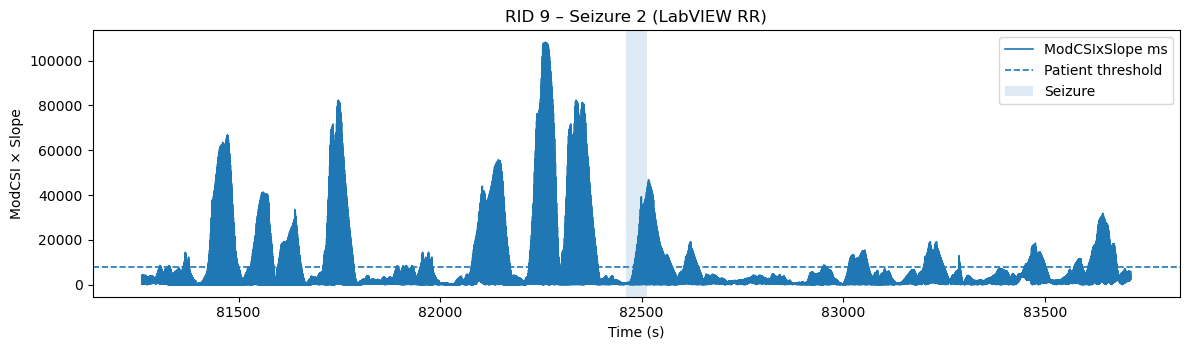

In [29]:
plot_feature_around_seizure(
    df_feat5_pilot,
    df_seiz,
    recording_uid=9,
    seizure_idx=1,          # “Seizure 2”
    rr_source="labview",
    pre_s=20*60,
    post_s=20*60,
    show_sqi_windows=True,
    show_event_peaks=False,
)


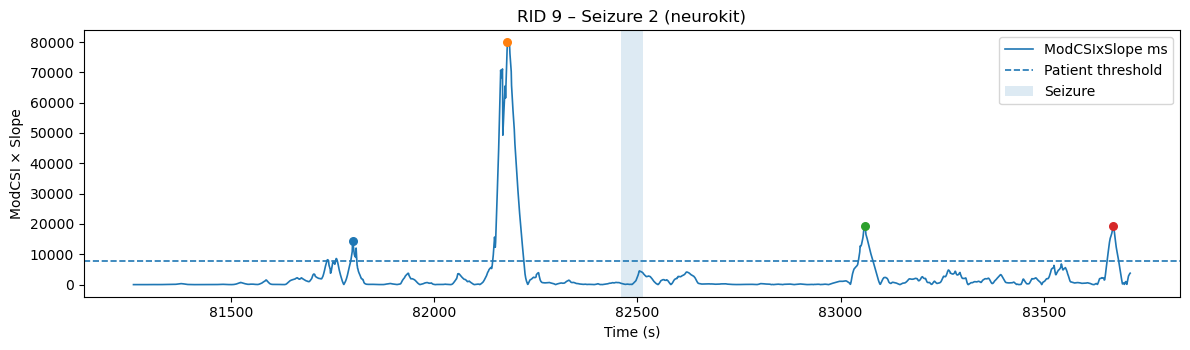

In [30]:
plot_feature_around_seizure(
    df_feat5_pilot,
    df_seiz,
    recording_uid=9,
    seizure_idx=1,
    rr_source="python",
    algo_id="neurokit",
    pre_s=20*60,
    post_s=20*60,
    show_sqi_windows=True,
    show_event_peaks=True,      # viser event-peak pr cluster (gap=180s)
    gap_s_for_events=180.0,
)


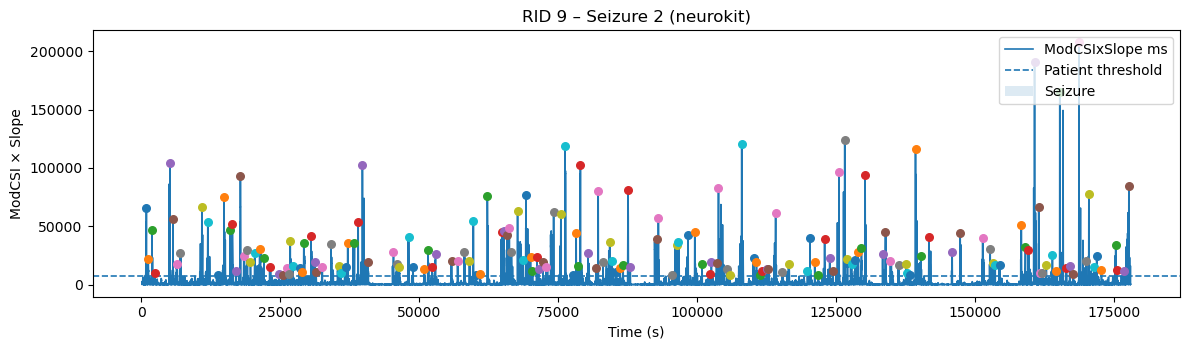

In [42]:
plot_feature_around_seizure(
    df_feat5_pilot,
    df_seiz,
    recording_uid=9,
    seizure_idx=1,
    rr_source="python",
    algo_id="neurokit",
    pre_s=2000*60,
    post_s=2000*60,
    show_sqi_windows=False,
    show_event_peaks=True,      # viser event-peak pr cluster (gap=180s)
    gap_s_for_events=180.0,
)

In [49]:
# Count seizures present in recordings covered by df_feat5_pilot
rids = df_feat5_pilot["recording_uid"].unique()
seiz_count = df_seiz[df_seiz["recording_uid"].isin(rids)].shape[0]
print("Seizures in df_feat5_pilot recordings:", seiz_count)

Seizures in df_feat5_pilot recordings: 149
